# SciServer Example: Analysis of HEASARC data with minimal Machine Learning
<font size="3">Assume that we know nothing about the stellar system Eta Carinae, but want to gain a broad understanding of its behavior.  We can achieve this with very litte code and some basic machine learning techniques.</font>

In [1]:
#necessary imports
import sys,os
import pyvo as vo
import numpy as np
from astropy.io import fits
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline  
import xspec
xspec.Xset.allowPrompting = False 
# Ignore unimportant warnings
import warnings
warnings.filterwarnings('ignore', '.*Unknown element mirrorURL.*', 
                        vo.utils.xml.elements.UnknownElementWarning)
%matplotlib inline

In [2]:
# Set up the catalog
tap_services=vo.regsearch(servicetype='tap',keywords=['heasarc'])
heasarc_tables=tap_services[0].service.tables

<font size="3">Get the coordinates for Eta Carinae and find all observations of it from the xtemaster catalog.</font>

In [3]:
import astropy.coordinates as coord
pos=coord.SkyCoord.from_name("Eta Car")
## For now, have to google xtemaster to get the columns, find them here:
##  https://heasarc.gsfc.nasa.gov/W3Browse/all/xtemaster.html
##  (In future, should be a pyvo function.)
query="""SELECT target_name, cycle, prnb, obsid, time, exposure, ra, dec 
    FROM public.xtemaster as cat 
    where 
    contains(point('ICRS',cat.ra,cat.dec),circle('ICRS',{},{},0.1))=1 
    and 
    cat.exposure > 0 order by cat.time
    """.format(pos.ra.deg, pos.dec.deg)

<font size="3">Retrieve all RXTE observations of Eta Carinae</font>

In [4]:
results=tap_services[0].search(query).to_table()
results

target_name,cycle,prnb,obsid,time,exposure,ra,dec
,,,,mjd,s,deg,deg
object,int16,int32,object,float64,float64,float64,float64
ETA_CAR,1,10004,10004-01-40-00,50122.64263,1091,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-39-00,50129.42992,945,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-38-00,50134.57053,1018,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-41-00,50142.85058,958,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-37-00,50147.83134,1778,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-36-00,50150.58692,696,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-36-01,50154.99084,1098,161.2583,-59.6800
ETA_CAR,1,10004,10004-01-35-00,50162.75743,1109,161.2583,-59.6800


<font size="3">Collect useful information from the table</font>

In [5]:
pids=np.unique( results['cycle','prnb'])
pids

array([( 1, 10004), ( 2, 20003), ( 2, 20419), ( 3, 30006), ( 4, 40003),
       ( 5, 50003), ( 6, 60003), ( 7, 70001), ( 8, 80001), ( 9, 90004),
       (10, 91001), (11, 92001), (12, 93002), (13, 94002), (13, 94418),
       (14, 95002), (15, 96002)],
      dtype=[('cycle', '<i2'), ('prnb', '<i4')])

<font size="3">Construct a file list of all the spectra in the standard products, keep the times for later reference</font>

In [6]:
rootdir="/home/idies/workspace/headata/FTP/"
rxtedata="rxte/data/archive/"
sfilenames=[]
bfilenames=[]
rfilenames=[]
times=[]
for i in tqdm(range(pids.shape[0])):
    if not os.path.isdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])):
        print(f"Skipping {pids[i]}")
        continue
    obsdirs=os.listdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1]))
    if 'FMI' in obsdirs:
        obsdirs.remove('FMI')
    for obsdir in obsdirs:
        if os.path.isdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod'):
            obsfiles=os.listdir(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod')
            sphafiles=[f for f in obsfiles if f.endswith('s2.pha.gz')]
            bphafiles=[f for f in obsfiles if f.endswith('b2.pha.gz')]
            rspfiles=[f for f in obsfiles if f.endswith('.rsp.gz')]
            if (len(sphafiles)==1) & (len(bphafiles)==1) & (len(rspfiles)==1):
                sfilenames.append(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod/'+sphafiles[0])
                bfilenames.append(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod/'+bphafiles[0])
                rfilenames.append(rootdir+rxtedata+'AO'+str(pids[i][0])+'/P'+str(pids[i][1])+'/'+obsdir+'/stdprod/'+rspfiles[0])
                fitsfile=fits.open(sfilenames[-1],memmap=False)
                times.append(fitsfile[0].header['TSTART'])

100% 17/17 [02:49<00:00,  9.97s/it]


<font size="3">Change the spectra from channel space to energy space. This is especially necessary for RXTE, where the energy values of channels changed over the course of the mission.
</font>

In [7]:
pids

array([( 1, 10004), ( 2, 20003), ( 2, 20419), ( 3, 30006), ( 4, 40003),
       ( 5, 50003), ( 6, 60003), ( 7, 70001), ( 8, 80001), ( 9, 90004),
       (10, 91001), (11, 92001), (12, 93002), (13, 94002), (13, 94418),
       (14, 95002), (15, 96002)],
      dtype=[('cycle', '<i2'), ('prnb', '<i4')])

In [8]:
specs=[]

#select energy range to interpolate
#start at 2 keV due to low-resolution noise below that energy - specific to RXTE
#stop at 12 keV due to no visible activity from Eta Carinae above that energy
#step size of .1 keV

xref=np.arange(2.,12.,.1)

for src,bkg,rsp in tqdm(zip(sfilenames,bfilenames,rfilenames)):
    xspec.AllData.clear()  # clear out any previously loaded dataset
    s = xspec.Spectrum(src) 
    s.background=bkg
    s.response=rsp
    xspec.Plot.area=True;
    xspec.Plot.xAxis = "keV";
    xspec.Plot.add = True;
    xspec.Plot("data");
    xspec.Plot.background = True;
    xVals = xspec.Plot.x();
    yVals = xspec.Plot.y();
    yref= np.interp(xref, xVals, yVals); 
    specs.append(yref);

specs=np.array(specs)

1it [00:00,  5.80it/s]r: cannot read response file xp10004011500.rsp

***XSPEC Error:  cannot open file named: xp10004011500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004011400.rsp

***XSPEC Error:  cannot open file named: xp10004011400_b2.pha
Error: cannot read background file 
3it [00:00,  6.14it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-15-00/stdprod/xp10004011500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.304e+02 +/- 3.886e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.210e+01 +/- 5.032e-01 (32.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-14-00/stdprod/xp10004011400_s2

Error: cannot read response file xp10004010300.rsp

***XSPEC Error:  cannot open file named: xp10004010300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004013601.rsp

***XSPEC Error:  cannot open file named: xp10004013601_b2.pha
Error: cannot read background file 
4it [00:00,  6.31it/s]Error: cannot read response file xp10004011600.rsp

***XSPEC Error:  cannot open file named: xp10004011600_b2.pha
Error: cannot read background file 
5it [00:00,  6.28it/s]Error: cannot read response file xp10004013900.rsp

***XSPEC Error:  cannot open file named: xp10004013900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-36-01/stdprod/xp10004013601_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.831e+02 +/- 4.332e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.247e+01 +/- 5.670e-01 (28.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-16-00/stdprod/xp10004011600_s2

6it [00:00,  6.32it/s]Error: cannot read response file xp10004013800.rsp

***XSPEC Error:  cannot open file named: xp10004013800_b2.pha
Error: cannot read background file 
7it [00:01,  6.40it/s]Error: cannot read response file xp10004011700.rsp


Net count rate (cts/s) for Spectrum:1  4.954e+01 +/- 5.969e-01 (26.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-38-00/stdprod/xp10004013800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.850e+02 +/- 4.319e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 992 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.030e+01 +/- 5.677e-01 (27.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade


***XSPEC Error:  cannot open file named: xp10004011700_b2.pha
Error: cannot read background file 
9it [00:01,  6.66it/s]Error: cannot read response file xp10004011300.rsp

***XSPEC Error:  cannot open file named: xp10004011300_b2.pha
Error: cannot read background file 
10it [00:01,  6.81it/s]Error: cannot read response file xp10004010400.rsp

***XSPEC Error:  cannot open file named: xp10004010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004010500.rsp

***XSPEC Error:  cannot open file named: xp10004010500_b2.pha
Error: cannot read background file 
11it [00:01,  6.98it/s]Error: cannot read response file xp10004011200.rsp

***XSPEC Error:  cannot open file named: xp10004011200_b2.pha
Error: cannot read background file 
12it [00:01,  6.88it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-13-00/stdprod/xp10004011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.112e+02 +/- 3.492e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.089e+01 +/- 4.583e-01 (27.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-04-00/stdprod/xp10004010400_s2

14it [00:02,  6.61it/s]Error: cannot read response file xp10004011000.rsp

***XSPEC Error:  cannot open file named: xp10004011000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004010700.rsp

***XSPEC Error:  cannot open file named: xp10004010700_b2.pha
Error: cannot read background file 
15it [00:02,  6.59it/s]Error: cannot read response file xp10004012800.rsp

***XSPEC Error:  cannot open file named: xp10004012800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004012900.rsp

***XSPEC Error:  cannot open file named: xp10004012900_b2.pha
Error: cannot read background file 
16it [00:02,  6.76it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-10-00/stdprod/xp10004011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.186e+02 +/- 3.544e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.352e+01 +/- 4.644e-01 (28.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-07-00/stdprod/xp10004010700_s2

Error: cannot read response file xp10004010600.rsp

***XSPEC Error:  cannot open file named: xp10004010600_b2.pha
Error: cannot read background file 
17it [00:02,  6.56it/s]Error: cannot read response file xp10004011100.rsp

***XSPEC Error:  cannot open file named: xp10004011100_b2.pha
Error: cannot read background file 
18it [00:02,  6.60it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-06-00/stdprod/xp10004010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.254e+02 +/- 3.960e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.847e+01 +/- 5.153e-01 (30.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-11-00/stdprod/xp10004011100_s2

19it [00:02,  6.61it/s]Error: cannot read response file xp10004012000.rsp

***XSPEC Error:  cannot open file named: xp10004012000_b2.pha
Error: cannot read background file 
20it [00:03,  6.70it/s]ponse file xp10004011800.rsp

***XSPEC Error:  cannot open file named: xp10004011800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004013700.rsp

***XSPEC Error:  cannot open file named: xp10004013700_b2.pha
Error: cannot read background file 
21it [00:03,  6.65it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-20-00/stdprod/xp10004012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.147e+02 +/- 3.579e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.507e+01 +/- 4.658e-01 (30.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-

Error: cannot read response file xp10004013600.rsp

***XSPEC Error:  cannot open file named: xp10004013600_b2.pha
Error: cannot read background file 
22it [00:03,  6.63it/s]Error: cannot read response file xp10004011900.rsp

***XSPEC Error:  cannot open file named: xp10004011900_b2.pha
Error: cannot read background file 
24it [00:03,  6.65it/s]Erro


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-36-00/stdprod/xp10004013600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.070e+02 +/- 7.850e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 336 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.073e+01 +/- 1.040e+00 (24.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-19-00/stdprod/xp10004011900_s2

r: cannot read response file xp10004012100.rsp

***XSPEC Error:  cannot open file named: xp10004012100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004012300.rsp

***XSPEC Error:  cannot open file named: xp10004012300_b2.pha
Error: cannot read background file 
25it [00:03,  6.66it/s]Error: cannot read response file xp10004012200.rsp

***XSPEC Error:  cannot open file named: xp10004012200_b2.pha
Error: cannot read background file 
27it [00:04,  7.00it/s]Error: cannot read response file xp10004013100.rsp

***XSPEC Error:  cannot open file named: xp10004013100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-23-00/stdprod/xp10004012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.988e+02 +/- 6.912e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 416 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.357e+01 +/- 9.093e-01 (26.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-22-00/stdprod/xp10004012200_s2

Error: cannot read response file xp10004014100.rsp

***XSPEC Error:  cannot open file named: xp10004014100_b2.pha
Error: cannot read background file 
28it [00:04,  6.80it/s]Error: cannot read response file xp10004010900.rsp

***XSPEC Error:  cannot open file named: xp10004010900_b2.pha
Error: cannot read background file 
29it [00:04,  6.58it/s]Error: cannot read response


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-31-00/stdprod/xp10004013100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.515e+02 +/- 3.908e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 992 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.288e+01 +/- 5.120e-01 (28.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-41-00/stdprod/xp10004014100_s2.pha.gz  Spectrum 1
Net count 

30it [00:04,  6.58it/s] file xp10004012600.rsp

***XSPEC Error:  cannot open file named: xp10004012600_b2.pha
Error: cannot read background file 
31it [00:04,  6.64it/s]esponse file xp10004012700.rsp

***XSPEC Error:  cannot open file named: xp10004012700_b2.pha
Error: cannot read background file 
Error: cannot read 

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-27-00/stdprod/xp10004012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.275e+02 +/- 2.768e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1664 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.823e+01 +/- 3.609e-01 (30.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01

32it [00:04,  6.47it/s]response file xp10004010800.rsp

***XSPEC Error:  cannot open file named: xp10004010800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004014000.rsp

***XSPEC Error:  cannot open file named: xp10004014000_b2.pha
Error: cannot read background file 
34it [00:05,  6.66it/s]Error: cannot read response file xp10004013000.rsp

***XSPEC Error:  cannot open file named: xp10004013000_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-40-00/stdprod/xp10004014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.907e+02 +/- 4.186e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1088 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.955e+01 +/- 5.522e-01 (26.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01

35it [00:05,  6.32it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-32-00/stdprod/xp10004013200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.172e+02 +/- 3.585e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.299e+01 +/- 4.699e-01 (28.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-25-00/stdprod/xp10004012500_s2

Error: cannot read response file xp10004013200.rsp

***XSPEC Error:  cannot open file named: xp10004013200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp10004012500.rsp

***XSPEC Error:  cannot open file named: xp10004012500_b2.pha
Error: cannot read background file 
36it [00:05,  6.47it/s]Error: cannot read response file xp10004012400.rsp

***XSPEC Error:  cannot open file named: xp10004012400_b2.pha
Error: cannot read background file 
38it [00:05,  6.63it/s]Error: cannot read


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO1/P10004/10004-01-24-00/stdprod/xp10004012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.611e+02 +/- 3.688e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1184 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.229e+01 +/- 4.774e-01 (32.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


 response file xp20003011200.rsp

***XSPEC Error:  cannot open file named: xp20003011200_b2.pha
Error: cannot read background file 
39it [00:05,  6.56it/s]Error: cannot read response file xp20003010210.rsp

***XSPEC Error:  cannot open file named: xp20003010210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003010500.rsp

***XSPEC Error:  cannot open file named: xp20003010500_b2.pha
Error: cannot read background file 
40it [00:06,  6.57it/s]Error: 


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-12-00/stdprod/xp20003011200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.174e+02 +/- 4.799e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.436e+01 +/- 6.180e-01 (34.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-02-10/stdprod/xp20003010210_s2.pha.gz  Spectrum 1
Net count 

cannot read response file xp20003010400.rsp

***XSPEC Error:  cannot open file named: xp20003010400_b2.pha
Error: cannot read background file 
42it [00:06,  6.55it/s]Error: cannot read response file xp20003011300.rsp

***XSPEC Error:  cannot open file named: xp20003011300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003011100.rsp

***XSPEC Error:  cannot open file named: xp20003011100_b2.pha
Error: cannot read background file 
43it [00:06,  6.70it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-13-00/stdprod/xp20003011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.277e+02 +/- 5.041e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.744e+01 +/- 6.495e-01 (34.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-

44it [00:06,  6.73it/s]Error: cannot read response file xp20003010600.rsp

***XSPEC Error:  cannot open file named: xp20003010600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003012900.rsp

***XSPEC Error:  cannot open file named: xp20003012900_b2.pha
Error: cannot read background file 
45it [00:06,  6.65it/s]Error: cannot read response file xp20003012800.rsp

***XSPEC Error:  cannot open file named: xp20003012800_b2.pha
Error: cannot read background file 
46it [00:06,  6.75it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-06-00/stdprod/xp20003010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.300e+02 +/- 3.776e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.153e+01 +/- 4.895e-01 (31.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-29-00/stdprod/xp20003012900_s2

Error: cannot read response file xp20003010700.rsp

***XSPEC Error:  cannot open file named: xp20003010700_b2.pha
Error: cannot read background file 
48it [00:07,  6.84it/s]Error: cannot read response file xp20003011000.rsp

***XSPEC Error:  cannot open file named: xp20003011000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003010300.rsp

***XSPEC Error:  cannot open file named: xp20003010300_b2.pha
Error: cannot read background file 
49it [00:07,  6.75it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-07-00/stdprod/xp20003010700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.137e+02 +/- 3.661e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.021e+01 +/- 4.822e-01 (26.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-10-00/stdprod/xp20003011000_s2

50it [00:07,  6.73it/s]sponse file xp20003011400.rsp

***XSPEC Error:  cannot open file named: xp20003011400_b2.pha
Error: cannot read background file 
51it [00:07,  6.72it/s]sponse file xp20003011500.rsp

***XSPEC Error:  cannot open file named: xp20003011500_b2.pha
Error: cannot read background file 
52it [00:07,  6.72it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-14-00/stdprod/xp20003011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.262e+02 +/- 4.054e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.861e+01 +/- 5.277e-01 (30.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-15-00/stdprod/xp20003011500_s2

Error: cannot read response file xp20003010200.rsp

***XSPEC Error:  cannot open file named: xp20003010200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003011700.rsp

***XSPEC Error:  cannot open file named: xp20003011700_b2.pha
Error: cannot read background file 
53it [00:07,  6.77it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-17-00/stdprod/xp20003011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.915e+02 +/- 4.467e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.059e+01 +/- 5.796e-01 (31.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-

54it [00:08,  6.72it/s]ad response file xp20003014800.rsp

***XSPEC Error:  cannot open file named: xp20003014800_b2.pha
Error: cannot read background file 
55it [00:08,  6.88it/s]Error: cannot read response file xp20003013800.rsp

***XSPEC Error:  cannot open file named: xp20003013800_b2.pha
Error: cannot read background file 
56it [00:08,  6.79it/s]Error: cannot read response file xp20003013900.rsp

***XSPEC Error:  cannot open file named: xp20003013900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003014900.rsp

***XSPEC Error:  cannot open file named: xp20003014900_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  6.554e+01 +/- 4.855e-01 (44.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-38-00/stdprod/xp20003013800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.492e+02 +/- 5.484e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 496 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.271e+01 +/- 7.037e-01 (35.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

58it [00:08,  6.70it/s]Error: cannot read response file xp20003011600.rsp

***XSPEC Error:  cannot open file named: xp20003011600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003010100.rsp

***XSPEC Error:  cannot open file named: xp20003010100_b2.pha
Error: cannot read background file 
59it [00:08,  6.70it/s]Error: cannot read response file xp20003013000.rsp

***XSPEC Error:  cannot open file named: xp20003013000_b2.pha
Error: cannot read background file 
60it [00:09,  6.62it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-16-00/stdprod/xp20003011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.115e+02 +/- 3.791e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.908e+01 +/- 4.904e-01 (32.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01

Error: cannot read response file xp20003014000.rsp

***XSPEC Error:  cannot open file named: xp20003014000_b2.pha
Error: cannot read background file 
61it [00:09,  6.32it/s]Error: cannot read response file xp20003010800.rsp

***XSPEC Error:  cannot open file named: xp20003010800_b2.pha
Error: cannot read background file 
62it [00:09,  6.32it/s]Error: cannot read response file xp20003012700.rsp

***XSPEC Error:  cannot open file named: xp20003012700_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-40-00/stdprod/xp20003014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.375e+02 +/- 5.183e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 512 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.599e+01 +/- 6.541e-01 (40.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-08-00/stdprod/xp20003010800_s2

63it [00:09,  6.14it/s]Error: cannot read response file xp20003012600.rsp

***XSPEC Error:  cannot open file named: xp20003012600_b2.pha
Error: cannot read background file 
64it [00:09,  6.32it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-27-00/stdprod/xp20003012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.067e+02 +/- 6.076e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 560 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.183e+01 +/- 7.810e-01 (34.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-26-00/stdprod/xp20003012600_s2.pha.gz  Spectrum 1
Net count 

Error: cannot read response file xp20003010900.rsp

***XSPEC Error:  cannot open file named: xp20003010900_b2.pha
Error: cannot read background file 
66it [00:09,  6.55it/s]Error: cannot read response file xp20003014100.rsp

***XSPEC Error:  cannot open file named: xp20003014100_b2.pha
Error: cannot read background file 
67it [00:10,  6.72it/s]Error: cannot read response file xp20003013100.rsp

***XSPEC Error:  cannot open file named: xp20003013100_b2.pha
Error: cannot read background file 
68it [00:10,  6.76it/s]annot read response file xp20003014300.rsp

***XSPEC Error:  cannot open file named: xp20003014300_b2.pha
Error: cannot read background file 
69it [00:10,  6.76it/s]Error: cannot read response file xp20003013300.rsp

***XSPEC Error:  cannot open file named: xp20003013300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003012400.rsp

***XSPEC Error:  cannot open file named: xp20003012400_b2.pha
Error: cannot read background file 
70it [00:10,  6.

Net count rate (cts/s) for Spectrum:1  3.978e+01 +/- 5.717e-01 (26.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-41-00/stdprod/xp20003014100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.330e+02 +/- 5.292e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.452e+01 +/- 6.682e-01 (40.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

71it [00:10,  6.61it/s] cannot read response file xp20003015400.rsp

***XSPEC Error:  cannot open file named: xp20003015400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003012500.rsp

***XSPEC Error:  cannot open file named: xp20003012500_b2.pha
Error: cannot read background file 
72it [00:10,  6.57it/s]Error: cannot read response file xp20003013200.rsp

***XSPEC Error:  cannot open file named: xp20003013200_b2.pha
Error: cannot read background file 
73it [00:11,  6.20it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-54-00/stdprod/xp20003015400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.171e+02 +/- 3.382e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1024 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.174e+01 +/- 4.447e-01 (27.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-25-00/stdprod/xp20003012500_s

Error: cannot read response file xp20003014200.rsp

***XSPEC Error:  cannot open file named: xp20003014200_b2.pha
Error: cannot read background file 
74it [00:11,  6.21it/s]Error: cannot read response file xp20003012100.rsp

***XSPEC Error:  cannot open file named: xp20003012100_b2.pha
Error: cannot read background file 
75it [00:11,  6.33it/s]Error: cannot read response file xp20003015100.rsp

***XSPEC Error:  cannot open file named: xp20003015100_b2.pha
Error: cannot read background file 
76it [00:11,  6.23it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-42-00/stdprod/xp20003014200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.575e+02 +/- 4.156e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.986e+01 +/- 5.185e-01 (44.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-21-00/stdprod/xp20003012100_s2

Error: cannot read response file xp20003011900.rsp

***XSPEC Error:  cannot open file named: xp20003011900_b2.pha
Error: cannot read background file 
78it [00:11,  6.49it/s]Error: cannot read response file xp20003014600.rsp

***XSPEC Error:  cannot open file named: xp20003014600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003013600.rsp

***XSPEC Error:  cannot open file named: xp20003013600_b2.pha
Error: cannot read background file 
79it [00:11,  6.65it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-19-00/stdprod/xp20003011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.729e+02 +/- 4.433e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.693e+01 +/- 5.730e-01 (32.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-46-00/stdprod/xp20003014600_s2

Error: cannot read response file xp20003013700.rsp

***XSPEC Error:  cannot open file named: xp20003013700_b2.pha
Error: cannot read background file 
80it [00:12,  6.70it/s]Error: cannot read response file xp20003014700.rsp

***XSPEC Error:  cannot open file named: xp20003014700_b2.pha
Error: cannot read background file 
81it [00:12,  6.67it/s]Error: cannot read resp


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-37-00/stdprod/xp20003013700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.472e+02 +/- 3.179e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.176e+01 +/- 3.997e-01 (42.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-47-00/stdprod/xp20003014700_s

onse file xp20003011800.rsp

***XSPEC Error:  cannot open file named: xp20003011800_b2.pha
Error: cannot read background file 
82it [00:12,  6.65it/s]Error: cannot read response file xp20003015000.rsp

***XSPEC Error:  cannot open file named: xp20003015000_b2.pha
Error: cannot read background file 
83it [00:12,  6.60it/s]Error: cannot read response file xp20003012000.rsp

***XSPEC Error:  cannot open file named: xp20003012000_b2.pha
Error: cannot read background file 
84it [00:12,  6.65it/s]

Net count rate (cts/s) for Spectrum:1  6.960e+01 +/- 6.473e-01 (32.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-50-00/stdprod/xp20003015000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.720e+02 +/- 4.382e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.446e+01 +/- 5.383e-01 (49.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

Error: cannot read response file xp20003015200.rsp

***XSPEC Error:  cannot open file named: xp20003015200_b2.pha
Error: cannot read background file 
86it [00:13,  6.67it/s]Error: cannot read response file xp20003012200.rsp

***XSPEC Error:  cannot open file named: xp20003012200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20003013500.rsp

***XSPEC Error:  cannot open file named: xp20003013500_b2.pha
Error: cannot read background file 
87it [00:13,  6.54it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-22-00/stdprod/xp20003012200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.400e+02 +/- 3.918e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.274e+01 +/- 4.992e-01 (37.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-35-00/stdprod/xp20003013500_s2

Error: cannot read response file xp20003014500.rsp

***XSPEC Error:  cannot open file named: xp20003014500_b2.pha
Error: cannot read background file 
88it [00:13,  6.61it/s]Error: cannot read response file xp20003014400.rsp

***XSPEC Error:  cannot open file named: xp20003014400_b2.pha
Error: cannot read background file 
89it [00:13,  6.33it/s]Error: cannot read response file xp20003013400.rsp

***XSPEC Error:  cannot open file named: xp20003013400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-45-00/stdprod/xp20003014500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.361e+02 +/- 5.276e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.864e+01 +/- 6.725e-01 (37.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-44-00/stdprod/xp20003014400_s2

91it [00:13,  6.40it/s]Error: cannot read response file xp20003012300.rsp

***XSPEC Error:  cannot open file named: xp20003012300_b2.pha
Error: cannot read background file 
92it [00:13,  6.45it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-23-00/stdprod/xp20003012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.460e+02 +/- 5.193e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.826e+01 +/- 6.570e-01 (39.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20003/20003-01-

onse file xp20003015300.rsp

***XSPEC Error:  cannot open file named: xp20003015300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419013000.rsp

***XSPEC Error:  cannot open file named: xp20419013000_b2.pha
Error: cannot read background file 
94it [00:14,  6.73it/s]Error: cannot read response file xp20419010800.rsp

***XSPEC Error:  cannot open file named: xp20419010800_b2.pha
Error: cannot read background file 
95it [00:14,  6.84it/s]o


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-30-00/stdprod/xp20419013000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.376e+02 +/- 3.919e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.292e+01 +/- 4.980e-01 (38.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-08-00/stdprod/xp20419010800_s2

nse file xp20419012700.rsp

***XSPEC Error:  cannot open file named: xp20419012700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419012600.rsp

***XSPEC Error:  cannot open file named: xp20419012600_b2.pha
Error: cannot read background file 
96it [00:14,  6.88it/s]Error: cannot read response file xp20419010900.rsp

***XSPEC Error:  cannot open file named: xp20419010900_b2.pha
Error: cannot read background file 
97it [00:14,  6.77it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-27-00/stdprod/xp20419012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.524e+02 +/- 5.794e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 752 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.974e+01 +/- 7.519e-01 (31.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-26-00/stdprod/xp20419012600_s2.pha.gz  Spectrum 1
Net count 

98it [00:14,  6.94it/s]r: cannot read response file xp20419022100.rsp

***XSPEC Error:  cannot open file named: xp20419022100_b2.pha
Error: cannot read background file 
99it [00:14,  6.82it/s]r: cannot read response file xp20419012400.rsp

***XSPEC Error:  cannot open file named: xp20419012400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419021900.rsp

***XSPEC Error:  cannot open file named: xp20419021900_b2.pha
Error: cannot read background file 
101it [00:15,  6.60it/s]Erro

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-24-00/stdprod/xp20419012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.466e+02 +/- 5.350e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 512 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.420e+01 +/- 6.831e-01 (37.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-

r: cannot read response file xp20419021800.rsp

***XSPEC Error:  cannot open file named: xp20419021800_b2.pha
Error: cannot read background file 
102it [00:15,  6.73it/s]Error: cannot read response file xp20419012500.rsp

***XSPEC Error:  cannot open file named: xp20419012500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419022000.rsp

***XSPEC Error:  cannot open file named: xp20419022000_b2.pha
Error: cannot read background file 
103it [00:15,  6.81it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-25-00/stdprod/xp20419012500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.404e+02 +/- 3.889e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.262e+01 +/- 4.958e-01 (37.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-20-00/stdprod/xp20419022000_s2

Error: cannot read response file xp20419012100.rsp

***XSPEC Error:  cannot open file named: xp20419012100_b2.pha
Error: cannot read background file 
104it [00:15,  6.48it/s]Error: cannot read response file xp20419011900.rsp

***XSPEC Error:  cannot open file named: xp20419011900_b2.pha
Error: cannot read background file 
105it [00:15,  6.29it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-21-00/stdprod/xp20419012100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.430e+02 +/- 3.960e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.418e+01 +/- 5.042e-01 (37.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-

Error: cannot read response file xp20419011800.rsp

***XSPEC Error:  cannot open file named: xp20419011800_b2.pha
Error: cannot read background file 
106it [00:16,  6.51it/s]Error: cannot read response file xp20419012000.rsp

***XSPEC Error:  cannot open file named: xp20419012000_b2.pha
Error: cannot read background file 
107it [00:16,  6.41it/s]Error: cannot read response 


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-20-00/stdprod/xp20419012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.095e+02 +/- 9.047e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 256 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.650e+01 +/- 1.157e+00 (36.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


109it [00:16,  6.73it/s]file xp20419012200.rsp

***XSPEC Error:  cannot open file named: xp20419012200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419020800.rsp

***XSPEC Error:  cannot open file named: xp20419020800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419020900.rsp

***XSPEC Error:  cannot open file named: xp20419020900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-22-00/stdprod/xp20419012200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.427e+02 +/- 3.319e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.267e+01 +/- 4.238e-01 (36.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-08-00/stdprod/xp20419020800_s

111it [00:16,  6.67it/s]Error: cannot read response file xp20419012300.rsp

***XSPEC Error:  cannot open file named: xp20419012300_b2.pha
Error: cannot read background file 
112it [00:16,  6.81it/s]nnot read response file xp20419011200.rsp

***XSPEC Error:  cannot open file named: xp20419011200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419010500.rsp

***XSPEC Error:  cannot open file named: xp20419010500_b2.pha
Error: cannot read background file 
113it [00:17,  6.74it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-09-00/stdprod/xp20419020900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.499e+01 +/- 3.256e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.074e+01 +/- 4.473e-01 (11.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-23-00/stdprod/xp20419012300_s2.pha.gz  Spectrum 1
Net count 

114it [00:17,  6.80it/s] read response file xp20419021700.rsp

***XSPEC Error:  cannot open file named: xp20419021700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419021600.rsp

***XSPEC Error:  cannot open file named: xp20419021600_b2.pha
Error: cannot read background file 
115it [00:17,  6.61it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-17-00/stdprod/xp20419021700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.541e+01 +/- 2.713e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.054e+01 +/- 3.730e-01 (11.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-16-00/stdprod/xp20419021600_s

Error: cannot read response file xp20419010400.rsp

***XSPEC Error:  cannot open file named: xp20419010400_b2.pha
Error: cannot read background file 
116it [00:17,  6.65it/s]Error: cannot read response file xp20419011300.rsp

***XSPEC Error:  cannot open file named: xp20419011300_b2.pha
Error: cannot read background file 
117it [00:17,  6.78it/s]Error: cannot read response file xp20419020100.rsp

***XSPEC Error:  cannot open file named: xp20419020100_b2.pha
Error: cannot read background file 
118it [00:17,  6.79it/s]Error: cannot read response file xp20419020300.rsp

***XSPEC Error:  cannot open file named: xp20419020300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-13-00/stdprod/xp20419011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.482e+02 +/- 5.072e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 576 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.556e+01 +/- 6.466e-01 (37.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-01-00/stdprod/xp20419020100_s2

120it [00:18,  6.82it/s]Error: cannot read response file xp20419011100.rsp

***XSPEC Error:  cannot open file named: xp20419011100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419010600.rsp

***XSPEC Error:  cannot open file named: xp20419010600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-03-00/stdprod/xp20419020300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.616e+02 +/- 4.247e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.413e+01 +/- 5.777e-01 (14.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-11-00/stdprod/xp20419011100_s2

121it [00:18,  6.80it/s]Error: cannot read response file xp20419021400.rsp

***XSPEC Error:  cannot open file named: xp20419021400_b2.pha
Error: cannot read background file 
122it [00:18,  6.86it/s]Error: cannot read response file xp20419012900.rsp

***XSPEC Error:  cannot open file named: xp20419012900_b2.pha
Error: cannot read background file 
123it [00:18,  6.94it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-14-00/stdprod/xp20419021400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.508e+02 +/- 4.031e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.476e+01 +/- 5.560e-01 (9.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-2

Error: cannot read response file xp20419012800.rsp

***XSPEC Error:  cannot open file named: xp20419012800_b2.pha
Error: cannot read background file 
124it [00:18,  6.91it/s]Error: cannot read response file xp20419021500.rsp

***XSPEC Error:  cannot open file named: xp20419021500_b2.pha
Error: cannot read background file 
125it [00:18,  6.89it/s]Erro


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-28-00/stdprod/xp20419012800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.244e+02 +/- 5.097e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.304e+01 +/- 6.507e-01 (37.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-15-00/stdprod/xp20419021500_s2

126it [00:19,  6.84it/s]r: cannot read response file xp20419010700.rsp

***XSPEC Error:  cannot open file named: xp20419010700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419011000.rsp

***XSPEC Error:  cannot open file named: xp20419011000_b2.pha
Error: cannot read background file 
127it [00:19,  6.93it/s]Error: cannot read response file xp20419010300.rsp

***XSPEC Error:  cannot open file named: xp20419010300_b2.pha
Error: cannot read background file 
128it [00:19,  6.98it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-07-00/stdprod/xp20419010700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.520e+02 +/- 2.993e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1696 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.250e+01 +/- 3.850e-01 (34.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-10-00/stdprod/xp20419011000_s2.pha.gz  Spectrum 1
Net count

Error: cannot read response file xp20419021100.rsp

***XSPEC Error:  cannot open file named: xp20419021100_b2.pha
Error: cannot read background file 
130it [00:19,  6.93it/s]annot read response file xp20419020600.rsp

***XSPEC Error:  cannot open file named: xp20419020600_b2.pha
Error: cannot read background file 
131it [00:19,  6.93it/s]or: cannot read response file xp20419011400.rsp

***XSPEC Error:  cannot open file named: xp20419011400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419011500.rsp

***XSPEC Error:  cannot open file named: xp20419011500_b2.pha
Error: cannot read background file 
132it [00:19,  6.89it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-03-00/stdprod/xp20419010300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.379e+02 +/- 3.822e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.281e+01 +/- 4.859e-01 (38.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-11-00/stdprod/xp20419021100_s2

Error: cannot read response file xp20419020700.rsp

***XSPEC Error:  cannot open file named: xp20419020700_b2.pha
Error: cannot read background file 
133it [00:20,  6.98it/s]Error: cannot read response file xp20419020801.rsp

***XSPEC Error:  cannot open file named: xp20419020801_b2.pha
Error: cannot read background file 
135it [00:20,  6.95it/s]Error: cannot read response file xp20419021000.rsp

***XSPEC Error:  cannot open file named: xp20419021000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419010200.rsp

***XSPEC Error:  cannot open file named: xp20419010200_b2.pha
Error: cannot read background file 
136it [00:20,  6.97it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-08-01/stdprod/xp20419020801_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.865e+02 +/- 1.222e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 192 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.813e+01 +/- 1.669e+00 (13.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-10-00/stdprod/xp20419021000_s2

Error: cannot read response file xp20419021200.rsp
137it [00:20,  6.85it/s]
***XSPEC Error:  cannot open file named: xp20419021200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419020500.rsp

***XSPEC Error:  cannot open file named: xp20419020500_b2.pha
Error: cannot read background file 
138it [00:20,  6.85it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-12-00/stdprod/xp20419021200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.832e+01 +/- 3.255e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.514e+00 +/- 4.502e-01 (8.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-0

Error: cannot read response file xp20419011700.rsp

***XSPEC Error:  cannot open file named: xp20419011700_b2.pha
Error: cannot read background file 
140it [00:21,  6.82it/s]Error: cannot read response file xp20419012001.rsp

***XSPEC Error:  cannot open file named: xp20419012001_b2.pha
Error: cannot read background file 
Error: cannot read response file xp20419011600.rsp

***XSPEC Error:  cannot open file named: xp20419011600_b2.pha
Error: cannot read background file 
141it [00:21,  6.49it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-17-00/stdprod/xp20419011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.449e+02 +/- 4.173e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.837e+01 +/- 5.274e-01 (40.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-01-20-01/stdprod/xp20419012001_s2

Error: cannot read response file xp20419020400.rsp

***XSPEC Error:  cannot open file named: xp20419020400_b2.pha
Error: cannot read background file 
142it [00:21,  6.46it/s]Error: cannot read response file xp20419021300.rsp

***XSPEC Error:  cannot open file named: xp20419021300_b2.pha
Error: cannot read background file 
143it [00:21,  6.44it/s]Error: cannot read response file xp20419010100.rsp

***XSPEC Error:  cannot open file named: xp20419010100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-04-00/stdprod/xp20419020400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.139e+02 +/- 3.535e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.928e+01 +/- 4.782e-01 (16.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO2/P20419/20419-02-13-00/stdprod/xp20419021300_s2

145it [00:21,  6.86it/s]Error: cannot read response file xp30006041900.rsp

***XSPEC Error:  cannot open file named: xp30006041900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006021200.rsp

***XSPEC Error:  cannot open file named: xp30006021200_b2.pha
Error: cannot read background file 
146it [00:21,  6.83it/s]Error: cannot read response file xp30006050201.rsp

***XSPEC Error:  cannot open file named: xp30006050201_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-19-00/stdprod/xp30006041900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.366e+02 +/- 4.404e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.748e+01 +/- 5.661e-01 (34.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-12-00/stdprod/xp30006021200_s2

147it [00:22,  6.93it/s]Error: cannot read response file xp30006011700.rsp

***XSPEC Error:  cannot open file named: xp30006011700_b2.pha
Error: cannot read background file 
148it [00:22,  6.97it/s]Error: cannot read response file xp30006020500.rsp

***XSPEC Error:  cannot open file named: xp30006020500_b2.pha
Error: cannot read background file 
149it [00:22,  7.03it/s]

Net count rate (cts/s) for Spectrum:1  3.403e+01 +/- 1.791e+00 (23.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-17-00/stdprod/xp30006011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.093e+02 +/- 3.523e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.927e+01 +/- 4.758e-01 (17.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

Error: cannot read response file xp30006030600.rsp

***XSPEC Error:  cannot open file named: xp30006030600_b2.pha
Error: cannot read background file 
150it [00:22,  6.83it/s]Error: cannot read response file xp30006050402.rsp
151it [00:22,  6.82it/s]
***XSPEC Error:  cannot open file named: xp30006050402_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006052200.rsp

***XSPEC Error:  cannot open file named: xp30006052200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-03-06-00/stdprod/xp30006030600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.570e+02 +/- 3.667e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1168 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.416e+01 +/- 4.896e-01 (21.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-04-02/stdprod/xp30006050402_s

152it [00:22,  6.88it/s]Error: cannot read response file xp30006052300.rsp

***XSPEC Error:  cannot open file named: xp30006052300_b2.pha
Error: cannot read background file 
153it [00:22,  6.92it/s]Error: cannot read response file xp30006050502.rsp

***XSPEC Error:  cannot open file named: xp30006050502_b2.pha
Error: cannot read background file 
154it [00:23,  7.00it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-22-00/stdprod/xp30006052200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.177e+02 +/- 4.886e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.417e+01 +/- 6.466e-01 (24.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-23-00/stdprod/xp30006052300_s2.pha.gz  Spectrum 1
Net count 

Error: cannot read response file xp30006030700.rsp

***XSPEC Error:  cannot open file named: xp30006030700_b2.pha
Error: cannot read background file 
155it [00:23,  7.14it/s]Error: cannot read response file xp30006042000.rsp

***XSPEC Error:  cannot open file named: xp30006042000_b2.pha
Error: cannot read background file 
157it [00:23,  7.28it/s]Error: cannot rea


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-03-07-00/stdprod/xp30006030700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.212e+02 +/- 3.931e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.665e+01 +/- 5.122e-01 (30.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-20-00/stdprod/xp30006042000_s2

d response file xp30006020400.rsp

***XSPEC Error:  cannot open file named: xp30006020400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006011600.rsp

***XSPEC Error:  cannot open file named: xp30006011600_b2.pha
Error: cannot read background file 
158it [00:23,  7.24it/s]Error: cannot read response file xp30006010100.rsp

***XSPEC Error:  cannot open file named: xp30006010100_b2.pha
Error: cannot read background file 
159it [00:23,  7.35it/s]Error: cannot read response file xp30006021300.rsp

***XSPEC Error:  cannot open file named: xp30006021300_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-01-00/stdprod/xp30006010100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.524e+02 +/- 5.144e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 576 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.423e+01 +/- 7.103e-01 (9.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-1

160it [00:23,  7.35it/s]Error: cannot read response file xp30006050301.rsp

***XSPEC Error:  cannot open file named: xp30006050301_b2.pha
Error: cannot read background file 
161it [00:24,  7.35it/s]Error: cannot read response file xp30006041800.rsp

***XSPEC Error:  cannot open file named: xp30006041800_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-03-01/stdprod/xp30006050301_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.316e+02 +/- 3.312e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1200 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.659e+01 +/- 4.347e-01 (27.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04

162it [00:24,  7.29it/s]Error: cannot read response file xp30006051900.rsp

***XSPEC Error:  cannot open file named: xp30006051900_b2.pha
Error: cannot read background file 
163it [00:24,  7.26it/s]Error: cannot read response file xp30006021100.rsp
164it [00:24,  7.26it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-19-00/stdprod/xp30006051900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.495e+02 +/- 4.199e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.447e+01 +/- 5.479e-01 (29.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-


***XSPEC Error:  cannot open file named: xp30006021100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006010300.rsp

***XSPEC Error:  cannot open file named: xp30006010300_b2.pha
Error: cannot read background file 
165it [00:24,  7.29it/s]Error: cannot read response file xp30006030500.rsp

***XSPEC Error:  cannot open file named: xp30006030500_b2.pha
Error: cannot read background file 
166it [00:24,  7.33it/s]Error: can

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-03-05-00/stdprod/xp30006030500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.652e+02 +/- 4.372e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.580e+01 +/- 5.839e-01 (21.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-

not read response file xp30006052100.rsp

***XSPEC Error:  cannot open file named: xp30006052100_b2.pha
Error: cannot read background file 
167it [00:24,  7.33it/s]Error: cannot read response file xp30006011400.rsp

***XSPEC Error:  cannot open file named: xp30006011400_b2.pha
Error: cannot read background file 
169it [00:25,  7.22it/s]Error: cannot read response file xp30006020600.rsp

***XSPEC Error:  cannot open file named: xp30006020600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-14-00/stdprod/xp30006011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.023e+02 +/- 3.378e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.507e+01 +/- 4.598e-01 (14.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


170it [00:25,  7.22it/s]r: cannot read response file xp30006051701.rsp

***XSPEC Error:  cannot open file named: xp30006051701_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006020700.rsp

***XSPEC Error:  cannot open file named: xp30006020700_b2.pha
Error: cannot read background file 
171it [00:25,  7.13it/s]Error: cannot read response file xp30006011500.rsp

***XSPEC Error:  cannot open file named: xp30006011500_b2.pha
Error: cannot read background file 
172it [00:25,  7.05it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-06-00/stdprod/xp30006020600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.435e+02 +/- 3.966e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.776e+01 +/- 5.227e-01 (26.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-17-01/stdprod/xp30006051701_s2.pha.gz  Spectrum 1
Net count 

173it [00:25,  7.14it/s]Error: cannot read response file xp30006052000.rsp

***XSPEC Error:  cannot open file named: xp30006052000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006030400.rsp

***XSPEC Error:  cannot open file named: xp30006030400_b2.pha
Error: cannot read background file 
174it [00:25,  7.12it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-20-00/stdprod/xp30006052000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.245e+02 +/- 2.974e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.927e+01 +/- 3.859e-01 (31.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-03-04-00/stdprod/xp30006030400_s

Error: cannot read response file xp30006051800.rsp

***XSPEC Error:  cannot open file named: xp30006051800_b2.pha
Error: cannot read background file 
175it [00:26,  6.95it/s]Error: cannot read response file xp30006010200.rsp

***XSPEC Error:  cannot open file named: xp30006010200_b2.pha
Error: cannot read background file 
176it [00:26,  7.08it/s]Error: cannot read response file xp30006021000.rsp

***XSPEC Error:  cannot open file named: xp30006021000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-18-00/stdprod/xp30006051800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.296e+02 +/- 3.645e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.141e+01 +/- 4.725e-01 (31.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-02-00/stdprod/xp30006010200_s2

177it [00:26,  7.17it/s]Error: cannot read response file xp30006050202.rsp

***XSPEC Error:  cannot open file named: xp30006050202_b2.pha
Error: cannot read background file 
178it [00:26,  7.19it/s]Error: cannot read response file xp30006052400.rsp

***XSPEC Error:  cannot open file named: xp30006052400_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-02-02/stdprod/xp30006050202_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.494e+02 +/- 1.367e+00
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 80 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.899e+01 +/- 1.802e+00 (26.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


179it [00:26,  7.21it/s]Error: cannot read response file xp30006011100.rsp

***XSPEC Error:  cannot open file named: xp30006011100_b2.pha
Error: cannot read background file 
181it [00:26,  7.22it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-24-00/stdprod/xp30006052400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.161e+02 +/- 4.062e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.210e+01 +/- 5.332e-01 (27.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-11-00/stdprod/xp30006011100_s2

Error: cannot read response file xp30006010901.rsp

***XSPEC Error:  cannot open file named: xp30006010901_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006020300.rsp

***XSPEC Error:  cannot open file named: xp30006020300_b2.pha
Error: cannot read background file 
182it [00:26,  7.17it/s]Error: cannot read response file xp30006021400.rsp

***XSPEC Error:  cannot open file named: xp30006021400_b2.pha
Error: cannot read background file 
184it [00:27,  7.25it/s]Error: canno

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-03-00/stdprod/xp30006020300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.256e+02 +/- 3.325e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1136 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.758e+01 +/- 4.337e-01 (29.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02

t read response file xp30006010600.rsp

***XSPEC Error:  cannot open file named: xp30006010600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006050401.rsp

***XSPEC Error:  cannot open file named: xp30006050401_b2.pha
Error: cannot read background file 
185it [00:27,  7.10it/s]Error: cannot read response file xp30006012900.rsp

***XSPEC Error:  cannot open file named: xp30006012900_b2.pha
Error: cannot read background file 
186it [00:27,  6.99it/s]Error: cannot read response file xp30006012800.rsp

***XSPEC Error:  cannot open file named: xp30006012800_b2.pha
Error: cannot read background file 
187it [00:27,  7.03it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-04-01/stdprod/xp30006050401_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.375e+02 +/- 5.182e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 512 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.403e+01 +/- 6.716e-01 (32.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-29-00/stdprod/xp30006012900_s2

Error: cannot read response file xp30006010700.rsp

***XSPEC Error:  cannot open file named: xp30006010700_b2.pha
Error: cannot read background file 
188it [00:27,  7.11it/s]Error: cannot read response file xp30006021500.rsp

***XSPEC Error:  cannot open file named: xp30006021500_b2.pha
Error: cannot read background file 
189it [00:27,  7.15it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-07-00/stdprod/xp30006010700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.551e+02 +/- 4.088e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.755e+01 +/- 5.615e-01 (11.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-15-00/stdprod/xp30006021500_s2

Error: cannot read response file xp30006050501.rsp

***XSPEC Error:  cannot open file named: xp30006050501_b2.pha
Error: cannot read background file 
190it [00:28,  6.99it/s]Error: cannot read response file xp30006020200.rsp

***XSPEC Error:  cannot open file named: xp30006020200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-05-01/stdprod/xp30006050501_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.913e+02 +/- 5.844e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 560 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.774e+01 +/- 7.616e-01 (30.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-02-00/stdprod/xp30006020200_s2

191it [00:28,  7.16it/s]Error: cannot read response file xp30006011000.rsp

***XSPEC Error:  cannot open file named: xp30006011000_b2.pha
Error: cannot read background file 
192it [00:28,  7.15it/s]Error: cannot read response file xp30006052500.rsp

***XSPEC Error:  cannot open file named: xp30006052500_b2.pha
Error: cannot read background file 
193it [00:28,  7.04it/s]Error: cannot read response file xp30006050302.rsp

***XSPEC Error:  cannot open file named: xp30006050302_b2.pha
Error: cannot read background file 
194it [00:28,  6.94it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-10-00/stdprod/xp30006011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.117e+02 +/- 3.278e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1040 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.072e+01 +/- 4.523e-01 (9.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-25-00/stdprod/xp30006052500_s2

Error: cannot read response file xp30006030100.rsp

***XSPEC Error:  cannot open file named: xp30006030100_b2.pha
Error: cannot read background file 
196it [00:28,  7.05it/s]Error: cannot read response file xp30006040900.rsp

***XSPEC Error:  cannot open file named: xp30006040900_b2.pha
Error: cannot read background file 
197it [00:29,  7.25it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-03-01-00/stdprod/xp30006030100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.110e+02 +/- 3.618e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.857e+01 +/- 4.776e-01 (25.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-09-00/stdprod/xp30006040900_s2

Error: cannot read response file xp30006050800.rsp

***XSPEC Error:  cannot open file named: xp30006050800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006011200.rsp

***XSPEC Error:  cannot open file named: xp30006011200_b2.pha
Error: cannot read background file 
198it [00:29,  7.32it/s]Error: cannot read response file xp30006030300.rsp

***XSPEC Error:  cannot open file named: xp30006030300_b2.pha
Error: cannot read background file 
199it [00:29,  7.11it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-08-00/stdprod/xp30006050800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.933e+02 +/- 4.311e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1040 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.740e+01 +/- 5.626e-01 (29.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01

200it [00:29,  7.11it/s]d response file xp30006052700.rsp

***XSPEC Error:  cannot open file named: xp30006052700_b2.pha
Error: cannot read background file 
201it [00:29,  7.11it/s]Error: cannot read response file xp30006021700.rsp

***XSPEC Error:  cannot open file named: xp30006021700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006010500.rsp

***XSPEC Error:  cannot open file named: xp30006010500_b2.pha
Error: cannot read background file 
202it [00:29,  7.08it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-27-00/stdprod/xp30006052700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.291e+02 +/- 3.831e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.951e+01 +/- 4.986e-01 (30.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-17-00/stdprod/xp30006021700_s2

203it [00:29,  7.08it/s]ponse file xp30006050601.rsp

***XSPEC Error:  cannot open file named: xp30006050601_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006010400.rsp

***XSPEC Error:  cannot open file named: xp30006010400_b2.pha
Error: cannot read background file 
204it [00:30,  7.14it/s]Error: cannot read response file xp30006021600.rsp

***XSPEC Error:  cannot open file named: xp30006021600_b2.pha
Error: cannot read background file 
205it [00:30,  7.22it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-06-01/stdprod/xp30006050601_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.218e+02 +/- 4.802e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 528 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.966e+01 +/- 6.214e-01 (32.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-

Error: cannot read response file xp30006052600.rsp

***XSPEC Error:  cannot open file named: xp30006052600_b2.pha
Error: cannot read background file 
206it [00:30,  7.20it/s]Error: cannot read response file xp30006030200.rsp

***XSPEC Error:  cannot open file named: xp30006030200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-26-00/stdprod/xp30006052600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.273e+02 +/- 4.517e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 624 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.706e+01 +/- 5.905e-01 (29.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-03-02-00/stdprod/xp30006030200_s2

207it [00:30,  7.23it/s]Error: cannot read response file xp30006050900.rsp

***XSPEC Error:  cannot open file named: xp30006050900_b2.pha
Error: cannot read background file 
208it [00:30,  7.00it/s]Error: cannot read response file xp30006020100.rsp

***XSPEC Error:  cannot open file named: xp30006020100_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  5.008e+01 +/- 6.003e-01 (26.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-09-00/stdprod/xp30006050900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.248e+02 +/- 3.699e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.265e+01 +/- 4.877e-01 (26.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

210it [00:30,  7.07it/s]Error: cannot read response file xp30006011300.rsp

***XSPEC Error:  cannot open file named: xp30006011300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006012200.rsp

***XSPEC Error:  cannot open file named: xp30006012200_b2.pha
Error: cannot read background file 
211it [00:31,  7.09it/s]Error: cannot read response file xp30006041400.rsp


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-13-00/stdprod/xp30006011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.564e+02 +/- 4.070e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.683e+01 +/- 5.600e-01 (10.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-

212it [00:31,  7.13it/s]
***XSPEC Error:  cannot open file named: xp30006041400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006040300.rsp

***XSPEC Error:  cannot open file named: xp30006040300_b2.pha
Error: cannot read background file 
213it [00:31,  7.13it/s]Error: cannot read response file xp30006020800.rsp

***XSPEC Error:  cannot open file named: xp30006020800_b2.pha
Error: cannot read background file 
214it [00:31,  7.20it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-03-00/stdprod/xp30006040300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.280e+02 +/- 3.621e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.075e+01 +/- 4.696e-01 (31.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-08-00/stdprod/xp30006020800_s2

Error: cannot read response file xp30006051801.rsp

***XSPEC Error:  cannot open file named: xp30006051801_b2.pha
Error: cannot read background file 
215it [00:31,  7.19it/s]Error: cannot read response file xp30006020900.rsp

***XSPEC Error:  cannot open file named: xp30006020900_b2.pha
Error: cannot read background file 
216it [00:31,  7.24it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-18-01/stdprod/xp30006051801_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.155e+02 +/- 3.838e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.365e+01 +/- 5.016e-01 (29.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-09-00/stdprod/xp30006020900_s2

Error: cannot read response file xp30006050100.rsp

***XSPEC Error:  cannot open file named: xp30006050100_b2.pha
Error: cannot read background file 
217it [00:31,  7.31it/s]Error: cannot read response file xp30006013400.rsp
218it [00:32,  7.37it/s]
***XSPEC Error:  cannot open file named: xp30006013400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006040200.rsp

***XSPEC Error:  cannot open file named: xp30006040200_b2.pha
Error: cannot read background file 
219it [00:32,  7.26it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-34-00/stdprod/xp30006013400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.509e+02 +/- 3.870e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1008 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.404e+01 +/- 5.155e-01 (22.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-02-00/stdprod/xp30006040200_s

Error: cannot read response file xp30006041500.rsp

***XSPEC Error:  cannot open file named: xp30006041500_b2.pha
Error: cannot read background file 
220it [00:32,  7.36it/s]Error: cannot read response file xp30006012300.rsp

***XSPEC Error:  cannot open file named: xp30006012300_b2.pha
Error: cannot read background file 
221it [00:32,  7.50it/s]Error: cannot read response file xp30006051600.rsp

***XSPEC Error:  cannot open file named: xp30006051600_b2.pha
Error: cannot read background file 
222it [00:32,  7.37it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-15-00/stdprod/xp30006041500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.347e+02 +/- 3.715e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.659e+01 +/- 4.777e-01 (34.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-23-00/stdprod/xp30006012300_s2

Error: cannot read response file xp30006012100.rsp

***XSPEC Error:  cannot open file named: xp30006012100_b2.pha
Error: cannot read background file 
223it [00:32,  7.08it/s]Error: cannot read response file xp30006041700.rsp

***XSPEC Error:  cannot open file named: xp30006041700_b2.pha
Error: cannot read background file 
225it [00:32,  7.23it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-21-00/stdprod/xp30006012100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.140e+02 +/- 3.600e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.809e+01 +/- 4.885e-01 (15.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-17-00/stdprod/xp30006041700_s2

Error: cannot read response file xp30006051400.rsp

***XSPEC Error:  cannot open file named: xp30006051400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006050300.rsp

***XSPEC Error:  cannot open file named: xp30006050300_b2.pha
Error: cannot read background file 
227it [00:33,  7.35it/s]Error: cannot read response file xp30006011900.rsp

***XSPEC Error:  cannot open file named: xp30006011900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006030800.rsp

***XSPEC Error:  cannot open file named: xp30006030800_b2.pha
Error: cannot read background file 
228it [00:33,  7.13it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-03-00/stdprod/xp30006050300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.867e+02 +/- 4.607e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.317e+01 +/- 6.033e-01 (28.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-19-00/stdprod/xp30006011900_s2

Error: cannot read response file xp30006040100.rsp

***XSPEC Error:  cannot open file named: xp30006040100_b2.pha
Error: cannot read background file 
229it [00:33,  7.08it/s]Error: cannot read response file xp30006030900.rsp

***XSPEC Error:  cannot open file named: xp30006030900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-01-00/stdprod/xp30006040100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.271e+02 +/- 3.192e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1248 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.854e+01 +/- 4.157e-01 (30.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


231it [00:33,  7.10it/s]Error: cannot read response file xp30006050200.rsp

***XSPEC Error:  cannot open file named: xp30006050200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006011800.rsp

***XSPEC Error:  cannot open file named: xp30006011800_b2.pha
Error: cannot read background file 
232it [00:33,  7.10it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-03-09-00/stdprod/xp30006030900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.150e+02 +/- 4.320e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1152 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.443e+01 +/- 5.634e-01 (30.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-02-00/stdprod/xp30006050200_s2.pha.gz  Spectrum 1
Net count

Error: cannot read response file xp30006051500.rsp

***XSPEC Error:  cannot open file named: xp30006051500_b2.pha
Error: cannot read background file 
233it [00:34,  7.04it/s]Error: cannot read response file xp30006041600.rsp

***XSPEC Error:  cannot open file named: xp30006041600_b2.pha
Error: cannot read background file 
234it [00:34,  7.19it/s]Error: cannot read response file xp30006012000.rsp

***XSPEC Error:  cannot open file named: xp30006012000_b2.pha
Error: cannot read background file 
235it [00:34,  7.11it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-18-00/stdprod/xp30006011800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.014e+02 +/- 3.306e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.491e+01 +/- 4.500e-01 (14.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-15-00/stdprod/xp30006051500_s2

Error: cannot read response file xp30006050403.rsp

***XSPEC Error:  cannot open file named: xp30006050403_b2.pha
Error: cannot read background file 
237it [00:34,  7.03it/s]Error: cannot read response file xp30006050600.rsp

***XSPEC Error:  cannot open file named: xp30006050600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-04-03/stdprod/xp30006050403_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.918e+02 +/- 5.770e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 576 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.896e+01 +/- 7.507e-01 (30.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-06-00/stdprod/xp30006050600_s2

Error: cannot read response file xp30006040500.rsp

***XSPEC Error:  cannot open file named: xp30006040500_b2.pha
Error: cannot read background file 
239it [00:34,  7.25it/s]Error: cannot read response file xp30006013300.rsp

***XSPEC Error:  cannot open file named: xp30006013300_b2.pha
Error: cannot read background file 
240it [00:35,  7.31it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-33-00/stdprod/xp30006013300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.608e+02 +/- 4.674e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.085e+01 +/- 6.286e-01 (19.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-

Error: cannot read response file xp30006012400.rsp

***XSPEC Error:  cannot open file named: xp30006012400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006041200.rsp

***XSPEC Error:  cannot open file named: xp30006041200_b2.pha
Error: cannot read background file 
241it [00:35,  7.17it/s]Error: cannot read response file xp30006021900.rsp

***XSPEC Error:  cannot open file named: xp30006021900_b2.pha
Error: cannot read background file 
242it [00:35,  6.94it/s]Error: cannot read response file xp30006051100.rsp

***XSPEC Error:  cannot open file named: xp30006051100_b2.pha
Error: cannot read background file 
243it [00:35,  7.05it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-12-00/stdprod/xp30006041200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.350e+02 +/- 4.429e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 688 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.681e+01 +/- 5.695e-01 (34.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-19-00/stdprod/xp30006021900_s2

Error: cannot read response file xp30006021800.rsp

***XSPEC Error:  cannot open file named: xp30006021800_b2.pha
Error: cannot read background file 
244it [00:35,  6.94it/s]Error: cannot read response file xp30006051000.rsp

***XSPEC Error:  cannot open file named: xp30006051000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-18-00/stdprod/xp30006021800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.250e+02 +/- 3.769e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.494e+01 +/- 4.943e-01 (28.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-10-00/stdprod/xp30006051000_s2

245it [00:35,  6.89it/s]Error: cannot read response file xp30006041300.rsp

***XSPEC Error:  cannot open file named: xp30006041300_b2.pha
Error: cannot read background file 
246it [00:35,  7.04it/s]Error: cannot read response file xp30006012500.rsp

***XSPEC Error:  cannot open file named: xp30006012500_b2.pha
Error: cannot read background file 
247it [00:36,  7.14it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-13-00/stdprod/xp30006041300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.335e+02 +/- 3.895e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.631e+01 +/- 5.009e-01 (34.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-

Error: cannot read response file xp30006013200.rsp

***XSPEC Error:  cannot open file named: xp30006013200_b2.pha
Error: cannot read background file 
248it [00:36,  7.00it/s]Error: cannot read response file xp30006022000.rsp
249it [00:36,  7.01it/s]
***XSPEC Error:  cannot open file named: xp30006022000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006040400.rsp

***XSPEC Error:  cannot open file named: xp30006040400_b2.pha
Error: cannot read background file 
250it [00:36,  7.18it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-02-20-00/stdprod/xp30006022000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.110e+02 +/- 3.725e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.852e+01 +/- 4.918e-01 (25.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-

Error: cannot read response file xp30006050700.rsp

***XSPEC Error:  cannot open file named: xp30006050700_b2.pha
Error: cannot read background file 
251it [00:36,  7.17it/s]Error: cannot read response file xp30006040600.rsp

***XSPEC Error:  cannot open file named: xp30006040600_b2.pha
Error: cannot read background file 
252it [00:36,  7.26it/s]Error: cannot read response file xp30006013000.rsp

***XSPEC Error:  cannot open file named: xp30006013000_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-07-00/stdprod/xp30006050700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.260e+02 +/- 3.891e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.356e+01 +/- 5.124e-01 (26.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


253it [00:36,  7.25it/s]Error: cannot read response file xp30006050500.rsp

***XSPEC Error:  cannot open file named: xp30006050500_b2.pha
Error: cannot read background file 
254it [00:37,  7.14it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-06-00/stdprod/xp30006040600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.266e+02 +/- 3.864e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.054e+01 +/- 5.008e-01 (32.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-30-00/stdprod/xp30006013000_s2.pha.gz  Spectrum 1
Net count 

255it [00:37,  7.13it/s]onse file xp30006051200.rsp

***XSPEC Error:  cannot open file named: xp30006051200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006010800.rsp

***XSPEC Error:  cannot open file named: xp30006010800_b2.pha
Error: cannot read background file 
256it [00:37,  7.15it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-12-00/stdprod/xp30006051200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.264e+02 +/- 3.723e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.147e+01 +/- 4.813e-01 (32.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-08-00/stdprod/xp30006010800_s2

Error: cannot read response file xp30006011001.rsp

***XSPEC Error:  cannot open file named: xp30006011001_b2.pha
Error: cannot read background file 
258it [00:37,  7.24it/s]Error: cannot read response file xp30006012700.rsp

***XSPEC Error:  cannot open file named: xp30006012700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006041100.rsp

***XSPEC Error:  cannot open file named: xp30006041100_b2.pha
Error: cannot read background file 
259it [00:37,  6.92it/s]Error: cannot read response file xp30006050303.rsp
260it [00:37,  6.98it/s]

Net count rate (cts/s) for Spectrum:1  1.785e+01 +/- 5.117e-01 (11.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-27-00/stdprod/xp30006012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.188e+02 +/- 3.609e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.771e+01 +/- 4.797e-01 (23.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade


***XSPEC Error:  cannot open file named: xp30006050303_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006041000.rsp

***XSPEC Error:  cannot open file named: xp30006041000_b2.pha
Error: cannot read background file 
262it [00:38,  7.13it/s]Error: cannot read response file xp30006040801.rsp

***XSPEC Error:  cannot open file named: xp30006040801_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006012600.rsp

***XSPEC Error:  cannot open file named: xp30006012600_b2.pha
Error: cannot read background file 
263it [00:38,  7.26it/s]

Net count rate (cts/s) for Spectrum:1  6.157e+01 +/- 6.470e-01 (30.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-08-01/stdprod/xp30006040801_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.248e+02 +/- 4.579e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.777e+01 +/- 5.889e-01 (34.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

Error: cannot read response file xp30006050203.rsp

***XSPEC Error:  cannot open file named: xp30006050203_b2.pha
Error: cannot read background file 
264it [00:38,  7.37it/s]Error: cannot read response file xp30006051300.rsp

***XSPEC Error:  cannot open file named: xp30006051300_b2.pha
Error: cannot read background file 
265it [00:38,  7.16it/s]Error: cannot read response file xp30006010900.rsp

***XSPEC Error:  cannot open file named: xp30006010900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-02-03/stdprod/xp30006050203_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.910e+02 +/- 5.151e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.600e+01 +/- 6.730e-01 (29.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-13-00/stdprod/xp30006051300_s2

266it [00:38,  7.22it/s]Error: cannot read response file xp30006050400.rsp

***XSPEC Error:  cannot open file named: xp30006050400_b2.pha
Error: cannot read background file 
268it [00:39,  7.41it/s]Error: cannot read

rate (cts/s) for Spectrum:1  9.928e+01 +/- 2.751e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1312 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.104e+01 +/- 3.781e-01 (11.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-05-04-00/stdprod/xp30006050400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.921e+02 +/- 5.411e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 656 sec
 Usin

269it [00:39,  7.30it/s] response file xp30006013100.rsp

***XSPEC Error:  cannot open file named: xp30006013100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp30006040700.rsp

***XSPEC Error:  cannot open file named: xp30006040700_b2.pha
Error: cannot read background file 
270it [00:39,  7.37it/s]Error: cannot read response file xp40003019500.rsp

***XSPEC Error:  cannot open file named: xp40003019500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003016200.rsp

***XSPEC Error:  cannot open file named: xp40003016200_b2.pha
Error: cannot read background file 
271it [00:39,  7.18it/s]Error: cannot read response file xp40003011200.rsp

***XSPEC Error:  cannot open file named: xp40003011200_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-01-31-00/stdprod/xp30006013100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.207e+02 +/- 3.606e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.031e+01 +/- 4.769e-01 (25.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO3/P30006/30006-04-07-00/stdprod/xp30006040700_s2.pha.gz  Spectrum 1
Net count 

273it [00:39,  7.20it/s]Error: cannot read response file xp40003010500.rsp

***XSPEC Error:  cannot open file named: xp40003010500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003017500.rsp

***XSPEC Error:  cannot open file named: xp40003017500_b2.pha
Error: cannot read background file 
274it [00:39,  7.21it/s]Error: cannot read response file xp40003018200.rsp

***XSPEC Error:  cannot open file named: xp40003018200_b2.pha
Error: cannot read background file 
275it [00:39,  7.27it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-05-00/stdprod/xp40003010500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.552e+02 +/- 4.089e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.724e+01 +/- 5.325e-01 (30.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-

Error: cannot read response file xp40003010210.rsp

***XSPEC Error:  cannot open file named: xp40003010210_b2.pha
Error: cannot read background file 
276it [00:40,  7.37it/s]Error: cannot read response file xp40003018300.rsp

***XSPEC Error:  cannot open file named: xp40003018300_b2.pha
Error: cannot read background file 
277it [00:40,  7.34it/s]Error: cannot read response file xp40003017400.rsp

***XSPEC Error:  cannot open file named: xp40003017400_b2.pha
Error: cannot read background file 
278it [00:40,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-02-10/stdprod/xp40003010210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.340e+01 +/- 3.366e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.133e+01 +/- 4.446e-01 (25.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-83-00/stdprod/xp40003018300_s2

279it [00:40,  7.03it/s]Error: cannot read response file xp40003016701G.rsp

***XSPEC Error:  cannot open file named: xp40003016701G_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003010310.rsp

***XSPEC Error:  cannot open file named: xp40003010310_b2.pha
Error: cannot read background file 
281it [00:40,  7.05it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-67-01G/stdprod/xp40003016701G_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.083e+02 +/- 5.548e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 352 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.912e+01 +/- 7.300e-01 (26.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-03-10/stdprod/xp40003010310_

Error: cannot read response file xp40003010400.rsp

***XSPEC Error:  cannot open file named: xp40003010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003011300.rsp

***XSPEC Error:  cannot open file named: xp40003011300_b2.pha
Error: cannot read background file 
282it [00:40,  6.91it/s]Error: cannot read response file xp40003016300.rsp

***XSPEC Error:  cannot open file named: xp40003016300_b2.pha
Error: cannot read background file 
283it [00:41,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-13-00/stdprod/xp40003011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.543e+02 +/- 4.078e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.095e+01 +/- 5.371e-01 (26.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-63-00/stdprod/xp40003016300_s2

Error: cannot read response file xp40003019400.rsp

***XSPEC Error:  cannot open file named: xp40003019400_b2.pha
Error: cannot read background file 
284it [00:41,  7.14it/s]Error: cannot read response file xp40003011100.rsp

***XSPEC Error:  cannot open file named: xp40003011100_b2.pha
Error: cannot read background file 
285it [00:41,  6.96it/s]Error: cannot read response file xp40003019600.rsp

***XSPEC Error:  cannot open file named: xp40003019600_b2.pha
Error: cannot read background file 
286it [00:41,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-94-00/stdprod/xp40003019400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.647e+01 +/- 3.259e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.214e+01 +/- 4.262e-01 (28.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-11-00/stdprod/xp40003011100_s2

Error: cannot read response file xp40003016100.rsp

***XSPEC Error:  cannot open file named: xp40003016100_b2.pha
Error: cannot read background file 
287it [00:41,  7.04it/s]Error: cannot read response file xp40003010110.rsp

***XSPEC Error:  cannot open file named: xp40003010110_b2.pha
Error: cannot read background file 
288it [00:41,  7.15it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-61-00/stdprod/xp40003016100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.402e+01 +/- 3.118e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.492e+01 +/- 4.070e-01 (29.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-01-10/stdprod/xp40003010110_s2

Error: cannot read response file xp40003017600.rsp

***XSPEC Error:  cannot open file named: xp40003017600_b2.pha
Error: cannot read background file 
290it [00:42,  7.22it/s]Error: cannot read response file xp40003012900.rsp

***XSPEC Error:  cannot open file named: xp40003012900_b2.pha
Error: cannot read background file 
291it [00:42,  7.08it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-29-00/stdprod/xp40003012900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.129e+02 +/- 3.518e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.863e+01 +/- 4.649e-01 (25.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-

Error: cannot read response file xp40003018100.rsp

***XSPEC Error:  cannot open file named: xp40003018100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003010600.rsp

***XSPEC Error:  cannot open file named: xp40003010600_b2.pha
Error: cannot read background file 
293it [00:42,  7.22it/s]Error: cannot read response file xp40003015900.rsp

***XSPEC Error:  cannot open file named: xp40003015900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003015800.rsp

***XSPEC Error:  cannot open file named: xp40003015800_b2.pha
Error: cannot read background file 
294it [00:42,  7.25it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-06-00/stdprod/xp40003010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.665e+02 +/- 3.829e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1136 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.310e+01 +/- 4.964e-01 (31.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-59-00/stdprod/xp40003015900_s

295it [00:42,  7.17it/s]onse file xp40003010700.rsp

***XSPEC Error:  cannot open file named: xp40003010700_b2.pha
Error: cannot read background file 
Error: cannot read resp


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-58-00/stdprod/xp40003015800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.224e+02 +/- 3.074e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.694e+01 +/- 4.005e-01 (30.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-07-00/stdprod/xp40003010700_s

onse file xp40003018000.rsp

***XSPEC Error:  cannot open file named: xp40003018000_b2.pha
Error: cannot read background file 
296it [00:42,  7.13it/s]Error: cannot read response file xp40003012800.rsp

***XSPEC Error:  cannot open file named: xp40003012800_b2.pha
Error: cannot read background file 
298it [00:43,  7.04it/s]Err


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-28-00/stdprod/xp40003012800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.781e+01 +/- 3.251e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.993e+01 +/- 4.294e-01 (25.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-77-00/stdprod/xp40003017700_s2

or: cannot read response file xp40003017700.rsp

***XSPEC Error:  cannot open file named: xp40003017700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003016000.rsp

***XSPEC Error:  cannot open file named: xp40003016000_b2.pha
Error: cannot read background file 
299it [00:43,  7.01it/s]Error: cannot read response file xp40003019700.rsp

***XSPEC Error:  cannot open file named: xp40003019700_b2.pha
Error: cannot read background file 
300it [00:43,  7.06it/s]Error


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-60-00/stdprod/xp40003016000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.195e+02 +/- 3.789e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.516e+01 +/- 4.949e-01 (29.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-97-00/stdprod/xp40003019700_s2.pha.gz  Spectrum 1
Net count 

301it [00:43,  7.07it/s]: cannot read response file xp40003011000.rsp

***XSPEC Error:  cannot open file named: xp40003011000_b2.pha
Error: cannot read background file 
302it [00:43,  6.83it/s]r: cannot read response file xp40003017300.rsp

***XSPEC Error:  cannot open file named: xp40003017300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003018400.rsp

***XSPEC Error:  cannot open file named: xp40003018400_b2.pha
Error: cannot read background file 
303it [00:43,  6.94it/s]Error: cannot read response file xp40003010410.rsp

***XSPEC Error:  cannot open file named: xp40003010410_b2.pha
Error: cannot read background file 
304it [00:44,  7.06it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-10-00/stdprod/xp40003011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.137e+02 +/- 3.732e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.276e+01 +/- 4.883e-01 (28.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-73-00/stdprod/xp40003017300_s2

Error: cannot read response file xp40003016700G.rsp

***XSPEC Error:  cannot open file named: xp40003016700G_b2.pha
Error: cannot read background file 
306it [00:44,  7.11it/s]Error: cannot read response file xp40003010300.rsp

***XSPEC Error:  cannot open file named: xp40003010300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003011400.rsp

***XSPEC Error:  cannot open file named: xp40003011400_b2.pha
Error: cannot read background file 
307it [00:44,  7.04it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-67-00G/stdprod/xp40003016700G_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.046e+02 +/- 3.546e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.870e+01 +/- 4.658e-01 (27.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-03-00/stdprod/xp40003010300_

Error: cannot read response file xp40003019300.rsp

***XSPEC Error:  cannot open file named: xp40003019300_b2.pha
Error: cannot read background file 
308it [00:44,  6.98it/s]Error: cannot read response file xp40003016400.rsp

***XSPEC Error:  cannot open file named: xp40003016400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-93-00/stdprod/xp40003019300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.550e+01 +/- 3.012e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.097e+01 +/- 3.953e-01 (27.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-64-00/stdprod/xp40003016400_s2

309it [00:44,  7.14it/s]Error: cannot read response file xp40003016500.rsp

***XSPEC Error:  cannot open file named: xp40003016500_b2.pha
Error: cannot read background file 
311it [00:45,  7.31it/s]

Net count rate (cts/s) for Spectrum:1  3.102e+01 +/- 8.534e-01 (28.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-65-00/stdprod/xp40003016500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.138e+02 +/- 3.166e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1136 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.195e+01 +/- 4.151e-01 (28.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

Error: cannot read response file xp40003019200.rsp

***XSPEC Error:  cannot open file named: xp40003019200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003011500.rsp

***XSPEC Error:  cannot open file named: xp40003011500_b2.pha
Error: cannot read background file 
312it [00:45,  7.13it/s]Error: cannot read response file xp40003010200.rsp

***XSPEC Error:  cannot open file named: xp40003010200_b2.pha
Error: cannot read background file 
313it [00:45,  7.25it/s]Error: cannot read response file xp40003018500.rsp

***XSPEC Error:  cannot open file named: xp40003018500_b2.pha
Error: cannot read background file 
314it [00:45,  7.20it/s]

Net count rate (cts/s) for Spectrum:1  3.321e+01 +/- 4.578e-01 (28.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-02-00/stdprod/xp40003010200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.631e+02 +/- 5.321e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 576 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.123e+01 +/- 6.910e-01 (31.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

Error: cannot read response file xp40003017200.rsp

***XSPEC Error:  cannot open file named: xp40003017200_b2.pha
Error: cannot read background file 
315it [00:45,  7.17it/s]Error: cannot read response file xp40003010510.rsp

***XSPEC Error:  cannot open file named: xp40003010510_b2.pha
Error: cannot read background file 
316it [00:45,  7.12it/s]Error: cannot read response file xp40003017000.rsp

***XSPEC Error:  cannot open file named: xp40003017000_b2.pha
Error: cannot read background file 
317it [00:45,  7.21it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-05-10/stdprod/xp40003010510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.646e+01 +/- 2.255e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1504 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.035e+01 +/- 2.969e-01 (26.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01

Error: cannot read response file xp40003018700.rsp

***XSPEC Error:  cannot open file named: xp40003018700_b2.pha
Error: cannot read background file 
318it [00:46,  7.15it/s]Error: cannot read response file xp40003019000.rsp

***XSPEC Error:  cannot open file named: xp40003019000_b2.pha
Error: cannot read background file 
319it [00:46,  7.27it/s]

Net count rate (cts/s) for Spectrum:1  2.139e+01 +/- 3.625e-01 (27.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-87-00/stdprod/xp40003018700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.611e+02 +/- 3.966e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1024 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.575e+01 +/- 5.195e-01 (28.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

Error: cannot read response file xp40003013800.rsp

***XSPEC Error:  cannot open file named: xp40003013800_b2.pha
Error: cannot read background file 
320it [00:46,  7.43it/s]Error: cannot read response file xp40003014800.rsp

***XSPEC Error:  cannot open file named: xp40003014800_b2.pha
Error: cannot read background file 
321it [00:46,  7.50it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-38-00/stdprod/xp40003013800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.467e+02 +/- 3.909e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.803e+01 +/- 5.158e-01 (25.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-

Error: cannot read response file xp40003011700.rsp

***XSPEC Error:  cannot open file named: xp40003011700_b2.pha
Error: cannot read background file 
323it [00:46,  6.95it/s]Error: cannot

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-16-00/stdprod/xp40003011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.064e+02 +/- 4.175e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1184 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.136e+01 +/- 5.448e-01 (29.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


 read response file xp40003011600.rsp

***XSPEC Error:  cannot open file named: xp40003011600_b2.pha
Error: cannot read background file 
324it [00:46,  6.77it/s]Error: cannot read response file xp40003014900.rsp

***XSPEC Error:  cannot open file named: xp40003014900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003016600.rsp

***XSPEC Error:  cannot open file named: xp40003016600_b2.pha
Error: cannot read background file 
325it [00:47,  6.79it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-49-00/stdprod/xp40003014900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.799e+01 +/- 3.491e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 640 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.056e+01 +/- 4.600e-01 (26.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-66-00/stdprod/xp40003016600_s2.pha.gz  Spectrum 1
Net count 

Error: cannot read response file xp40003013900.rsp

***XSPEC Error:  cannot open file named: xp40003013900_b2.pha
Error: cannot read background file 
327it [00:47,  7.11it/s]Error: cannot read response file xp40003019100.rsp

***XSPEC Error:  cannot open file named: xp40003019100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003010610.rsp

***XSPEC Error:  cannot open file named: xp40003010610_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-91-00/stdprod/xp40003019100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.044e+01 +/- 2.938e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.906e+01 +/- 3.864e-01 (27.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-

328it [00:47,  7.03it/s]Error: cannot read response file xp40003018600.rsp

***XSPEC Error:  cannot open file named: xp40003018600_b2.pha
Error: cannot read background file 
330it [00:47,  7.26it/s]Error: cannot read response file xp40003017100.rsp

***XSPEC Error:  cannot open file named: xp40003017100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003010100.rsp

***XSPEC Error:  cannot open file named: xp40003010100_b2.pha
Error: cannot read background file 
331it [00:47,  7.18it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-86-00/stdprod/xp40003018600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.278e+01 +/- 2.512e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1312 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.516e+01 +/- 3.271e-01 (30.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01

Error: cannot read response file xp40003014000.rsp
332it [00:48,  7.16it/s]
***XSPEC Error:  cannot open file named: xp40003014000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003013000.rsp

***XSPEC Error:  cannot open file named: xp40003013000_b2.pha
Error: cannot read background file 
333it [00:48,  7.18it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-40-00/stdprod/xp40003014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.083e+02 +/- 3.573e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.771e+01 +/- 4.719e-01 (25.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-30-00/stdprod/xp40003013000_s2

Error: cannot read response file xp40003017800.rsp

***XSPEC Error:  cannot open file named: xp40003017800_b2.pha
Error: cannot read background file 
335it [00:48,  7.14it/s]r: cannot read response file xp40003012700.rsp

***XSPEC Error:  cannot open file named: xp40003012700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003010800.rsp

***XSPEC Error:  cannot open file named: xp40003010800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-27-00/stdprod/xp40003012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.041e+01 +/- 2.996e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.984e+01 +/- 3.967e-01 (24.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


336it [00:48,  7.13it/s]Error: cannot read response file xp40003015700.rsp

***XSPEC Error:  cannot open file named: xp40003015700_b2.pha
Error: cannot read background file 
337it [00:48,  7.07it/s]Error: cannot read response file xp40003015600.rsp

***XSPEC Error:  cannot open file named: xp40003015600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-08-00/stdprod/xp40003010800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.225e+02 +/- 3.133e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1248 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.754e+01 +/- 4.077e-01 (30.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-57-00/stdprod/xp40003015700_s

338it [00:48,  7.07it/s]Error: cannot read response file xp40003010900.rsp

***XSPEC Error:  cannot open file named: xp40003010900_b2.pha
Error: cannot read background file 
339it [00:48,  7.02it/s]Error: cannot read response file xp40003012600.rsp

***XSPEC Error:  cannot open file named: xp40003012600_b2.pha
Error: cannot read background file 
340it [00:49,  7.01it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-09-00/stdprod/xp40003010900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.226e+02 +/- 3.733e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.815e+01 +/- 4.851e-01 (31.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp40003017900.rsp
341it [00:49,  7.09it/s]
***XSPEC Error:  cannot open file named: xp40003017900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003013100.rsp

***XSPEC Error:  cannot open file named: xp40003013100_b2.pha
Error: cannot read background file 
342it [00:49,  7.08it/s]Error: cannot read response file xp40003014100.rsp

***XSPEC Error:  cannot open file named: xp40003014100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-26-00/stdprod/xp40003012600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.029e+01 +/- 3.200e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.276e+01 +/- 4.193e-01 (28.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-79-00/stdprod/xp40003017900_s2

343it [00:49,  7.14it/s]Error: cannot read response file xp40003013300.rsp

***XSPEC Error:  cannot open file named: xp40003013300_b2.pha
Error: cannot read background file 
344it [00:49,  7.22it/s]Error: cannot read response file xp40003014300.rsp

***XSPEC Error:  cannot open file named: xp40003014300_b2.pha
Error: cannot read background file 
346it [00:49,  7.16it/s]Error: cannot read response file xp40003015400.rsp

***XSPEC Error:  cannot open file named: xp40003015400_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-41-00/stdprod/xp40003014100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.366e+01 +/- 4.682e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 336 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.891e+01 +/- 6.182e-01 (25.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-

Error: cannot read response file xp40003012400.rsp

***XSPEC Error:  cannot open file named: xp40003012400_b2.pha
Error: cannot read background file 
347it [00:50,  7.22it/s]Error: cannot read response file xp40003012500.rsp

***XSPEC Error:  cannot open file named: xp40003012500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-24-00/stdprod/xp40003012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.084e+02 +/- 3.838e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.885e+01 +/- 5.054e-01 (26.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-25-00/stdprod/xp40003012500_s2

348it [00:50,  7.25it/s]Error: cannot read response file xp40003015500.rsp

***XSPEC Error:  cannot open file named: xp40003015500_b2.pha
Error: cannot read background file 
350it [00:50,  7.42it/s]Error: cannot read response file xp40003014200.rsp

***XSPEC Error:  cannot open file named: xp40003014200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003013200.rsp

***XSPEC Error:  cannot open file named: xp40003013200_b2.pha
Error: cannot read background file 
351it [00:50,  7.36it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-55-00/stdprod/xp40003015500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.468e+01 +/- 2.970e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.546e+01 +/- 3.872e-01 (30.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-

Error: cannot read response file xp40003015100.rsp

***XSPEC Error:  cannot open file named: xp40003015100_b2.pha
Error: cannot read background file 
352it [00:50,  7.18it/s]Error: cannot read response file xp40003018900.rsp

***XSPEC Error:  cannot open file named: xp40003018900_b2.pha
Error: cannot read background file 
353it [00:50,  7.24it/s]Error: cannot read response file xp40003012100.rsp

***XSPEC Error:  cannot open file named: xp40003012100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-51-00/stdprod/xp40003015100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.195e+02 +/- 3.559e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.337e+01 +/- 4.668e-01 (27.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-89-00/stdprod/xp40003018900_s2

355it [00:51,  7.20it/s]Error: cannot read response file xp40003013600.rsp

***XSPEC Error:  cannot open file named: xp40003013600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003016900.rsp
356it [00:51,  7.30it/s]
***XSPEC Error:  cannot open file named: xp40003016900_b2.pha
Error: cannot read background file 
357it [00:51,  7.21it/s]ead response file xp40003014600.rsp

***XSPEC Error:  cannot open file named: xp40003014600_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.969e+01 +/- 4.656e-01 (25.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-36-00/stdprod/xp40003013600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.560e+02 +/- 4.877e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 656 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.078e+01 +/- 6.431e-01 (26.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

Error: cannot read response file xp40003011900.rsp

***XSPEC Error:  cannot open file named: xp40003011900_b2.pha
Error: cannot read background file 
359it [00:51,  7.28it/s]Error: cannot read response file xp40003011800.rsp

***XSPEC Error:  cannot open file named: xp40003011800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp40003014700.rsp

***XSPEC Error:  cannot open file named: xp40003014700_b2.pha
Error: cannot read background file 
360it [00:51,  7.20it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-19-00/stdprod/xp40003011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.236e+01 +/- 2.585e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1232 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.442e+01 +/- 3.374e-01 (29.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-18-00/stdprod/xp40003011800_s

Error: cannot read response file xp40003016800.rsp

***XSPEC Error:  cannot open file named: xp40003016800_b2.pha
Error: cannot read background file 
361it [00:52,  7.10it/s]Error: cannot read response file xp40003013700.rsp

***XSPEC Error:  cannot open file named: xp40003013700_b2.pha
Error: cannot read background file 
362it [00:52,  7.27it/s]Error: cannot read response file xp40003012000.rsp

***XSPEC Error:  cannot open file named: xp40003012000_b2.pha
Error: cannot read background file 
363it [00:52,  7.23it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-68-00/stdprod/xp40003016800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.120e+02 +/- 3.818e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.875e+01 +/- 5.041e-01 (25.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-37-00/stdprod/xp40003013700_s2

Error: cannot read response file xp40003018800.rsp

***XSPEC Error:  cannot open file named: xp40003018800_b2.pha
Error: cannot read background file 
364it [00:52,  7.34it/s]Error: cannot read response file xp40003015000.rsp

***XSPEC Error:  cannot open file named: xp40003015000_b2.pha
Error: cannot read background file 
365it [00:52,  7.39it/s]Error: cannot read response file xp40003012200.rsp

***XSPEC Error:  cannot open file named: xp40003012200_b2.pha
Error: cannot read background file 
367it [00:52,  7.27it/s]Error: cannot read response file xp40003015200.rsp

***XSPEC Error:  cannot open file named: xp40003015200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-88-00/stdprod/xp40003018800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.496e+02 +/- 3.531e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1200 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.008e+01 +/- 4.647e-01 (26.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-50-00/stdprod/xp40003015000_s

Error: cannot read response file xp40003014500.rsp

***XSPEC Error:  cannot open file named: xp40003014500_b2.pha
Error: cannot read background file 
368it [00:52,  7.22it/s]Error: cannot read response file xp40003013500.rsp

***XSPEC Error:  cannot open file named: xp40003013500_b2.pha
Error: cannot read background file 
369it [00:53,  6.95it/s]Error: cannot read response file xp40003013400.rsp



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-52-00/stdprod/xp40003015200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.194e+02 +/- 3.903e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.555e+01 +/- 5.092e-01 (29.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-45-00/stdprod/xp40003014500_s2.pha.gz  Spectrum 1
Net count 


***XSPEC Error:  cannot open file named: xp40003013400_b2.pha
Error: cannot read background file 
370it [00:53,  6.91it/s]Error: cannot read response file xp40003014400.rsp

***XSPEC Error:  cannot open file named: xp40003014400_b2.pha
Error: cannot read background file 
371it [00:53,  7.07it/s]Error: cannot read response file xp40003015300.rsp

***XSPEC Error:  cannot open file named: xp40003015300_b2.pha
Error: cannot read background file 
372it [00:53,  7.12it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-44-00/stdprod/xp40003014400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.364e+02 +/- 4.129e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.963e+01 +/- 5.513e-01 (21.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO4/P40003/40003-01-

Error: cannot read response file xp40003012300.rsp

***XSPEC Error:  cannot open file named: xp40003012300_b2.pha
Error: cannot read background file 
373it [00:53,  7.16it/s]Error: cannot read response file xp50003012500.rsp

***XSPEC Error:  cannot open file named: xp50003012500_b2.pha
Error: cannot read background file 
375it [00:54,  6.53it/s]Error: cannot read response file xp50003015500.rsp

***XSPEC Error:  cannot open file named: xp50003015500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-25-00/stdprod/xp50003012500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.933e+01 +/- 1.576e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1584 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.165e+01 +/- 2.057e-01 (29.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-55-00/stdprod/xp50003015500_s

Error: cannot read response file xp50003014200.rsp
376it [00:54,  6.51it/s]
***XSPEC Error:  cannot open file named: xp50003014200_b2.pha
Error: cannot read background file 
377it [00:54,  6.47it/s]Error: cannot read response file xp50003013200.rsp

***XSPEC Error:  cannot open file named: xp50003013200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003013300.rsp

***XSPEC Error:  cannot open file named: xp50003013300_b2.pha
Error: cannot read background file 
378it [00:54,  6.50it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-42-00/stdprod/xp50003014200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.577e+01 +/- 2.601e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1120 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.478e+01 +/- 3.364e-01 (32.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-32-00/stdprod/xp50003013200_s

379it [00:54,  6.65it/s] read response file xp50003014300.rsp

***XSPEC Error:  cannot open file named: xp50003014300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003015400.rsp

***XSPEC Error:  cannot open file named: xp50003015400_b2.pha
Error: cannot read background file 
380it [00:54,  6.72it/s]Error: cannot read response file xp50003012400.rsp

***XSPEC Error:  cannot open file named: xp50003012400_b2.pha
Error: cannot read background file 
381it [00:54,  6.82it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-43-00/stdprod/xp50003014300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.203e+01 +/- 2.224e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.112e+01 +/- 2.906e-01 (29.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-54-00/stdprod/xp50003015400_s

Error: cannot read response file xp50003010900.rsp

***XSPEC Error:  cannot open file named: xp50003010900_b2.pha
Error: cannot read background file 
382it [00:55,  6.87it/s]Error: cannot read response file xp50003015600.rsp

***XSPEC Error:  cannot open file named: xp50003015600_b2.pha
Error: cannot read background file 
383it [00:55,  6.71it/s]Error: cannot read response file xp50003017900.rsp

***XSPEC Error:  cannot open file named: xp50003017900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-09-00/stdprod/xp50003010900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.175e+01 +/- 2.087e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1648 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.884e+01 +/- 2.750e-01 (26.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-56-00/stdprod/xp50003015600_s

384it [00:55,  6.62it/s]Error: cannot read response file xp50003012600.rsp

***XSPEC Error:  cannot open file named: xp50003012600_b2.pha
Error: cannot read background file 
385it [00:55,  6.69it/s]Error: cannot read response file xp50003013100.rsp

***XSPEC Error:  cannot open file named: xp50003013100_b2.pha
Error: cannot read background file 
386it [00:55,  6.72it/s]Error: cannot read response file xp50003014100.rsp

***XSPEC Error:  cannot open file named: xp50003014100_b2.pha
Error: cannot read background file 
387it [00:55,  6.66it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-26-00/stdprod/xp50003012600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.519e+01 +/- 2.338e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1376 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.364e+01 +/- 3.035e-01 (31.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01

Error: cannot read response file xp50003014000.rsp

***XSPEC Error:  cannot open file named: xp50003014000_b2.pha
Error: cannot read background file 
388it [00:55,  6.78it/s]Error: cannot read response file xp50003019800.rsp

***XSPEC Error:  cannot open file named: xp50003019800_b2.pha
Error: cannot read background file 
389it [00:56,  6.80it/s]Error: cannot read response file xp50003013000.rsp



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-40-00/stdprod/xp50003014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.817e+01 +/- 2.330e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.475e+01 +/- 3.023e-01 (31.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-98-00/stdprod/xp50003019800_s


***XSPEC Error:  cannot open file named: xp50003013000_b2.pha
Error: cannot read background file 
391it [00:56,  6.55it/s]Error: cannot read response file xp50003012700.rsp

***XSPEC Error:  cannot open file named: xp50003012700_b2.pha
Error: cannot read background file 
Error: canno


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-27-00/stdprod/xp50003012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.485e+01 +/- 2.185e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1568 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.301e+01 +/- 2.842e-01 (30.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


392it [00:56,  6.42it/s]t read response file xp50003017800.rsp

***XSPEC Error:  cannot open file named: xp50003017800_b2.pha
Error: cannot read background file 
393it [00:56,  6.60it/s]Error: cannot read response file xp50003016001.rsp

***XSPEC Error:  cannot open file named: xp50003016001_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003015700.rsp

***XSPEC Error:  cannot open file named: xp50003015700_b2.pha
Error: cannot read background file 
394it [00:56,  6.84it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-78-00/stdprod/xp50003017800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.427e+01 +/- 2.297e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.215e+01 +/- 2.996e-01 (29.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-60-01/stdprod/xp50003016001_s2.pha.gz  Spectrum 1
Net count

395it [00:57,  6.90it/s]: cannot read response file xp50003010800.rsp

***XSPEC Error:  cannot open file named: xp50003010800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003013400.rsp

***XSPEC Error:  cannot open file named: xp50003013400_b2.pha
Error: cannot read background file 
396it [00:57,  6.86it/s]Error: cannot read response file xp50003014400.rsp

***XSPEC Error:  cannot open file named: xp50003014400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-08-00/stdprod/xp50003010800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.111e+01 +/- 2.287e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1360 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.864e+01 +/- 3.014e-01 (26.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-34-00/stdprod/xp50003013400_s

398it [00:57,  6.72it/s]Error: cannot read response file xp50003015300.rsp

***XSPEC Error:  cannot open file named: xp50003015300_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-44-00/stdprod/xp50003014400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.939e+01 +/- 1.371e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 2096 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.174e+01 +/- 1.789e-01 (29.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-53-00/stdprod/xp50003015300_s2.pha.gz  Spectrum 1
Net count

Error: cannot read response file xp50003012300.rsp

***XSPEC Error:  cannot open file named: xp50003012300_b2.pha
Error: cannot read background file 
399it [00:57,  6.76it/s]Error: cannot read response file xp50003012200.rsp
400it [00:57,  6.89it/s]
***XSPEC Error:  cannot open file named: xp50003012200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003015200.rsp

***XSPEC Error:  cannot open file named: xp50003015200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-22-00/stdprod/xp50003012200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.764e+01 +/- 1.737e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1248 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.021e+01 +/- 2.283e-01 (27.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.


401it [00:57,  6.92it/s]Error: cannot read response file xp50003014500.rsp

***XSPEC Error:  cannot open file named: xp50003014500_b2.pha
Error: cannot read background file 
402it [00:58,  6.94it/s]Error: cannot read response file xp50003013500.rsp

***XSPEC Error:  cannot open file named: xp50003013500_b2.pha
Error: cannot read background file 
403it [00:58,  6.84it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-52-00/stdprod/xp50003015200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.854e+01 +/- 1.645e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.174e+01 +/- 2.142e-01 (30.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01

Error: cannot read response file xp50003014700.rsp

***XSPEC Error:  cannot open file named: xp50003014700_b2.pha
Error: cannot read background file 
405it [00:58,  6.65it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-47-00/stdprod/xp50003014700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.730e+01 +/- 2.357e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1392 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.485e+01 +/- 3.053e-01 (32.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-18-00/stdprod/xp50003011800_s

Error: cannot read response file xp50003011800.rsp

***XSPEC Error:  cannot open file named: xp50003011800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003013700.rsp

***XSPEC Error:  cannot open file named: xp50003013700_b2.pha
Error: cannot read background file 
406it [00:58,  6.72it/s]Error: cannot read response file xp50003016800.rsp

***XSPEC Error:  cannot open file named: xp50003016800_b2.pha
Error: cannot read background file 
407it [00:58,  6.80it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-37-00/stdprod/xp50003013700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.806e+01 +/- 1.550e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1584 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.154e+01 +/- 2.019e-01 (30.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-68-00/stdprod/xp50003016800_s

408it [00:58,  6.83it/s]sponse file xp50003018800.rsp

***XSPEC Error:  cannot open file named: xp50003018800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003012000.rsp

***XSPEC Error:  cannot open file named: xp50003012000_b2.pha
Error: cannot read background file 
409it [00:59,  6.93it/s]Error: cannot read response file xp50003015000.rsp

***XSPEC Error:  cannot open file named: xp50003015000_b2.pha
Error: cannot read background file 
410it [00:59,  6.89it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-88-00/stdprod/xp50003018800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.115e+02 +/- 2.799e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.440e+01 +/- 3.640e-01 (30.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-20-00/stdprod/xp50003012000_s

Error: cannot read response file xp50003015100.rsp

***XSPEC Error:  cannot open file named: xp50003015100_b2.pha
Error: cannot read background file 
411it [00:59,  6.62it/s]Error: cannot read response file xp50003012100.rsp

***XSPEC Error:  cannot open file named: xp50003012100_b2.pha
Error: cannot read background file 
412it [00:59,  6.77it/s]Error: cannot read response file xp50003018900.rsp

***XSPEC Error:  cannot open file named: xp50003018900_b2.pha
Error: cannot read background file 
413it [00:59,  6.75it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-51-00/stdprod/xp50003015100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.139e+02 +/- 2.812e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.516e+01 +/- 3.657e-01 (30.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-21-00/stdprod/xp50003012100_s

Error: cannot read response file xp50003016900.rsp

***XSPEC Error:  cannot open file named: xp50003016900_b2.pha
Error: cannot read background file 
414it [00:59,  6.78it/s]Error: cannot read response file xp50003013600.rsp

***XSPEC Error:  cannot open file named: xp50003013600_b2.pha
Error: cannot read background file 
416it [01:00,  6.96it/s]Error: cannot read re


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-69-00/stdprod/xp50003016900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.255e+01 +/- 2.641e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1040 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.971e+01 +/- 3.472e-01 (27.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-36-00/stdprod/xp50003013600_s

sponse file xp50003011900.rsp

***XSPEC Error:  cannot open file named: xp50003011900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003014600.rsp

***XSPEC Error:  cannot open file named: xp50003014600_b2.pha
Error: cannot read background file 
417it [01:00,  6.87it/s]Error: cannot read response file xp50003010700.rsp

***XSPEC Error:  cannot open file named: xp50003010700_b2.pha
Error: cannot read background file 
418it [01:00,  6.76it/s]Error: cannot read response file xp50003015800.rsp

***XSPEC Error:  cannot open file named: xp50003015800_b2.pha
Error: cannot read background file 
419it [01:00,  6.92it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-46-00/stdprod/xp50003014600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.153e+02 +/- 3.100e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1200 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.700e+01 +/- 4.017e-01 (32.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-07-00/stdprod/xp50003010700_s

Error: cannot read response file xp50003017700.rsp

***XSPEC Error:  cannot open file named: xp50003017700_b2.pha
Error: cannot read background file 
420it [01:00,  6.78it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-77-00/stdprod/xp50003017700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.020e+01 +/- 2.172e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1488 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.067e+01 +/- 2.837e-01 (29.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01

Error: cannot read response file xp50003012800.rsp

***XSPEC Error:  cannot open file named: xp50003012800_b2.pha
Error: cannot read background file 
421it [01:00,  6.77it/s]Error: cannot read response file xp50003018000.rsp

***XSPEC Error:  cannot open file named: xp50003018000_b2.pha
Error: cannot read background file 
423it [01:01,  6.79it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-80-00/stdprod/xp50003018000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.877e+01 +/- 2.421e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.363e+01 +/- 3.156e-01 (30.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


424it [01:01,  6.86it/s]sponse file xp50003019700.rsp

***XSPEC Error:  cannot open file named: xp50003019700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003016000.rsp

***XSPEC Error:  cannot open file named: xp50003016000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003011000.rsp

***XSPEC Error:  cannot open file named: xp50003011000_b2.pha
Error: cannot read background file 
425it [01:01,  6.89it/s]Error: cannot read response file xp50003011100.rsp
426it [01:01,  6.83it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-97-00/stdprod/xp50003019700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.051e+02 +/- 2.866e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1280 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.936e+01 +/- 3.759e-01 (27.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-60-00/stdprod/xp50003016000_s2.pha.gz  Spectrum 1
Net count


***XSPEC Error:  cannot open file named: xp50003011100_b2.pha
Error: cannot read background file 
427it [01:01,  6.54it/s]Error: cannot read response file xp50003016100.rsp

***XSPEC Error:  cannot open file named: xp50003016100_b2.pha
Error: cannot read background file 
428it [01:01,  6.69it/s]ot read response file xp50003019600.rsp

***XSPEC Error:  cannot open file named: xp50003019600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003010110.rsp

***XSPEC Error:  cannot open file named: xp50003010110_b2.pha
Error: cannot read background file 
429it [01:02,  6.80it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-61-00/stdprod/xp50003016100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.014e+02 +/- 2.747e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.824e+01 +/- 3.604e-01 (27.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-96-00/stdprod/xp50003019600_s

Error: cannot read response file xp50003018100.rsp

***XSPEC Error:  cannot open file named: xp50003018100_b2.pha
Error: cannot read background file 
430it [01:02,  6.90it/s]Error: cannot read response file xp50003012900.rsp

***XSPEC Error:  cannot open file named: xp50003012900_b2.pha
Error: cannot read background file 
431it [01:02,  6.95it/s]Error: cannot read response file xp50003017600.rsp

***XSPEC Error:  cannot open file named: xp50003017600_b2.pha
Error: cannot read background file 
432it [01:02,  6.90it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-81-00/stdprod/xp50003018100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.139e+02 +/- 2.797e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.240e+01 +/- 3.664e-01 (28.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-29-00/stdprod/xp50003012900_s

Error: cannot read response file xp50003015900.rsp

***XSPEC Error:  cannot open file named: xp50003015900_b2.pha
Error: cannot read background file 
434it [01:02,  6.90it/s]Error: cannot read response file xp50003010600.rsp

***XSPEC Error:  cannot open file named: xp50003010600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003017400.rsp

***XSPEC Error:  cannot open file named: xp50003017400_b2.pha
Error: cannot read background file 
435it [01:02,  6.49it/s]Error: cannot read response file xp50003018300.rsp

***XSPEC Error:  cannot open file named: xp50003018300_b2.pha
Error: cannot read background file 
436it [01:03,  6.60it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-59-00/stdprod/xp50003015900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.149e+01 +/- 1.859e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1200 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.235e+01 +/- 2.426e-01 (29.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-06-00/stdprod/xp50003010600_s

Error: cannot read response file xp50003010310.rsp

***XSPEC Error:  cannot open file named: xp50003010310_b2.pha
Error: cannot read background file 
438it [01:03,  6.66it/s]Error: cannot read response file xp50003010400.rsp

***XSPEC Error:  cannot open file named: xp50003010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003011300.rsp

***XSPEC Error:  cannot open file named: xp50003011300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-03-10/stdprod/xp50003010310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.075e+02 +/- 2.717e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.789e+01 +/- 3.585e-01 (25.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-04-00/stdprod/xp50003010400_s

439it [01:03,  6.90it/s]Error: cannot read response file xp50003019400.rsp

***XSPEC Error:  cannot open file named: xp50003019400_b2.pha
Error: cannot read background file 
440it [01:03,  6.87it/s]Error: cannot read response file xp50003016300.rsp

***XSPEC Error:  cannot open file named: xp50003016300_b2.pha
Error: cannot read background file 
441it [01:03,  6.60it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-94-00/stdprod/xp50003019400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.082e+02 +/- 2.756e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.319e+01 +/- 3.587e-01 (30.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-63-00/stdprod/xp50003016300_s

Error: cannot read response file xp50003016200.rsp

***XSPEC Error:  cannot open file named: xp50003016200_b2.pha
Error: cannot read background file 
442it [01:03,  6.71it/s]Error: cannot read response file xp50003019500.rsp

***XSPEC Error:  cannot open file named: xp50003019500_b2.pha
Error: cannot read background file 
444it [01:04,  6.72it/s]Error: cannot read response file xp50003011200.rsp

***XSPEC Error:  cannot open file named: xp50003011200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003010500.rsp

***XSPEC Error:  cannot open file named: xp50003010500_b2.pha
Error: cannot read background file 
445it [01:04,  6.50it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-62-00/stdprod/xp50003016200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.192e+01 +/- 2.385e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1264 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.976e+01 +/- 3.133e-01 (27.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-95-00/stdprod/xp50003019500_s

Error: cannot read response file xp50003018200.rsp

***XSPEC Error:  cannot open file named: xp50003018200_b2.pha
Error: cannot read background file 
446it [01:04,  6.66it/s]Error: cannot read response file xp50003017500.rsp

***XSPEC Error:  cannot open file named: xp50003017500_b2.pha
Error: cannot read background file 
447it [01:04,  6.56it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-82-00/stdprod/xp50003018200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.806e+01 +/- 2.290e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1488 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.376e+01 +/- 2.982e-01 (30.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-75-00/stdprod/xp50003017500_s

Error: cannot read response file xp50003010210.rsp

***XSPEC Error:  cannot open file named: xp50003010210_b2.pha
Error: cannot read background file 
448it [01:04,  6.68it/s]Error: cannot read response file xp50003011600.rsp

***XSPEC Error:  cannot open file named: xp50003011600_b2.pha
Error: cannot read background file 
449it [01:05,  6.71it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-16-00/stdprod/xp50003011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.676e+01 +/- 2.637e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1104 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.096e+01 +/- 3.465e-01 (27.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01

Error: cannot read response file xp50003019100.rsp

***XSPEC Error:  cannot open file named: xp50003019100_b2.pha
Error: cannot read background file 
450it [01:05,  6.68it/s]Error: cannot read response file xp50003013900.rsp

***XSPEC Error:  cannot open file named: xp50003013900_b2.pha
Error: cannot read background file 
451it [01:05,  6.79it/s]

 rate (cts/s) for Spectrum:1  1.116e+02 +/- 2.799e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.285e+01 +/- 3.656e-01 (29.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-39-00/stdprod/xp50003013900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.190e+02 +/- 2.783e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1536 sec
 Us

Error: cannot read response file xp50003016600.rsp

***XSPEC Error:  cannot open file named: xp50003016600_b2.pha
Error: cannot read background file 
452it [01:05,  6.76it/s]Error: cannot read response file xp50003010610.rsp

***XSPEC Error:  cannot open file named: xp50003010610_b2.pha
Error: cannot read background file 
453it [01:05,  6.91it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-06-10/stdprod/xp50003010610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.144e+02 +/- 3.196e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1120 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.342e+01 +/- 4.177e-01 (29.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-71-00/stdprod/xp50003017100_s

Error: cannot read response file xp50003017100.rsp

***XSPEC Error:  cannot open file named: xp50003017100_b2.pha
Error: cannot read background file 
454it [01:05,  6.83it/s]Error: cannot read response file xp50003018600.rsp

***XSPEC Error:  cannot open file named: xp50003018600_b2.pha
Error: cannot read background file 
455it [01:05,  6.73it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-86-00/stdprod/xp50003018600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.131e+02 +/- 2.787e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.471e+01 +/- 3.626e-01 (30.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01

Error: cannot read response file xp50003010100.rsp

***XSPEC Error:  cannot open file named: xp50003010100_b2.pha
Error: cannot read background file 
456it [01:06,  6.91it/s]Error: cannot read response file xp50003018700.rsp

***XSPEC Error:  cannot open file named: xp50003018700_b2.pha
Error: cannot read background file 
458it [01:06,  7.08it/s]Error: cannot read response file xp50003017000.rsp

***XSPEC Error:  cannot open file named: xp50003017000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003016700.rsp

***XSPEC Error:  cannot open file named: xp50003016700_b2.pha
Error: cannot read background file 
459it [01:06,  7.00it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-87-00/stdprod/xp50003018700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.088e+02 +/- 2.718e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.363e+01 +/- 3.535e-01 (30.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01

Error: cannot read response file xp50003013800.rsp

***XSPEC Error:  cannot open file named: xp50003013800_b2.pha
Error: cannot read background file 
460it [01:06,  7.10it/s]Error: cannot read response file xp50003019000.rsp

***XSPEC Error:  cannot open file named: xp50003019000_b2.pha
Error: cannot read background file 
461it [01:06,  7.09it/s]Error: cannot read response file xp50003011700.rsp

***XSPEC Error:  cannot open file named: xp50003011700_b2.pha
Error: cannot read background file 
462it [01:06,  7.17it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-38-00/stdprod/xp50003013800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.182e+02 +/- 2.880e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.593e+01 +/- 3.751e-01 (30.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-90-00/stdprod/xp50003019000_s

463it [01:07,  6.96it/s]Error: cannot read response file xp50003019200.rsp

***XSPEC Error:  cannot open file named: xp50003019200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003016500.rsp

***XSPEC Error:  cannot open file named: xp50003016500_b2.pha
Error: cannot read background file 
465it [01:07,  7.08it/s]Error: ca


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-92-00/stdprod/xp50003019200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.110e+02 +/- 2.761e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.194e+01 +/- 3.612e-01 (28.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-65-00/stdprod/xp50003016500_s

nnot read response file xp50003011500.rsp

***XSPEC Error:  cannot open file named: xp50003011500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003010200.rsp

***XSPEC Error:  cannot open file named: xp50003010200_b2.pha
Error: cannot read background file 
466it [01:07,  6.99it/s]Error: cannot read response file xp50003017200.rsp
467it [01:07,  6.93it/s]
***XSPEC Error:  cannot open file named: xp50003017200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003018500.rsp

***XSPEC Error:  cannot open file named: xp50003018500_b2.pha
Error: cannot read background file 
468it [01:07,  7.06it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-02-00/stdprod/xp50003010200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.810e+01 +/- 2.175e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.693e+01 +/- 2.878e-01 (24.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-72-00/stdprod/xp50003017200_s

469it [01:07,  6.91it/s]t read response file xp50003010510.rsp

***XSPEC Error:  cannot open file named: xp50003010510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003018400.rsp

***XSPEC Error:  cannot open file named: xp50003018400_b2.pha
Error: cannot read background file 
471it [01:08,  6.72it/s]Error: cannot read response file xp50003017300.rsp

***XSPEC Error:  cannot open file named: xp50003017300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003010410.rsp

***XSPEC Error:  cannot open file named: xp50003010410_b2.pha
Error: cannot read background file 
472it [01:08,  6.69it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-05-10/stdprod/xp50003010510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.738e+01 +/- 2.429e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1312 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.059e+01 +/- 3.198e-01 (26.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-84-00/stdprod/xp50003018400_s

473it [01:08,  6.92it/s]r: cannot read response file xp50003010300.rsp

***XSPEC Error:  cannot open file named: xp50003010300_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.778e+01 +/- 3.260e-01 (26.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-03-00/stdprod/xp50003010300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.206e+01 +/- 2.388e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1264 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.837e+01 +/- 3.154e-01 (25.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

474it [01:08,  6.83it/s]Error: cannot read response file xp50003011400.rsp

***XSPEC Error:  cannot open file named: xp50003011400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp50003016400.rsp

***XSPEC Error:  cannot open file named: xp50003016400_b2.pha
Error: cannot read background file 
476it [01:08,  6.86it/s]Error: cannot read response file xp50003019300.rsp

***XSPEC Error:  cannot open file named: xp50003019300_b2.pha
Error: cannot read background file 
Error: cannot read re


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-14-00/stdprod/xp50003011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.180e+01 +/- 2.410e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.141e+01 +/- 3.178e-01 (26.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO5/P50003/50003-01-64-00/stdprod/xp50003016400_s

sponse file xp60003010510.rsp

***XSPEC Error:  cannot open file named: xp60003010510_b2.pha
Error: cannot read background file 
477it [01:09,  6.80it/s]Error: cannot read response file xp60003018500.rsp

***XSPEC Error:  cannot open file named: xp60003018500_b2.pha
Error: cannot read background file 
478it [01:09,  6.69it/s]Error: cannot read response file xp60003017200.rsp

***XSPEC Error:  cannot open file named: xp60003017200_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-05-10/stdprod/xp60003010510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.367e+01 +/- 1.308e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1968 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.189e+00 +/- 1.763e-01 (18.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-85-00/stdprod/xp60003018500_s2.pha.gz  Spectrum 1
Net count

480it [01:09,  6.95it/s]Error: cannot read response file xp60003010200.rsp

***XSPEC Error:  cannot open file named: xp60003010200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003011500.rsp

***XSPEC Error:  cannot open file named: xp60003011500_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-72-00/stdprod/xp60003017200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.075e+02 +/- 2.863e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1312 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.591e+01 +/- 3.695e-01 (33.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-02-00/stdprod/xp60003010200_s2.pha.gz  Spectrum 1
Net count

482it [01:09,  7.09it/s]Error: cannot read response file xp60003016500.rsp

***XSPEC Error:  cannot open file named: xp60003016500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003019200.rsp

***XSPEC Error:  cannot open file named: xp60003019200_b2.pha
Error: cannot read background file 
483it [01:09,  7.13it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-65-00/stdprod/xp60003016500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.543e+02 +/- 3.255e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.197e+01 +/- 4.198e-01 (33.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-92-00/stdprod/xp60003019200_s

Error: cannot read response file xp60003019300.rsp

***XSPEC Error:  cannot open file named: xp60003019300_b2.pha
Error: cannot read background file 
484it [01:10,  7.14it/s]Error: cannot read response file xp60003016400.rsp

***XSPEC Error:  cannot open file named: xp60003016400_b2.pha
Error: cannot read background file 
485it [01:10,  6.89it/s]Error: cannot r


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-93-00/stdprod/xp60003019300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.456e+01 +/- 2.019e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.010e+01 +/- 2.638e-01 (29.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-64-00/stdprod/xp60003016400_s2

486it [01:10,  7.03it/s]ead response file xp60003011400.rsp

***XSPEC Error:  cannot open file named: xp60003011400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003010300.rsp

***XSPEC Error:  cannot open file named: xp60003010300_b2.pha
Error: cannot read background file 
487it [01:10,  7.05it/s]Error: cannot read response file xp60003010410.rsp

***XSPEC Error:  cannot open file named: xp60003010410_b2.pha
Error: cannot read background file 
488it [01:10,  7.07it/s]Erro


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-14-00/stdprod/xp60003011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.820e+01 +/- 1.537e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1616 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.080e+01 +/- 2.015e-01 (28.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-03-00/stdprod/xp60003010300_s

r: cannot read response file xp60003017300.rsp

***XSPEC Error:  cannot open file named: xp60003017300_b2.pha
Error: cannot read background file 
489it [01:10,  6.99it/s]Error: cannot read response file xp60003018400.rsp

***XSPEC Error:  cannot open file named: xp60003018400_b2.pha
Error: cannot read background file 
490it [01:10,  7.14it/s]Error: cannot read response file xp60003010100.rsp

***XSPEC Error:  cannot open file named: xp60003010100_b2.pha
Error: cannot read background file 
491it [01:11,  7.38it/s]

Net count rate (cts/s) for Spectrum:1  4.715e+01 +/- 4.222e-01 (31.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-84-00/stdprod/xp60003018400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.633e+01 +/- 1.566e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1888 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.166e+01 +/- 1.939e-01 (46.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

492it [01:11,  7.38it/s] read response file xp60003018600.rsp

***XSPEC Error:  cannot open file named: xp60003018600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003017100.rsp

***XSPEC Error:  cannot open file named: xp60003017100_b2.pha
Error: cannot read background file 
493it [01:11,  7.20it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-86-00/stdprod/xp60003018600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.811e+01 +/- 1.915e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1312 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.296e+01 +/- 2.363e-01 (47.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-71-00/stdprod/xp60003017100_s

494it [01:11,  7.27it/s]Error: cannot read response file xp60003010610.rsp

***XSPEC Error:  cannot open file named: xp60003010610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003016600.rsp

***XSPEC Error:  cannot open file named: xp60003016600_b2.pha
Error: cannot read background file 
495it [01:11,  7.06it/s]Error: cann


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-06-10/stdprod/xp60003010610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.212e+01 +/- 1.636e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1200 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.250e+00 +/- 2.236e-01 (13.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-66-00/stdprod/xp60003016600_s

ot read response file xp60003013900.rsp

***XSPEC Error:  cannot open file named: xp60003013900_b2.pha
Error: cannot read background file 
496it [01:11,  6.94it/s]Error: cannot read response file xp60003019100.rsp

***XSPEC Error:  cannot open file named: xp60003019100_b2.pha
Error: cannot read background file 
497it [01:11,  7.12it/s]Error: cannot read response file xp60003011600.rsp

***XSPEC Error:  cannot open file named: xp60003011600_b2.pha
Error: cannot read background file 
498it [01:12,  7.25it/s]Error: cannot read response file xp60003014900.rsp

***XSPEC Error:  cannot open file named: xp60003014900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-91-00/stdprod/xp60003019100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.866e+01 +/- 1.807e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1184 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.056e+01 +/- 2.375e-01 (27.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-16-00/stdprod/xp60003011600_s

499it [01:12,  7.42it/s]Error: cannot read response file xp60003014800.rsp

***XSPEC Error:  cannot open file named: xp60003014800_b2.pha
Error: cannot read background file 
500it [01:12,  7.40it/s]Error: cannot read response file xp60003011700.rsp

***XSPEC Error:  cannot open file named: xp60003011700_b2.pha
Error: cannot read background file 
501it [01:12,  7.28it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-48-00/stdprod/xp60003014800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.729e+01 +/- 2.317e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.509e+01 +/- 2.999e-01 (32.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-17-00/stdprod/xp60003011700_s

503it [01:12,  7.23it/s]d response file xp60003019000.rsp

***XSPEC Error:  cannot open file named: xp60003019000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003013800.rsp

***XSPEC Error:  cannot open file named: xp60003013800_b2.pha
Error: cannot read background file 
504it [01:12,  7.25it/s]Error: cannot read response file xp60003016700.rsp

***XSPEC Error:  cannot open file named: xp60003016700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003017000.rsp

***XSPEC Error:  cannot open file named: xp60003017000_b2.pha
Error: cannot read background file 
505it [01:12,  7.23it/s]

Net count rate (cts/s) for Spectrum:1  4.708e+01 +/- 3.491e-01 (47.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-38-00/stdprod/xp60003013800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.507e+02 +/- 3.271e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.756e+01 +/- 4.245e-01 (31.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

Error: cannot read response file xp60003018700.rsp

***XSPEC Error:  cannot open file named: xp60003018700_b2.pha
Error: cannot read background file 
508it [01:13,  7.02it/s]Error: cannot read response file xp6000


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-87-00/stdprod/xp60003018700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.116e+01 +/- 2.170e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1936 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.512e+01 +/- 2.662e-01 (49.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-63-00/stdprod/xp60003016300_s

3016300.rsp

***XSPEC Error:  cannot open file named: xp60003016300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003019400.rsp

***XSPEC Error:  cannot open file named: xp60003019400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003011300.rsp

***XSPEC Error:  cannot open file named: xp60003011300_b2.pha
Error: cannot read background file 
509it [01:13,  6.96it/s]Error: cannot read response file xp60003010400.rsp

***XSPEC Error:  cannot open file named: xp60003010400_b2.pha
Error: cannot read background file 
510it [01:13,  6.82it/s]Error: cannot read response file xp60003010310.rsp

***XSPEC Error:  cannot open file named: xp60003010310_b2.pha
Error: cannot read background file 
511it [01:13,  6.86it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-13-00/stdprod/xp60003011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.007e+02 +/- 2.721e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1360 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.708e+01 +/- 3.579e-01 (26.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-04-00/stdprod/xp60003010400_s

Error: cannot read response file xp60003018300.rsp

***XSPEC Error:  cannot open file named: xp60003018300_b2.pha
Error: cannot read background file 
512it [01:14,  6.86it/s]Error: cannot read response file xp60003017400.rsp

***XSPEC Error:  cannot open file named: xp60003017400_b2.pha
Error: cannot read background file 
514it [01:14,  7.24it/s]Error:

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-83-00/stdprod/xp60003018300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.231e+01 +/- 2.402e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1600 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.469e+01 +/- 2.957e-01 (48.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01

 cannot read response file xp60003010210.rsp

***XSPEC Error:  cannot open file named: xp60003010210_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003017500.rsp

***XSPEC Error:  cannot open file named: xp60003017500_b2.pha
Error: cannot read background file 
515it [01:14,  7.11it/s]Error: cannot read response file xp60003018200.rsp

***XSPEC Error:  cannot open file named: xp60003018200_b2.pha
Error: cannot read background file 
516it [01:14,  7.20it/s]Error: cannot read response file xp60003010500.rsp

***XSPEC Error:  cannot open file named: xp60003010500_b2.pha
Error: cannot read background file 
517it [01:14,  7.14it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-75-00/stdprod/xp60003017500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.131e+02 +/- 3.155e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1136 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.722e+01 +/- 4.078e-01 (32.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-82-00/stdprod/xp60003018200_s

Error: cannot read response file xp60003011200.rsp

***XSPEC Error:  cannot open file named: xp60003011200_b2.pha
Error: cannot read background file 
518it [01:14,  7.38it/s]Error: cannot read response file xp60003019500.rsp

***XSPEC Error:  cannot open file named: xp60003019500_b2.pha
Error: cannot read background file 
519it [01:14,  7.37it/s]Error


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-12-00/stdprod/xp60003011200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.390e+01 +/- 2.359e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1328 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.098e+01 +/- 3.090e-01 (28.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-95-00/stdprod/xp60003019500_s

: cannot read response file xp60003016200.rsp

***XSPEC Error:  cannot open file named: xp60003016200_b2.pha
Error: cannot read background file 
520it [01:15,  7.30it/s]Error: cannot read response file xp60003011000.rsp
521it [01:15,  7.08it/s]
***XSPEC Error:  cannot open file named: xp60003011000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003016000.rsp

***XSPEC Error:  cannot open file named: xp60003016000_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-10-00/stdprod/xp60003011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.690e+01 +/- 2.324e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.229e+01 +/- 3.039e-01 (29.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


522it [01:15,  7.13it/s]Error: cannot read response file xp60003019700.rsp

***XSPEC Error:  cannot open file named: xp60003019700_b2.pha
Error: cannot read background file 
523it [01:15,  7.31it/s]Error: cannot read response file xp60003018000.rsp

***XSPEC Error:  cannot open file named: xp60003018000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-60-00/stdprod/xp60003016000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.527e+02 +/- 3.221e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.079e+01 +/- 4.159e-01 (33.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-97-00/stdprod/xp60003019700_s

524it [01:15,  7.01it/s]Error: cannot read response file xp60003012800.rsp

***XSPEC Error:  cannot open file named: xp60003012800_b2.pha
Error: cannot read background file 
526it [01:15,  6.90it/s]Error: cannot read response 

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-28-00/stdprod/xp60003012800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.136e+02 +/- 2.778e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.744e+01 +/- 3.591e-01 (33.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01

file xp60003017700.rsp

***XSPEC Error:  cannot open file named: xp60003017700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003015800.rsp

***XSPEC Error:  cannot open file named: xp60003015800_b2.pha
Error: cannot read background file 
528it [01:16,  7.05it/s]Error: cannot read response file xp60003010700.rsp

***XSPEC Error:  cannot open file named: xp60003010700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003010600.rsp

***XSPEC Error:  cannot open file named: xp60003010600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-58-00/stdprod/xp60003015800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.247e+01 +/- 2.335e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1696 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.406e+01 +/- 2.882e-01 (47.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-07-00/stdprod/xp60003010700_s

530it [01:16,  7.10it/s]Error: cannot read response file xp60003015900.rsp

***XSPEC Error:  cannot open file named: xp60003015900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003017600.rsp

***XSPEC Error:  cannot open file named: xp60003017600_b2.pha
Error: cannot read background file 
531it [01:16,  6.94it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-59-00/stdprod/xp60003015900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.786e+01 +/- 1.844e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.186e+01 +/- 2.290e-01 (45.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-76-00/stdprod/xp60003017600_s

Error: cannot read response file xp60003012900.rsp

***XSPEC Error:  cannot open file named: xp60003012900_b2.pha
Error: cannot read background file 
532it [01:16,  6.97it/s]Error: cannot read response file xp60003018100.rsp

***XSPEC Error:  cannot open file named: xp60003018100_b2.pha
Error: cannot read background file 
533it [01:16,  6.74it/s]Error: cannot read response file xp60003010110.rsp

***XSPEC Error:  cannot open file named: xp60003010110_b2.pha
Error: cannot read background file 
534it [01:17,  6.89it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-81-00/stdprod/xp60003018100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.651e+01 +/- 1.592e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.228e+01 +/- 2.054e-01 (33.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01

Error: cannot read response file xp60003019600.rsp

***XSPEC Error:  cannot open file named: xp60003019600_b2.pha
Error: cannot read background file 
536it [01:17,  6.89it/s]Error: cannot read response file xp60003016100.rsp

***XSPEC Error:  cannot open file named: xp60003016100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003011100.rsp

***XSPEC Error:  cannot open file named: xp60003011100_b2.pha
Error: cannot read background file 
537it [01:17,  6.91it/s]Error: cannot read response file xp60003015000.rsp

***XSPEC Error:  cannot open file named: xp60003015000_b2.pha
Error: cannot read background file 
538it [01:17,  7.11it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-96-00/stdprod/xp60003019600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.130e+01 +/- 3.147e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.853e+01 +/- 4.151e-01 (26.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-61-00/stdprod/xp60003016100_s2

Error: cannot read response file xp60003012000.rsp

***XSPEC Error:  cannot open file named: xp60003012000_b2.pha
Error: cannot read background file 
539it [01:17,  7.07it/s]Error: cannot read response file xp60003018800.rsp
540it [01:17,  7.12it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-20-00/stdprod/xp60003012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.075e+02 +/- 2.702e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.994e+01 +/- 3.545e-01 (27.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-88-00/stdprod/xp60003018800_s


***XSPEC Error:  cannot open file named: xp60003018800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003016800.rsp

***XSPEC Error:  cannot open file named: xp60003016800_b2.pha
Error: cannot read background file 
541it [01:18,  6.92it/s]Error: cannot read response file xp60003013700.rsp

***XSPEC Error:  cannot open file named: xp60003013700_b2.pha
Error: cannot read background file 
542it [01:18,  6.99it/s]Error: cannot read response file xp60003011800.rsp

***XSPEC Error:  cannot open file named: xp60003011800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-68-00/stdprod/xp60003016800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.187e+02 +/- 2.840e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.995e+01 +/- 3.663e-01 (33.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-37-00/stdprod/xp60003013700_s

543it [01:18,  7.10it/s]Error: cannot read response file xp60003014700.rsp

***XSPEC Error:  cannot open file named: xp60003014700_b2.pha
Error: cannot read background file 
544it [01:18,  7.14it/s]Error: cannot read response file xp60003014600.rsp

***XSPEC Error:  cannot open file named: xp60003014600_b2.pha
Error: cannot read background file 
545it [01:18,  7.04it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-47-00/stdprod/xp60003014700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.251e+02 +/- 2.885e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1504 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.337e+01 +/- 3.798e-01 (26.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01

Error: cannot read response file xp60003011900.rsp

***XSPEC Error:  cannot open file named: xp60003011900_b2.pha
Error: cannot read background file 
546it [01:18,  7.01it/s]Error: cannot read response file xp60003010611.rsp

***XSPEC Error:  cannot open file named: xp60003010611_b2.pha
Error: cannot read background file 
547it [01:18,  7.01it/s]Error: cannot read response file xp60003013600.rsp

***XSPEC Error:  cannot open file named: xp60003013600_b2.pha
Error: cannot read background file 
548it [01:19,  6.66it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-19-00/stdprod/xp60003011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.087e+02 +/- 3.138e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1104 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.986e+01 +/- 4.122e-01 (27.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-06-11/stdprod/xp60003010611_s

Error: cannot read response file xp60003016900.rsp

***XSPEC Error:  cannot open file named: xp60003016900_b2.pha
Error: cannot read background file 
550it [01:19,  6.74it/s]Error: cannot read response file xp60003018900.rsp

***XSPEC Error:  cannot open file named: xp60003018900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003012100.rsp

***XSPEC Error:  cannot open file named: xp60003012100_b2.pha
Error: cannot read background file 
551it [01:19,  6.88it/s]Error: cannot read response file xp60003015100.rsp

***XSPEC Error:  cannot open file named: xp60003015100_b2.pha
Error: cannot read background file 
552it [01:19,  6.91it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-69-00/stdprod/xp60003016900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.460e+01 +/- 2.289e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.537e+01 +/- 2.949e-01 (34.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-89-00/stdprod/xp60003018900_s

Error: cannot read response file xp60003012300.rsp
553it [01:19,  6.89it/s]
***XSPEC Error:  cannot open file named: xp60003012300_b2.pha
Error: cannot read background file 
554it [01:19,  6.94it/s]Error: cannot read response file xp60003015300.rsp

***XSPEC Error:  cannot open file named: xp60003015300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003014400.rsp

***XSPEC Error:  cannot open file named: xp60003014400_b2.pha
Error: cannot read background file 
555it [01:20,  6.95it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-23-00/stdprod/xp60003012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.366e+02 +/- 3.373e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1200 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.668e+01 +/- 4.439e-01 (26.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01

Error: cannot read response file xp60003013400.rsp

***XSPEC Error:  cannot open file named: xp60003013400_b2.pha
Error: cannot read background file 
556it [01:20,  7.02it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-44-00/stdprod/xp60003014400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.662e+01 +/- 2.307e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.981e+01 +/- 3.044e-01 (25.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-34-00/stdprod/xp60003013400_s2.pha.gz  Spectrum 1
Net count

Error: cannot read response file xp60003010411.rsp

***XSPEC Error:  cannot open file named: xp60003010411_b2.pha
Error: cannot read background file 
558it [01:20,  7.21it/s]Error: cannot read res

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-35-00/stdprod/xp60003013500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.451e+02 +/- 4.302e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.452e+01 +/- 5.599e-01 (30.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


ponse file xp60003013500.rsp

***XSPEC Error:  cannot open file named: xp60003013500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003014500.rsp

***XSPEC Error:  cannot open file named: xp60003014500_b2.pha
Error: cannot read background file 
559it [01:20,  7.00it/s]Error: cannot read response file xp60003015200.rsp

***XSPEC Error:  cannot open file named: xp60003015200_b2.pha
Error: cannot read background file 
560it [01:20,  7.07it/s]Error: cannot read response file xp60003012200.rsp

***XSPEC Error:  cannot open file named: xp60003012200_b2.pha
Error: cannot read background file 
561it [01:20,  6.91it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-45-00/stdprod/xp60003014500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.220e+01 +/- 2.227e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.368e+01 +/- 2.879e-01 (32.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-52-00/stdprod/xp60003015200_s

Error: cannot read response file xp60003014100.rsp

***XSPEC Error:  cannot open file named: xp60003014100_b2.pha
Error: cannot read background file 
562it [01:21,  6.83it/s]Error: cannot read response file xp60003013100.rsp

***XSPEC Error:  cannot open file named: xp60003013100_b2.pha
Error: cannot read background file 
563it [01:21,  6.88it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-41-00/stdprod/xp60003014100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.511e+01 +/- 2.200e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1552 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.425e+01 +/- 2.849e-01 (32.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-31-00/stdprod/xp60003013100_s

564it [01:21,  7.09it/s]nnot read response file xp60003012600.rsp

***XSPEC Error:  cannot open file named: xp60003012600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003017900.rsp

***XSPEC Error:  cannot open file named: xp60003017900_b2.pha
Error: cannot read background file 
566it [01:21,  7.09it/s]Error: cannot read response file xp60003015600.rsp

***XSPEC Error:  cannot open file named: xp60003015600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-26-00/stdprod/xp60003012600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.126e+02 +/- 2.812e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.439e+01 +/- 3.660e-01 (30.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-79-00/stdprod/xp60003017900_s

Error: cannot read response file xp60003010900.rsp

***XSPEC Error:  cannot open file named: xp60003010900_b2.pha
Error: cannot read background file 
568it [01:21,  7.21it/s]Error: cannot read response file xp60003010800.rsp

***XSPEC Error:  cannot open file named: xp60003010800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003015700.rsp

***XSPEC Error:  cannot open file named: xp60003015700_b2.pha
Error: cannot read background file 
570it [01:22,  6.99it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-09-00/stdprod/xp60003010900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.417e+01 +/- 2.282e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.179e+01 +/- 2.981e-01 (29.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-08-00/stdprod/xp60003010800_s

Error: cannot read response file xp60003017800.rsp

***XSPEC Error:  cannot open file named: xp60003017800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp60003012700.rsp

***XSPEC Error:  cannot open file named: xp60003012700_b2.pha
Error: cannot read background file 
571it [01:22,  7.04it/s]Error: cannot read response file xp60003013000.rsp

***XSPEC Error:  cannot open file named: xp60003013000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-27-00/stdprod/xp60003012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.141e+02 +/- 2.784e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.712e+01 +/- 3.603e-01 (32.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-30-00/stdprod/xp60003013000_s

572it [01:22,  7.14it/s]Error: cannot read response file xp60003019800.rsp

***XSPEC Error:  cannot open file named: xp60003019800_b2.pha
Error: cannot read background file 
573it [01:22,  7.24it/s]Error: cannot read response file xp60003014000.rsp

***XSPEC Error:  cannot open file named: xp60003014000_b2.pha
Error: cannot read background file 
574it [01:22,  7.04it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-98-00/stdprod/xp60003019800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.728e+01 +/- 1.786e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1168 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.145e+01 +/- 2.324e-01 (30.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01

Error: cannot read response file xp60003013200.rsp

***XSPEC Error:  cannot open file named: xp60003013200_b2.pha
Error: cannot read background file 
575it [01:22,  7.04it/s]Error: cannot read response file xp60003014200.rsp
576it [01:23,  7.29it/s]
***XSPEC Error:  cannot open file named: xp60003014200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-32-00/stdprod/xp60003013200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.387e+01 +/- 2.317e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1376 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.402e+01 +/- 2.999e-01 (32.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


Error: cannot read response file xp60003015500.rsp

***XSPEC Error:  cannot open file named: xp60003015500_b2.pha
Error: cannot read background file 
577it [01:23,  7.19it/s]Error: cannot read response file xp60003012500.rsp

***XSPEC Error:  cannot open file named: xp60003012500_b2.pha
Error: cannot read background file 
578it [01:23,  7.23it/s]Error: cannot read response file xp60003012400.rsp

***XSPEC Error:  cannot open file named: xp60003012400_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-42-00/stdprod/xp60003014200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.297e+01 +/- 2.146e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1584 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.303e+01 +/- 2.785e-01 (31.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-55-00/stdprod/xp60003015500_s2.pha.gz  Spectrum 1
Net count

579it [01:23,  7.25it/s]Error: cannot read response file xp60003014300.rsp

***XSPEC Error:  cannot open file named: xp60003014300_b2.pha
Error: cannot read background file 
580it [01:23,  7.31it/s]Error: cannot read response file xp60003013300.rsp

***XSPEC Error:  cannot open file named: xp60003013300_b2.pha
Error: cannot read background file 
581it [01:23,  7.12it/s]Error: cannot read response file xp7000


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-43-00/stdprod/xp60003014300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.096e+02 +/- 2.775e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.472e+01 +/- 3.600e-01 (31.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO6/P60003/60003-01-33-00/stdprod/xp60003013300_s

582it [01:23,  7.04it/s]1016000.rsp

***XSPEC Error:  cannot open file named: xp70001016000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001019700.rsp

***XSPEC Error:  cannot open file named: xp70001019700_b2.pha
Error: cannot read background file 
583it [01:24,  6.88it/s]Error: cannot read response file xp70001011000.rsp

***XSPEC Error:  cannot open file named: xp70001011000_b2.pha
Error: cannot read background file 
584it [01:24,  6.95it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-97-00/stdprod/xp70001019700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.592e+01 +/- 1.747e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1504 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.129e+01 +/- 2.166e-01 (46.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01

Error: cannot read response file xp70001010700.rsp

***XSPEC Error:  cannot open file named: xp70001010700_b2.pha
Error: cannot read background file 
585it [01:24,  6.92it/s]Error: cannot read response file xp70001015800.rsp



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-07-00/stdprod/xp70001010700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.803e+01 +/- 2.115e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1744 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.634e+01 +/- 2.727e-01 (33.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


586it [01:24,  6.92it/s]
***XSPEC Error:  cannot open file named: xp70001015800_b2.pha
Error: cannot read background file 
587it [01:24,  6.99it/s] cannot read response file xp70001018000.rsp

***XSPEC Error:  cannot open file named: xp70001018000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001017700.rsp

***XSPEC Error:  cannot open file named: xp70001017700_b2.pha
Error: cannot read background file 
588it [01:24,  6.97it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-58-00/stdprod/xp70001015800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.973e+01 +/- 2.315e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1488 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.278e+01 +/- 2.918e-01 (41.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-80-00/stdprod/xp70001018000_s

Error: cannot read response file xp70001012800.rsp

***XSPEC Error:  cannot open file named: xp70001012800_b2.pha
Error: cannot read background file 
589it [01:24,  6.93it/s]Error: cannot read response file xp70001010110.rsp
590it [01:25,  6.84it/s]
***XSPEC Error:  cannot open file named: xp70001010110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001012900.rsp

***XSPEC Error:  cannot open file named: xp70001012900_b2.pha
Error: cannot read background file 
591it [01:25,  6.79it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-28-00/stdprod/xp70001012800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.862e+01 +/- 2.390e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1376 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.042e+01 +/- 3.036e-01 (38.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-01-10/stdprod/xp70001010110_s

Error: cannot read response file xp70001017600.rsp

***XSPEC Error:  cannot open file named: xp70001017600_b2.pha
Error: cannot read background file 
592it [01:25,  6.89it/s]Error: cannot read response file xp70001018100.rsp

***XSPEC Error:  cannot open file named: xp70001018100_b2.pha
Error: cannot read background file 
593it [01:25,  6.72it/s]Error: cannot read response file xp70001015900.rsp

***XSPEC Error:  cannot open file named: xp70001015900_b2.pha
Error: cannot read background file 
594it [01:25,  6.88it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-76-00/stdprod/xp70001017600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.232e+01 +/- 3.116e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.645e+01 +/- 3.888e-01 (44.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-81-00/stdprod/xp70001018100_s2

Error: cannot read response file xp70001010600.rsp

***XSPEC Error:  cannot open file named: xp70001010600_b2.pha
Error: cannot read background file 
595it [01:25,  6.77it/s]Error: cannot read response file xp70001011100.rsp

***XSPEC Error:  cannot open file named: xp70001011100_b2.pha
Error: cannot read background file 
596it [01:25,  6.93it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-06-00/stdprod/xp70001010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.263e+01 +/- 2.258e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.537e+01 +/- 2.902e-01 (34.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-11-00/stdprod/xp70001011100_s

Error: cannot read response file xp70001019600.rsp

***XSPEC Error:  cannot open file named: xp70001019600_b2.pha
Error: cannot read background file 
597it [01:26,  7.05it/s]Error: cannot read response file xp70001016100.rsp

***XSPEC Error:  cannot open file named: xp70001016100_b2.pha
Error: cannot read background file 
598it [01:26,  7.06it/s]Error: cannot read response file xp70001011300.rsp

***XSPEC Error:  cannot open file named: xp70001011300_b2.pha
Error: cannot read background file 
599it [01:26,  7.10it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-61-00/stdprod/xp70001016100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.632e+01 +/- 2.302e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.064e+01 +/- 2.911e-01 (40.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01

Error: cannot read response file xp70001016300.rsp

***XSPEC Error:  cannot open file named: xp70001016300_b2.pha
Error: cannot read background file 
600it [01:26,  7.05it/s]Error: cannot read response file xp70001019400.rsp

***XSPEC Error:  cannot open file named: xp70001019400_b2.pha
Error: cannot read background file 
601it [01:26,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-63-00/stdprod/xp70001016300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.561e+01 +/- 2.452e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.990e+01 +/- 3.150e-01 (34.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-94-00/stdprod/xp70001019400_s

Error: cannot read response file xp70001018300.rsp

***XSPEC Error:  cannot open file named: xp70001018300_b2.pha
Error: cannot read background file 
602it [01:26,  6.94it/s]Error: cannot read response file xp70001017400.rsp
603it [01:26,  6.93it/s]
***XSPEC Error:  cannot open file named: xp70001017400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-83-00/stdprod/xp70001018300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.292e+01 +/- 2.484e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.870e+01 +/- 3.076e-01 (46.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-74-00/stdprod/xp70001017400_s

Error: cannot read response file xp70001010310.rsp

***XSPEC Error:  cannot open file named: xp70001010310_b2.pha
Error: cannot read background file 
604it [01:27,  7.13it/s]Error: cannot read response file xp70001010400.rsp

***XSPEC Error:  cannot open file named: xp70001010400_b2.pha
Error: cannot read background file 
605it [01:27,  6.83it/s]Error: cannot read response file xp70001010500.rsp

***XSPEC Error:  cannot open file named: xp70001010500_b2.pha
Error: cannot read background file 
606it [01:27,  6.97it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-03-10/stdprod/xp70001010310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.727e+01 +/- 1.802e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.234e+01 +/- 2.227e-01 (47.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-04-00/stdprod/xp70001010400_s

Error: cannot read response file xp70001017500.rsp

***XSPEC Error:  cannot open file named: xp70001017500_b2.pha
Error: cannot read background file 
607it [01:27,  6.97it/s]Error: cannot read response file xp70001018200.rsp

***XSPEC Error:  cannot open file named: xp70001018200_b2.pha
Error: cannot read background file 
608it [01:27,  6.95it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-75-00/stdprod/xp70001017500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.484e+01 +/- 2.198e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.


Error: cannot read response file xp70001010210.rsp

***XSPEC Error:  cannot open file named: xp70001010210_b2.pha
Error: cannot read background file 
609it [01:27,  7.16it/s]Error: cannot read response file xp70001019500.rsp

***XSPEC Error:  cannot open file named: xp70001019500_b2.pha
Error: cannot read background file 
610it [01:27,  7.07it/s]Error: cannot read response file xp70001016200.rsp

***XSPEC Error:  cannot open file named: xp70001016200_b2.pha
Error: cannot read background file 
611it [01:28,  7.02it/s]Error: cannot read response file xp70001011200.rsp

***XSPEC Error:  cannot open file named: xp70001011200_b2.pha
Error: cannot read background file 
612it [01:28,  7.03it/s]

Net count rate (cts/s) for Spectrum:1  1.920e+01 +/- 2.756e-01 (42.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-82-00/stdprod/xp70001018200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.686e+01 +/- 2.456e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.957e+01 +/- 3.052e-01 (45.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

Error: cannot read response file xp70001010610.rsp

***XSPEC Error:  cannot open file named: xp70001010610_b2.pha
Error: cannot read background file 
613it [01:28,  6.89it/s]Error: cannot read response file xp70001018600.rsp

***XSPEC Error:  cannot open file named: xp70001018600_b2.pha
Error: cannot read background file 
614it [01:28,  6.95it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-06-10/stdprod/xp70001010610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.750e+01 +/- 1.915e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.336e+01 +/- 2.351e-01 (49.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01

Error: cannot read response file xp70001017100.rsp

***XSPEC Error:  cannot open file named: xp70001017100_b2.pha
Error: cannot read background file 
615it [01:28,  6.92it/s]Error: cannot read response file xp70001010100.rsp

***XSPEC Error:  cannot open file named: xp70001010100_b2.pha
Error: cannot read background file 
616it [01:28,  6.74it/s]Error: cannot read response file xp70001014900.rsp

***XSPEC Error:  cannot open file named: xp70001014900_b2.pha
Error: cannot read background file 
617it [01:28,  6.75it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-71-00/stdprod/xp70001017100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.279e+01 +/- 1.635e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1600 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.772e+01 +/- 2.060e-01 (41.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-01-00/stdprod/xp70001010100_s

Error: cannot read response file xp70001011600.rsp

***XSPEC Error:  cannot open file named: xp70001011600_b2.pha
Error: cannot read background file 
618it [01:29,  6.71it/s]Error: cannot read response file xp70001013900.rsp

***XSPEC Error:  cannot open file named: xp70001013900_b2.pha
Error: cannot read background file 
619it [01:29,  6.83it/s]Error: cannot read response file xp70001016600.rsp

***XSPEC Error:  cannot open file named: xp70001016600_b2.pha
Error: cannot read background file 
620it [01:29,  6.83it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-16-00/stdprod/xp70001011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.465e+01 +/- 2.510e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.335e+01 +/- 3.180e-01 (39.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-39-00/stdprod/xp70001013900_s

Error: cannot read response file xp70001019100.rsp

***XSPEC Error:  cannot open file named: xp70001019100_b2.pha
Error: cannot read background file 
621it [01:29,  6.75it/s]Error: cannot read response file xp70001019000.rsp

***XSPEC Error:  cannot open file named: xp70001019000_b2.pha
Error: cannot read background file 
623it [01:29,  6.83it/s]Error: cannot read response file xp70001016700.rsp

***XSPEC Error:  cannot open file named: xp70001016700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001013800.rsp

***XSPEC Error:  cannot open file named: xp70001013800_b2.pha
Error: cannot read background file 
624it [01:30,  6.80it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-90-00/stdprod/xp70001019000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.125e+01 +/- 2.490e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.954e+01 +/- 3.116e-01 (43.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01

Error: cannot read response file xp70001011700.rsp

***XSPEC Error:  cannot open file named: xp70001011700_b2.pha
Error: cannot read background file 
625it [01:30,  6.44it/s]Error: cannot read response file xp70001014800.rsp

***XSPEC Error:  cannot open file named: xp70001014800_b2.pha
Error: cannot read background file 
626it [01:30,  6.62it/s]Error: cannot read response file xp70001017000.rsp

***XSPEC Error:  cannot open file named: xp70001017000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-17-00/stdprod/xp70001011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.192e+02 +/- 2.877e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1440 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.849e+01 +/- 3.632e-01 (40.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-48-00/stdprod/xp70001014800_s

627it [01:30,  6.67it/s]Error: cannot read response file xp70001018700.rsp

***XSPEC Error:  cannot open file named: xp70001018700_b2.pha
Error: cannot read background file 
628it [01:30,  6.72it/s]Error: cannot read response file xp7000101


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-70-00/stdprod/xp70001017000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.156e+01 +/- 2.393e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1424 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.383e+01 +/- 3.013e-01 (41.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-87-00/stdprod/xp70001018700_s

629it [01:30,  6.73it/s]0200.rsp

***XSPEC Error:  cannot open file named: xp70001010200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001018500.rsp

***XSPEC Error:  cannot open file named: xp70001018500_b2.pha
Error: cannot read background file 
630it [01:30,  6.71it/s]Error: cannot read response file xp70001017200.rsp

***XSPEC Error:  cannot open file named: xp70001017200_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  2.430e+01 +/- 3.129e-01 (34.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-85-00/stdprod/xp70001018500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.699e+02 +/- 3.576e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1328 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.795e+01 +/- 4.440e-01 (45.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

631it [01:31,  6.80it/s]Error: cannot read response file xp70001010510.rsp

***XSPEC Error:  cannot open file named: xp70001010510_b2.pha
Error: cannot read background file 
632it [01:31,  6.73it/s]Error: cannot read response file xp70001016500.rsp

***XSPEC Error:  cannot open file named: xp70001016500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-05-10/stdprod/xp70001010510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.604e+01 +/- 2.739e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1280 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.587e+01 +/- 3.380e-01 (47.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-65-00/stdprod/xp70001016500_s

633it [01:31,  6.83it/s]Error: cannot read response file xp70001019200.rsp
634it [01:31,  6.81it/s]
***XSPEC Error:  cannot open file named: xp70001019200_b2.pha
Error: cannot read background file 
635it [01:31,  6.90it/s]Error: cannot read response file xp70001011500.rsp

***XSPEC Error:  cannot open file named: xp70001011500_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-92-00/stdprod/xp70001019200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.292e+01 +/- 3.111e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.496e+01 +/- 3.831e-01 (48.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-

636it [01:31,  6.93it/s]response file xp70001011400.rsp

***XSPEC Error:  cannot open file named: xp70001011400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001019300.rsp

***XSPEC Error:  cannot open file named: xp70001019300_b2.pha
Error: cannot read background file 
637it [01:31,  7.05it/s]Error: cannot read response file xp70001016400.rsp

***XSPEC Error:  cannot open file named: xp70001016400_b2.pha
Error: cannot read background file 
638it [01:32,  6.94it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-14-00/stdprod/xp70001011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.313e+01 +/- 1.824e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.736e+01 +/- 2.306e-01 (40.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-93-00/stdprod/xp70001019300_s

Error: cannot read response file xp70001017300.rsp

***XSPEC Error:  cannot open file named: xp70001017300_b2.pha
Error: cannot read background file 
640it [01:32,  7.05it/s]Error: cannot read response file xp70001018400.rsp

***XSPEC Error:  cannot open file named: xp70001018400_b2.pha
Error: cannot read background file 
641it [01:32,  7.00it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-73-00/stdprod/xp70001017300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.493e+01 +/- 1.659e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1632 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.021e+01 +/- 2.066e-01 (45.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-84-00/stdprod/xp70001018400_s

sponse file xp70001010410.rsp

***XSPEC Error:  cannot open file named: xp70001010410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001010300.rsp

***XSPEC Error:  cannot open file named: xp70001010300_b2.pha
Error: cannot read background file 
642it [01:32,  7.01it/s]Error: cannot read response file xp70001014200.rsp

***XSPEC Error:  cannot open file named: xp70001014200_b2.pha
Error: cannot read background file 
643it [01:32,  7.05it/s]Error: cannot read response file xp70001013200.rsp



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-42-00/stdprod/xp70001014200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.146e+01 +/- 2.365e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1456 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.351e+01 +/- 2.981e-01 (41.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-32-00/stdprod/xp70001013200_s


***XSPEC Error:  cannot open file named: xp70001013200_b2.pha
Error: cannot read background file 
645it [01:33,  7.07it/s]Error: cannot read response file xp70001012500.rsp

***XSPEC Error:  cannot open file named: xp70001012500_b2.pha
Error: cannot read background file 
646it [01:33,  6.65it/s] read response file xp70001015500.rsp

***XSPEC Error:  cannot open file named: xp70001015500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-25-00/stdprod/xp70001012500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.882e+01 +/- 2.366e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.813e+01 +/- 3.033e-01 (35.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-55-00/stdprod/xp70001015500_s

647it [01:33,  6.81it/s]sponse file xp70001015400.rsp

***XSPEC Error:  cannot open file named: xp70001015400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001012400.rsp

***XSPEC Error:  cannot open file named: xp70001012400_b2.pha
Error: cannot read background file 
649it [01:33,  6.81it/s]Error: cannot read response file xp70001013300.rsp

***XSPEC Error:  cannot open file named: xp70001013300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001014300.rsp

***XSPEC Error:  cannot open file named: xp70001014300_b2.pha
Error: cannot read background file 
650it [01:33,  6.74it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-24-00/stdprod/xp70001012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.893e+01 +/- 2.423e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.044e+01 +/- 3.079e-01 (38.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01

Error: cannot read response file xp70001013100.rsp

***XSPEC Error:  cannot open file named: xp70001013100_b2.pha
Error: cannot read background file 
651it [01:33,  6.86it/s]Error: cannot read response file xp70001014100.rsp

***XSPEC Error:  cannot open file named: xp70001014100_b2.pha
Error: cannot read background file 
652it [01:34,  6.86it/s]Error: cannot read response file xp70001010900.rsp

***XSPEC Error:  cannot open file named: xp70001010900_b2.pha
Error: cannot read background file 
653it [01:34,  7.03it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-31-00/stdprod/xp70001013100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.006e+01 +/- 1.852e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1168 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.509e+01 +/- 2.359e-01 (37.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-41-00/stdprod/xp70001014100_s

654it [01:34,  7.19it/s]esponse file xp70001015600.rsp

***XSPEC Error:  cannot open file named: xp70001015600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001017900.rsp

***XSPEC Error:  cannot open file named: xp70001017900_b2.pha
Error: cannot read background file 
655it [01:34,  7.22it/s]

 rate (cts/s) for Spectrum:1  1.150e+02 +/- 3.055e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1232 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.113e+01 +/- 3.915e-01 (35.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-56-00/stdprod/xp70001015600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.235e+01 +/- 2.418e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Us

656it [01:34,  7.25it/s]Error: cannot read response file xp70001012600.rsp

***XSPEC Error:  cannot open file named: xp70001012600_b2.pha
Error: cannot read background file 
657it [01:34,  6.88it/s]cannot read response file xp70001012700.rsp

***XSPEC Error:  cannot open file named: xp70001012700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001017800.rsp

***XSPEC Error:  cannot open file named: xp70001017800_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-26-00/stdprod/xp70001012600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.996e+01 +/- 2.331e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1472 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.203e+01 +/- 2.948e-01 (40.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-27-00/stdprod/xp70001012700_s2.pha.gz  Spectrum 1
Net count

658it [01:34,  6.87it/s]Error: cannot read response file xp70001015700.rsp

***XSPEC Error:  cannot open file named: xp70001015700_b2.pha
Error: cannot read background file 
660it [01:35,  6.78it/s]Error: cannot read


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-78-00/stdprod/xp70001017800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.775e+01 +/- 2.525e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1376 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.654e+01 +/- 3.178e-01 (41.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-57-00/stdprod/xp70001015700_s2.pha.gz  Spectrum 1
Net count

661it [01:35,  6.97it/s] response file xp70001010800.rsp

***XSPEC Error:  cannot open file named: xp70001010800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001014000.rsp

***XSPEC Error:  cannot open file named: xp70001014000_b2.pha
Error: cannot read background file 
662it [01:35,  6.97it/s]Error: cannot read response file xp70001013000.rsp

***XSPEC Error:  cannot open file named: xp70001013000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001019800.rsp

***XSPEC Error:  cannot open file named: xp70001019800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-40-00/stdprod/xp70001014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.866e+01 +/- 2.464e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.030e+01 +/- 3.131e-01 (38.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-30-00/stdprod/xp70001013000_s

664it [01:35,  6.83it/s]Error: cannot read response file xp70001015300.rsp

***XSPEC Error:  cannot open file named: xp70001015300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001012300.rsp

***XSPEC Error:  cannot open file named: xp70001012300_b2.pha
Error: cannot read background file 
665it [01:35,  6.69it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-53-00/stdprod/xp70001015300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.155e+01 +/- 2.718e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1104 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.141e+01 +/- 3.454e-01 (38.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01

Error: cannot read response file xp70001013400.rsp

***XSPEC Error:  cannot open file named: xp70001013400_b2.pha
Error: cannot read background file 
666it [01:36,  6.93it/s]Error: cannot read response file xp70001014400.rsp

***XSPEC Error:  cannot open file named: xp70001014400_b2.pha
Error: cannot read background file 
667it [01:36,  7.06it/s]Error: cannot read response file xp70001014500.rsp

***XSPEC Error:  cannot open file named: xp70001014500_b2.pha
Error: cannot read background file 
669it [01:36,  6.97it/s]Error: cannot read r


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-44-00/stdprod/xp70001014400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.473e+01 +/- 2.256e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1664 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.558e+01 +/- 2.836e-01 (42.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-45-00/stdprod/xp70001014500_s

esponse file xp70001013500.rsp

***XSPEC Error:  cannot open file named: xp70001013500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001012200.rsp

***XSPEC Error:  cannot open file named: xp70001012200_b2.pha
Error: cannot read background file 
670it [01:36,  7.10it/s]Error: cannot read response file xp70001015200.rsp

***XSPEC Error:  cannot open file named: xp70001015200_b2.pha
Error: cannot read background file 
672it [01:36,  6.99it/s]Error: cannot read response file xp70001012000.rsp

***XSPEC Error:  cannot open file named: xp70001012000_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-35-00/stdprod/xp70001013500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.565e+01 +/- 2.387e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1328 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.911e+01 +/- 3.033e-01 (38.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-22-00/stdprod/xp70001012200_s2.pha.gz  Spectrum 1
Net count

Error: cannot read response file xp70001018800.rsp

***XSPEC Error:  cannot open file named: xp70001018800_b2.pha
Error: cannot read background file 
673it [01:37,  7.15it/s]Error: cannot read response file xp70001015000.rsp

***XSPEC Error:  cannot open file named: xp70001015000_b2.pha
Error: cannot read background file 
674it [01:37,  7.06it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-88-00/stdprod/xp70001018800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.285e+01 +/- 2.701e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1136 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.824e+01 +/- 3.350e-01 (46.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-50-00/stdprod/xp70001015000_s

Error: cannot read response file xp70001014700.rsp

***XSPEC Error:  cannot open file named: xp70001014700_b2.pha
Error: cannot read background file 
675it [01:37,  7.09it/s]Error: cannot read response file xp70001011800.rsp

***XSPEC Error:  cannot open file named: xp70001011800_b2.pha
Error: cannot read background file 
676it [01:37,  7.16it/s]Error: cannot read response file xp70001013700.rsp

***XSPEC Error:  cannot open file named: xp70001013700_b2.pha
Error: cannot read background file 
677it [01:37,  7.21it/s]Error: cannot read response file xp70001016800.rsp

***XSPEC Error:  cannot open file named: xp70001016800_b2.pha
Error: cannot read background file 
678it [01:37,  7.16it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-47-00/stdprod/xp70001014700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.398e+01 +/- 2.025e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.680e+01 +/- 2.576e-01 (38.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-18-00/stdprod/xp70001011800_s

Error: cannot read response file xp70001016900.rsp

***XSPEC Error:  cannot open file named: xp70001016900_b2.pha
Error: cannot read background file 
679it [01:37,  7.07it/s]Error: cannot read response file xp70001013600.rsp

***XSPEC Error:  cannot open file named: xp70001013600_b2.pha
Error: cannot read background file 
681it [01:38,  7.23it/s]Error: canno


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-69-00/stdprod/xp70001016900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.187e+01 +/- 1.734e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1392 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.718e+01 +/- 2.187e-01 (41.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-36-00/stdprod/xp70001013600_s

t read response file xp70001011900.rsp

***XSPEC Error:  cannot open file named: xp70001011900_b2.pha
Error: cannot read background file 
682it [01:38,  7.17it/s]Error: cannot read response file xp70001014600.rsp

***XSPEC Error:  cannot open file named: xp70001014600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp70001015100.rsp

***XSPEC Error:  cannot open file named: xp70001015100_b2.pha
Error: cannot read background file 
683it [01:38,  7.06it/s]Error: cannot read response file xp70001018900.rsp

***XSPEC Error:  cannot open file named: xp70001018900_b2.pha
Error: cannot read background file 
684it [01:38,  6.99it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-19-00/stdprod/xp70001011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.290e+02 +/- 2.914e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1520 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.324e+01 +/- 3.760e-01 (33.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-46-00/stdprod/xp70001014600_s2.pha.gz  Spectrum 1
Net count

685it [01:38,  6.98it/s] read response file xp70001012100.rsp

***XSPEC Error:  cannot open file named: xp70001012100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011020.rsp

***XSPEC Error:  cannot open file named: xp80001011020_b2.pha
Error: cannot read background file 
687it [01:39,  7.03it/s]Error: canno


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO7/P70001/70001-01-21-00/stdprod/xp70001012100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.736e+01 +/- 2.520e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1376 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.144e+01 +/- 3.227e-01 (36.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-10-20/stdprod/xp80001011020_s

t read response file xp80001012600.rsp

***XSPEC Error:  cannot open file named: xp80001012600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023400.rsp

***XSPEC Error:  cannot open file named: xp80001023400_b2.pha
Error: cannot read background file 
688it [01:39,  7.08it/s]Error: cannot read response file xp80001017900.rsp

***XSPEC Error:  cannot open file named: xp80001017900_b2.pha
Error: cannot read background file 
689it [01:39,  6.99it/s]Error: cannot read response file xp80001015110.rsp
690it [01:39,  7.11it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-34-00/stdprod/xp80001023400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.815e+01 +/- 2.623e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1136 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.636e+01 +/- 3.382e-01 (33.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-79-00/stdprod/xp80001017900_s


***XSPEC Error:  cannot open file named: xp80001015110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012110.rsp

***XSPEC Error:  cannot open file named: xp80001012110_b2.pha
Error: cannot read background file 
691it [01:39,  7.02it/s]Error: cannot read response file xp80001018910.rsp

***XSPEC Error:  cannot open file named: xp80001018910_b2.pha
Error: cannot read background file 
692it [01:39,  6.81it/s]Error: cannot read response file xp80001015600.rsp



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-21-10/stdprod/xp80001012110_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.352e+01 +/- 3.908e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 416 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.116e+01 +/- 5.278e-01 (17.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-89-10/stdprod/xp80001018910_s2

693it [01:39,  6.68it/s]
***XSPEC Error:  cannot open file named: xp80001015600_b2.pha
Error: cannot read background file 
694it [01:40,  6.60it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-56-00/stdprod/xp80001015600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.491e+02 +/- 4.234e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.510e+01 +/- 5.179e-01 (50.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-44-00/stdprod/xp80001024400_s2

Error: cannot read response file xp80001024400.rsp

***XSPEC Error:  cannot open file named: xp80001024400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010900.rsp

***XSPEC Error:  cannot open file named: xp80001010900_b2.pha
Error: cannot read background file 
695it [01:40,  6.47it/s]Error: cannot read response file xp80001018611.rsp
696it [01:40,  6.51it/s]
***XSPEC Error:  cannot open file named: xp80001018611_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016910.rsp

***XSPEC Error:  cannot open file named: xp80001016910_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-86-11/stdprod/xp80001018611_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.296e+01 +/- 3.167e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 528 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.027e+00 +/- 4.284e-01 (17.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

698it [01:40,  6.69it/s]Error: cannot read response file xp80001013610.rsp

***XSPEC Error:  cannot open file named: xp80001013610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014100.rsp

***XSPEC Error:  cannot open file named: xp80001014100_b2.pha
Error: cannot read background file 
699it [01:40,  6.76it/s]

Net count rate (cts/s) for Spectrum:1  3.709e+00 +/- 2.338e-01 (11.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-36-10/stdprod/xp80001013610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.480e+01 +/- 2.566e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.177e+00 +/- 3.474e-01 (16.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

700it [01:41,  6.77it/s]nse file xp80001022300.rsp

***XSPEC Error:  cannot open file named: xp80001022300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013100.rsp

***XSPEC Error:  cannot open file named: xp80001013100_b2.pha
Error: cannot read background file 
701it [01:41,  6.87it/s]Error: cannot read response file xp80001010720.rsp

***XSPEC Error:  cannot open file named: xp80001010720_b2.pha
Error: cannot read background file 
702it [01:41,  6.74it/s]Error: cannot read response file xp80001011910.rsp

***XSPEC Error:  cannot open file named: xp80001011910_b2.pha
Error: cannot read background file 
703it [01:41,  6.66it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-23-00/stdprod/xp80001022300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.988e+01 +/- 2.898e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.544e+01 +/- 3.707e-01 (36.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

704it [01:41,  6.79it/s] read response file xp80001014610.rsp

***XSPEC Error:  cannot open file named: xp80001014610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019800.rsp

***XSPEC Error:  cannot open file named: xp80001019800_b2.pha
Error: cannot read background file 
705it [01:41,  6.71it/s]Error: cannot read response file xp80001010620.rsp

***XSPEC Error:  cannot open file named: xp80001010620_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-19-10/stdprod/xp80001011910_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.438e+01 +/- 2.189e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.077e+01 +/- 2.963e-01 (16.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-46-10/stdprod/xp80001014610_s2.pha.gz  Spectrum 1
Net count

706it [01:41,  6.74it/s]Error: cannot read response file xp80001013000.rsp

***XSPEC Error:  cannot open file named: xp80001013000_b2.pha
Error: cannot read background file 
707it [01:42,  6.70it/s]Error: cannot read response file xp80001022200.rsp

***XSPEC Error:  cannot open file named: xp80001022200_b2.pha
Error: cannot read background file 
708it [01:42,  6.69it/s]

Net count rate (cts/s) for Spectrum:1  1.965e+01 +/- 3.737e-01 (27.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-30-00/stdprod/xp80001013000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.002e+02 +/- 3.345e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.490e+01 +/- 4.031e-01 (54.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

709it [01:42,  6.68it/s]nse file xp80001014710.rsp

***XSPEC Error:  cannot open file named: xp80001014710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011810.rsp

***XSPEC Error:  cannot open file named: xp80001011810_b2.pha
Error: cannot read background file 
710it [01:42,  6.69it/s]Error: cannot read response file xp80001013710.rsp

***XSPEC Error:  cannot open file named: xp80001013710_b2.pha
Error: cannot read background file 
711it [01:42,  6.77it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-47-10/stdprod/xp80001014710_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.666e+01 +/- 2.471e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.946e+00 +/- 3.354e-01 (15.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-18-10/stdprod/xp80001011810_s2

Error: cannot read response file xp80001016810.rsp

***XSPEC Error:  cannot open file named: xp80001016810_b2.pha
Error: cannot read background file 
712it [01:42,  6.73it/s]Error: cannot read response file xp80001014000.rsp

***XSPEC Error:  cannot open file named: xp80001014000_b2.pha
Error: cannot read background file 
713it [01:42,  6.82it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-68-10/stdprod/xp80001016810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.100e+01 +/- 1.877e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.671e+00 +/- 2.575e-01 (11.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-40-00/stdprod/xp80001014000_s2

Error: cannot read response file xp80001018810.rsp

***XSPEC Error:  cannot open file named: xp80001018810_b2.pha
Error: cannot read background file 
715it [01:43,  6.71it/s]Error: cannot read response file xp80001012010.rsp

***XSPEC Error:  cannot open file named: xp80001012010_b2.pha
Error: cannot read background file 
716it [01:43,  6.82it/s]Error: cannot read response file xp80001010800.rsp

***XSPEC Error:  cannot open file named: xp80001010800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-88-10/stdprod/xp80001018810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.213e+01 +/- 2.605e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.683e+00 +/- 3.546e-01 (14.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-20-10/stdprod/xp80001012010_s2

Error: cannot read response file xp80001015700.rsp

***XSPEC Error:  cannot open file named: xp80001015700_b2.pha
Error: cannot read background file 
717it [01:43,  6.83it/s]Error: cannot read response file xp80001017800.rsp

***XSPEC Error:  cannot open file named: xp80001017800_b2.pha
Error: cannot read background file 
718it [01:43,  6.84it/s]Error: cannot read response file xp80001023500.rsp

***XSPEC Error:  cannot open file named: xp80001023500_b2.pha
Error: cannot read background file 
719it [01:43,  6.86it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-57-00/stdprod/xp80001015700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.588e+02 +/- 4.249e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.435e+01 +/- 5.149e-01 (53.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-78-00/stdprod/xp80001017800_s2

Error: cannot read response file xp80001013200G.rsp

***XSPEC Error:  cannot open file named: xp80001013200G_b2.pha
Error: cannot read background file 
720it [01:43,  6.75it/s]Error: cannot read response file xp80001012700.rsp

***XSPEC Error:  cannot open file named: xp80001012700_b2.pha
Error: cannot read background file 
722it [01:44,  6.78it/s]Error: cannot read res


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-32-00G/stdprod/xp80001013200G_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.921e+01 +/- 3.487e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.435e+01 +/- 4.202e-01 (54.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-27-00/stdprod/xp80001012700_

ponse file xp80001011120.rsp

***XSPEC Error:  cannot open file named: xp80001011120_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015010.rsp

***XSPEC Error:  cannot open file named: xp80001015010_b2.pha
Error: cannot read background file 
724it [01:44,  6.69it/s]Error: cannot read response file xp80001021800.rsp

***XSPEC Error:  cannot open file named: xp80001021800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015500.rsp

***XSPEC Error:  cannot open file named: xp80001015500_b2.pha
Error: cannot read background file 
725it [01:44,  6.80it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-50-10/stdprod/xp80001015010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.281e+01 +/- 1.986e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.033e+00 +/- 2.698e-01 (15.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-18-00/stdprod/xp80001021800_s2

Error: cannot read response file xp80001012210.rsp

***XSPEC Error:  cannot open file named: xp80001012210_b2.pha
Error: cannot read background file 
726it [01:44,  6.59it/s]Error: cannot read response file xp80001015210.rsp

***XSPEC Error:  cannot open file named: xp80001015210_b2.pha
Error: cannot read background file 
727it [01:45,  6.74it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-22-10/stdprod/xp80001012210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.463e+01 +/- 2.426e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.109e+00 +/- 3.301e-01 (14.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-52-10/stdprod/xp80001015210_s2

Error: cannot read response file xp80001011320.rsp

***XSPEC Error:  cannot open file named: xp80001011320_b2.pha
Error: cannot read background file 
729it [01:45,  6.73it/s]Error: cannot read response file xp80001012500.rsp

***XSPEC Error:  cannot open file named: xp80001012500_b2.pha
Error: cannot read background file 
Error: cannot read res

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-25-00/stdprod/xp80001012500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.771e+01 +/- 2.211e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.387e+01 +/- 2.708e-01 (50.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


ponse file xp80001023700.rsp

***XSPEC Error:  cannot open file named: xp80001023700_b2.pha
Error: cannot read background file 
731it [01:45,  6.75it/s]Error: cannot read response file xp80001014510.rsp

***XSPEC Error:  cannot open file named: xp80001014510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022000.rsp

***XSPEC Error:  cannot open file named: xp80001022000_b2.pha
Error: cannot read background file 
732it [01:45,  6.81it/s]Error: cannot read response file xp80001010420.rsp

***XSPEC Error:  cannot open file named: xp80001010420_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-37-00/stdprod/xp80001023700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.046e+01 +/- 2.125e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.339e+01 +/- 2.745e-01 (33.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-45-10/stdprod/xp80001014510_s2.pha.gz  Spectrum 1
Net count 

733it [01:45,  6.68it/s]Error: cannot read response file xp80001014200.rsp

***XSPEC Error:  cannot open file named: xp80001014200_b2.pha
Error: cannot read background file 
734it [01:46,  6.71it/s]Error: cannot read response file xp80001013510.rsp

***XSPEC Error:  cannot open file named: xp80001013510_b2.pha
Error: cannot read background file 
735it [01:46,  6.82it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-04-20/stdprod/xp80001010420_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.038e+01 +/- 2.828e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.972e+01 +/- 3.708e-01 (28.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-42-00/stdprod/xp80001014200_s2

736it [01:46,  6.76it/s] read response file xp80001014300.rsp

***XSPEC Error:  cannot open file named: xp80001014300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013410.rsp

***XSPEC Error:  cannot open file named: xp80001013410_b2.pha
Error: cannot read background file 
737it [01:46,  6.65it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-35-10/stdprod/xp80001013510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.261e+01 +/- 2.381e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.588e+00 +/- 3.244e-01 (14.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-43-00/stdprod/xp80001014300_s2.pha.gz  Spectrum 1
Net count 

738it [01:46,  6.58it/s]ead response file xp80001014410.rsp

***XSPEC Error:  cannot open file named: xp80001014410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010520.rsp

***XSPEC Error:  cannot open file named: xp80001010520_b2.pha
Error: cannot read background file 
739it [01:46,  6.69it/s]Error: cannot read response file xp80001013300.rsp

***XSPEC Error:  cannot open file named: xp80001013300_b2.pha
Error: cannot read background file 
740it [01:46,  6.68it/s]Error: cannot read response file xp80001022100.rsp

***XSPEC Error:  cannot open file named: xp80001022100_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-44-10/stdprod/xp80001014410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.212e+01 +/- 2.527e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.093e+00 +/- 3.450e-01 (13.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

741it [01:47,  6.56it/s]Error: cannot read response file xp80001015310.rsp
742it [01:47,  6.55it/s]
***XSPEC Error:  cannot open file named: xp80001015310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023600.rsp

***XSPEC Error:  cannot open file named: xp80001023600_b2.pha
Error: cannot read background file 
743it [01:47,  6.58it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-53-10/stdprod/xp80001015310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.315e+01 +/- 2.679e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.043e+01 +/- 3.628e-01 (16.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-36-00/stdprod/xp80001023600_s2

Error: cannot read response file xp80001012400.rsp

***XSPEC Error:  cannot open file named: xp80001012400_b2.pha
Error: cannot read background file 
745it [01:47,  6.68it/s]Error: cannot read response file xp80001011220.rsp

***XSPEC Error:  cannot open file named: xp80001011220_b2.pha
Error: cannot read background file 
746it [01:47,  6.56it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-24-00/stdprod/xp80001012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.404e+02 +/- 3.994e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.121e+01 +/- 4.880e-01 (50.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

r: cannot read response file xp80001015400.rsp

***XSPEC Error:  cannot open file named: xp80001015400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021900.rsp

***XSPEC Error:  cannot open file named: xp80001021900_b2.pha
Error: cannot read background file 
747it [01:48,  6.64it/s]Error: cannot read response file xp80001012310.rsp

***XSPEC Error:  cannot open file named: xp80001012310_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-54-00/stdprod/xp80001015400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.786e+01 +/- 2.113e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.393e+01 +/- 2.588e-01 (50.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-19-00/stdprod/xp80001021900_s

749it [01:48,  6.92it/s]Error: cannot read response file xp80001016800.rsp

***XSPEC Error:  cannot open file named: xp80001016800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022500.rsp

***XSPEC Error:  cannot open file named: xp80001022500_b2.pha
Error: cannot read background file 
750it [01:48,  6.89it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-23-10/stdprod/xp80001012310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.472e+01 +/- 3.356e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 752 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.998e+00 +/- 4.619e-01 (10.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-68-00/stdprod/xp80001016800_s2.pha.gz  Spectrum 1
Net count 

Error: cannot read response file xp80001013700.rsp

***XSPEC Error:  cannot open file named: xp80001013700_b2.pha
Error: cannot read background file 
752it [01:48,  6.74it/s]Error: cannot read response file xp80001010120.rsp

***XSPEC Error:  cannot open file named: xp80001010120_b2.pha
Error: cannot read background file 
753it [01:48,  6.64it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-01-20/stdprod/xp80001010120_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.130e+01 +/- 2.019e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.399e+00 +/- 2.681e-01 (23.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

Error: cannot read response file xp80001014010.rsp

***XSPEC Error:  cannot open file named: xp80001014010_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019810.rsp

***XSPEC Error:  cannot open file named: xp80001019810_b2.pha
Error: cannot read background file 
754it [01:49,  6.61it/s]Error: cannot read response file xp80001013010.rsp

***XSPEC Error:  cannot open file named: xp80001013010_b2.pha
Error: cannot read background file 
755it [01:49,  6.68it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-30-10/stdprod/xp80001013010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.247e+01 +/- 3.118e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.274e+01 +/- 4.236e-01 (15.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp80001011800.rsp

***XSPEC Error:  cannot open file named: xp80001011800_b2.pha
Error: cannot read background file 
756it [01:49,  6.76it/s]Error: cannot read response file xp80001014700.rsp

***XSPEC Error:  cannot open file named: xp80001014700_b2.pha
Error: cannot read background file 
758it [01:49,  6.70it/s]Error: cannot read response file xp80001012710.rsp

***XSPEC Error:  cannot open file named: xp80001012710_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-18-00/stdprod/xp80001011800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.375e+01 +/- 3.294e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.762e+01 +/- 4.024e-01 (50.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-47-00/stdprod/xp80001014700_s2

Error: cannot read response file xp80001017810.rsp

***XSPEC Error:  cannot open file named: xp80001017810_b2.pha
Error: cannot read background file 
759it [01:49,  6.51it/s]Error: cannot read response file xp80001015000.rsp

***XSPEC Error:  cannot open file named: xp80001015000_b2.pha
Error: cannot read background file 
760it [01:49,  6.64it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-78-10/stdprod/xp80001017810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.241e+01 +/- 2.280e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1008 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.944e+00 +/- 3.100e-01 (15.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-50-00/stdprod/xp80001015000_s

Error: cannot read response file xp80001024200.rsp
761it [01:50,  6.75it/s]
***XSPEC Error:  cannot open file named: xp80001024200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018800.rsp

***XSPEC Error:  cannot open file named: xp80001018800_b2.pha
Error: cannot read background file 
762it [01:50,  6.93it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-42-00/stdprod/xp80001024200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.380e+01 +/- 3.007e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.517e+01 +/- 3.873e-01 (34.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-88-00/stdprod/xp80001018800_s2

Error: cannot read response file xp80001011620.rsp

***XSPEC Error:  cannot open file named: xp80001011620_b2.pha
Error: cannot read background file 
763it [01:50,  6.97it/s]Error: cannot read response file xp80001012000.rsp

***XSPEC Error:  cannot open file named: xp80001012000_b2.pha
Error: cannot read background file 
764it [01:50,  7.05it/s]Error: cannot read response file xp80001023200.rsp

***XSPEC Error:  cannot open file named: xp80001023200_b2.pha
Error: cannot read background file 
765it [01:50,  6.91it/s]

Net count rate (cts/s) for Spectrum:1  1.255e+01 +/- 2.712e-01 (32.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-20-00/stdprod/xp80001012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.452e+01 +/- 3.308e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.785e+01 +/- 4.042e-01 (50.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

Error: cannot read response file xp80001015710.rsp

***XSPEC Error:  cannot open file named: xp80001015710_b2.pha
Error: cannot read background file 
767it [01:50,  6.78it/s]r: cannot read response file xp80001010810.rsp

***XSPEC Error:  cannot open file named: xp80001010810_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001023300.rsp

***XSPEC Error:  cannot open file named: xp80001023300_b2.pha
Error: cannot read background file 
768it [01:51,  6.81it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-57-10/stdprod/xp80001015710_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.449e+01 +/- 2.488e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.606e+00 +/- 3.394e-01 (14.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-08-10/stdprod/xp80001010810_s2

Error: cannot read response file xp80001012100.rsp

***XSPEC Error:  cannot open file named: xp80001012100_b2.pha
Error: cannot read background file 
770it [01:51,  6.80it/s]Error: cannot read response file xp80001011720.rsp

***XSPEC Error:  cannot open file named: xp80001011720_b2.pha
Error: cannot read background file 
771it [01:51,  6.89it/s]Error: cannot read response file xp80001018900.rsp

***XSPEC Error:  cannot open file named: xp80001018900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010910.rsp

***XSPEC Error:  cannot open file named: xp80001010910_b2.pha
Error: cannot read background file 
772it [01:51,  6.88it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-33-00/stdprod/xp80001023300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.681e+01 +/- 2.601e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 544 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.186e+01 +/- 3.369e-01 (32.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-21-00/stdprod/xp80001012100_s2.pha.gz  Spectrum 1
Net count 

Error: cannot read response file xp80001015610.rsp

***XSPEC Error:  cannot open file named: xp80001015610_b2.pha
Error: cannot read background file 
773it [01:51,  6.85it/s]Error: cannot read response file xp80001017910.rsp

***XSPEC Error:  cannot open file named: xp80001017910_b2.pha
Error: cannot read background file 
774it [01:51,  6.91it/s]Error: cannot read response file xp80001012610.rsp

***XSPEC Error:  cannot open file named: xp80001012610_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-09-10/stdprod/xp80001010910_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.126e+02 +/- 3.454e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.194e+01 +/- 4.160e-01 (55.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-56-10/stdprod/xp80001015610_s2

775it [01:52,  6.90it/s]Error: cannot read response file xp80001024300.rsp

***XSPEC Error:  cannot open file named: xp80001024300_b2.pha
Error: cannot read background file 
777it [01:52,  6.99it/s]Error: cannot read response file xp80001015100.rsp

***XSPEC Error:  cannot open file named: xp80001015100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013110.rsp

***XSPEC Error:  cannot open file named: xp80001013110_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-43-00/stdprod/xp80001024300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.657e+01 +/- 2.020e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.222e+01 +/- 2.608e-01 (33.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-51-00/stdprod/xp80001015100_s2

778it [01:52,  6.94it/s]Error: cannot read response file xp80001014600.rsp

***XSPEC Error:  cannot open file named: xp80001014600_b2.pha
Error: cannot read background file 
779it [01:52,  6.93it/s]Error: cannot read response file xp80001011900.rsp

***XSPEC Error:  cannot open file named: xp80001011900_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.218e+01 +/- 4.287e-01 (15.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-46-00/stdprod/xp80001014600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.374e+01 +/- 1.954e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1408 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.878e+01 +/- 2.364e-01 (53.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.


780it [01:52,  6.86it/s]Error: cannot read response file xp80001013600.rsp

***XSPEC Error:  cannot open file named: xp80001013600_b2.pha
Error: cannot read background file 
781it [01:52,  7.00it/s]Error: cannot read response file xp80001022400.rsp

***XSPEC Error:  cannot open file named: xp80001022400_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-19-00/stdprod/xp80001011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.738e+01 +/- 3.084e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1024 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.649e+01 +/- 3.805e-01 (47.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01

783it [01:53,  6.73it/s]ad response file xp80001016900.rsp

***XSPEC Error:  cannot open file named: xp80001016900_b2.pha
Error: cannot read background file 
784it [01:53,  6.82it/s]nse file xp80001014

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-69-00/stdprod/xp80001016900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.037e+02 +/- 3.182e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1024 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.252e+01 +/- 3.888e-01 (50.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01

110.rsp

***XSPEC Error:  cannot open file named: xp80001014110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014400.rsp

***XSPEC Error:  cannot open file named: xp80001014400_b2.pha
Error: cannot read background file 
785it [01:53,  6.73it/s]Error: cannot read response file xp80001020900.rsp

***XSPEC Error:  cannot open file named: xp80001020900_b2.pha
Error: cannot read background file 
786it [01:53,  6.72it/s]Error: can


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-44-00/stdprod/xp80001014400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.071e+02 +/- 2.948e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1232 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.958e+01 +/- 3.542e-01 (55.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-09-00/stdprod/xp80001020900_s

787it [01:53,  6.77it/s]not read response file xp80001013310.rsp

***XSPEC Error:  cannot open file named: xp80001013310_b2.pha
Error: cannot read background file 
788it [01:54,  6.82it/s]or: cannot read response file xp80001014310.rsp

***XSPEC Error:  cannot open file named: xp80001014310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001022600.rsp

***XSPEC Error:  cannot open file named: xp80001022600_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-43-10/stdprod/xp80001014310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.297e+01 +/- 2.476e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.609e+00 +/- 3.374e-01 (14.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-

789it [01:54,  6.79it/s]Error: cannot read response file xp80001013400.rsp
790it [01:54,  6.82it/s]
***XSPEC Error:  cannot open file named: xp80001013400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001015410.rsp

***XSPEC Error:  cannot open file named: xp80001015410_b2.pha
Error: cannot read background file 
791it [01:54,  6.82it/s]

rate (cts/s) for Spectrum:1  4.193e+01 +/- 2.387e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.579e+01 +/- 3.041e-01 (37.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-34-00/stdprod/xp80001013400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.009e+02 +/- 3.355e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using

Error: cannot read response file xp80001011520.rsp

***XSPEC Error:  cannot open file named: xp80001011520_b2.pha
Error: cannot read background file 
792it [01:54,  6.81it/s]Error: cannot read response file xp80001012300.rsp

***XSPEC Error:  cannot open file named: xp80001012300_b2.pha
Error: cannot read background file 
793it [01:54,  6.88it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-23-00/stdprod/xp80001012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.436e+02 +/- 3.968e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.192e+01 +/- 4.858e-01 (50.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp80001023100.rsp

***XSPEC Error:  cannot open file named: xp80001023100_b2.pha
Error: cannot read background file 
794it [01:54,  6.82it/s]Error: cannot read response file xp80001015300.rsp

***XSPEC Error:  cannot open file named: xp80001015300_b2.pha
Error: cannot read background file 
795it [01:55,  6.68it/s]Error: cannot read response file xp80001024100.rsp

***XSPEC Error:  cannot open file named: xp80001024100_b2.pha
Error: cannot read background file 
796it [01:55,  6.62it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-31-00/stdprod/xp80001023100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.710e+01 +/- 1.735e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1232 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.279e+01 +/- 2.233e-01 (34.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-53-00/stdprod/xp80001015300_s

Error: cannot read response file xp80001012410.rsp

***XSPEC Error:  cannot open file named: xp80001012410_b2.pha
Error: cannot read background file 
797it [01:55,  6.74it/s]Error: cannot read response file xp80001024000.rsp

***XSPEC Error:  cannot open file named: xp80001024000_b2.pha
Error: cannot read background file 
798it [01:55,  6.73it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-24-10/stdprod/xp80001012410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.011e+01 +/- 3.679e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 592 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.026e+01 +/- 5.033e-01 (12.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-40-00/stdprod/xp80001024000_s2

799it [01:55,  6.72it/s]t read response file xp80001015200.rsp

***XSPEC Error:  cannot open file named: xp80001015200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012510.rsp

***XSPEC Error:  cannot open file named: xp80001012510_b2.pha
Error: cannot read background file 
800it [01:55,  6.74it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-52-00/stdprod/xp80001015200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.607e+01 +/- 3.163e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.862e+01 +/- 3.866e-01 (50.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-25-10/stdprod/xp80001012510_s2

Error: cannot read response file xp80001015510.rsp

***XSPEC Error:  cannot open file named: xp80001015510_b2.pha
Error: cannot read background file 
801it [01:55,  6.65it/s]Error: cannot read response file xp80001023000.rsp

***XSPEC Error:  cannot open file named: xp80001023000_b2.pha
Error: cannot read background file 
802it [01:56,  6.48it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-55-10/stdprod/xp80001015510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.293e+01 +/- 1.952e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.385e+00 +/- 2.646e-01 (16.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-30-00/stdprod/xp80001023000_s2.pha.gz  Spectrum 1
Net count 

803it [01:56,  6.58it/s]nse file xp80001012200.rsp

***XSPEC Error:  cannot open file named: xp80001012200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011420.rsp
804it [01:56,  6.78it/s]
***XSPEC Error:  cannot open file named: xp80001011420_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014210.rsp

***XSPEC Error:  cannot open file named: xp80001014210_b2.pha
Error: cannot read background file 
805it [01:56,  6.78it/s]Error: cannot read response file xp80001010320.rsp

***XSPEC Error:  cannot open file named: xp80001010320_b2.pha
Error: cannot read background file 
806it [01:56,  6.84it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-22-00/stdprod/xp80001012200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.368e+01 +/- 3.388e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.691e+01 +/- 4.149e-01 (50.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-14-20/stdprod/xp80001011420_s2

Error: cannot read response file xp80001013500.rsp

***XSPEC Error:  cannot open file named: xp80001013500_b2.pha
Error: cannot read background file 
807it [01:56,  6.88it/s]Error: cannot read response file xp80001022700.rsp

***XSPEC Error:  cannot open file named: xp80001022700_b2.pha
Error: cannot read background file 
808it [01:57,  6.84it/s]Error: cannot read response file xp80001020800.rsp

***XSPEC Error:  cannot open file named: xp80001020800_b2.pha
Error: cannot read background file 
809it [01:57,  6.66it/s]Error: cannot read response file xp80001014500.rsp

***XSPEC Error:  cannot open file named: xp80001014500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-35-00/stdprod/xp80001013500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.958e+01 +/- 3.678e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.456e+01 +/- 4.432e-01 (54.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-27-00/stdprod/xp80001022700_s2

810it [01:57,  6.73it/s]Error: cannot read response file xp80001013210.rsp

***XSPEC Error:  cannot open file named: xp80001013210_b2.pha
Error: cannot read background file 
812it [01:57,  6.80it/s]Error: cannot read response file xp80001018410.rsp

***XSPEC Error:  cannot open file named: xp80001018410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017310.rsp

***XSPEC Error:  cannot open file named: xp80001017310_b2.pha
Error: cannot read background file 
813it [01:57,  6.93it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-45-00/stdprod/xp80001014500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.613e+02 +/- 4.099e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.861e+01 +/- 4.937e-01 (54.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-32-10/stdprod/xp80001013210_s2.pha.gz  Spectrum 1
Net count 

814it [01:57,  6.97it/s]esponse file xp80001021600.rsp

***XSPEC Error:  cannot open file named: xp80001021600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010400.rsp

***XSPEC Error:  cannot open file named: xp80001010400_b2.pha
Error: cannot read background file 
815it [01:58,  6.75it/s]Error: cannot read response file xp80001023900.rsp

***XSPEC Error:  cannot open file named: xp80001023900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-16-00/stdprod/xp80001021600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.574e+01 +/- 2.053e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.243e+01 +/- 2.639e-01 (34.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-04-00/stdprod/xp80001010400_s2

816it [01:58,  6.63it/s]Error: cannot read response file xp80001017400.rsp

***XSPEC Error:  cannot open file named: xp80001017400_b2.pha
Error: cannot read background file 
817it [01:58,  6.70it/s]Error: cannot read respo


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-74-00/stdprod/xp80001017400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.367e+01 +/- 2.326e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 992 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.914e+01 +/- 2.808e-01 (54.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


818it [01:58,  6.77it/s]nse file xp80001018300.rsp

***XSPEC Error:  cannot open file named: xp80001018300_b2.pha
Error: cannot read background file 
819it [01:58,  6.66it/s]: cannot read response file xp80001010310.rsp

***XSPEC Error:  cannot open file named: xp80001010310_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019400.rsp

***XSPEC Error:  cannot open file named: xp80001019400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-83-00/stdprod/xp80001018300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.079e+02 +/- 3.502e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.996e+01 +/- 4.209e-01 (55.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-03-10/stdprod/xp80001010310_s2

820it [01:58,  6.54it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-63-00/stdprod/xp80001016300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.305e+02 +/- 5.072e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.330e+02 +/- 6.051e-01 (57.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


821it [01:58,  6.67it/s]: cannot read response file xp80001016300.rsp

***XSPEC Error:  cannot open file named: xp80001016300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011410.rsp

***XSPEC Error:  cannot open file named: xp80001011410_b2.pha
Error: cannot read background file 
823it [01:59,  6.78it/s]Error: cannot read 


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-14-10/stdprod/xp80001011410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.045e+01 +/- 2.755e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.232e+01 +/- 3.575e-01 (31.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-64-10/stdprod/xp80001016410_s2

response file xp80001016410.rsp

***XSPEC Error:  cannot open file named: xp80001016410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019310.rsp

***XSPEC Error:  cannot open file named: xp80001019310_b2.pha
Error: cannot read background file 
824it [01:59,  6.76it/s]Error: cannot read response file xp80001011300.rsp

***XSPEC Error:  cannot open file named: xp80001011300_b2.pha
Error: cannot read background file 
825it [01:59,  6.87it/s]Error: cannot read response file xp80001020100.rsp

***XSPEC Error:  cannot open file named: xp80001020100_b2.pha
Error: cannot read background file 
826it [01:59,  6.89it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-93-10/stdprod/xp80001019310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.273e+01 +/- 2.470e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.140e+00 +/- 3.339e-01 (17.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

Error: cannot read response file xp80001019210.rsp

***XSPEC Error:  cannot open file named: xp80001019210_b2.pha
Error: cannot read background file 
827it [01:59,  6.81it/s]Error: cannot read response file xp80001016510.rsp

***XSPEC Error:  cannot open file named: xp80001016510_b2.pha
Error: cannot read background file 
828it [01:59,  6.83it/s]Error: cannot read response file xp80001011200.rsp

***XSPEC Error:  cannot open file named: xp80001011200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-92-10/stdprod/xp80001019210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.197e+01 +/- 2.629e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 752 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.563e+00 +/- 3.561e-01 (16.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-65-10/stdprod/xp80001016510_s2

829it [02:00,  6.73it/s]Error: cannot read response file xp80001016200.rsp

***XSPEC Error:  cannot open file named: xp80001016200_b2.pha
Error: cannot read background file 
830it [02:00,  6.72it/s]Error: cannot read response file xp80001019500.rsp

***XSPEC Error:  cannot open file named: xp80001019500_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-12-00/stdprod/xp80001011200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.667e+01 +/- 3.256e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.825e+01 +/- 3.988e-01 (49.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-62-00/stdprod/xp80001016200_s2.pha.gz  Spectrum 1
Net count 

831it [02:00,  6.70it/s]Error: cannot read response file xp80001011510.rsp

***XSPEC Error:  cannot open file named: xp80001011510_b2.pha
Error: cannot read background file 
832it [02:00,  6.82it/s]Error: cannot read response file xp80001018200.rsp

***XSPEC Error:  cannot open file named: xp80001018200_b2.pha
Error: cannot read background file 
833it [02:00,  6.74it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-15-10/stdprod/xp80001011510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.481e+01 +/- 2.815e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.188e+01 +/- 3.679e-01 (29.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


Error: cannot read response file xp80001017500.rsp

***XSPEC Error:  cannot open file named: xp80001017500_b2.pha
Error: cannot read background file 
834it [02:00,  6.87it/s]Error: cannot read response file xp80001023800.rsp

***XSPEC Error:  cannot open file named: xp80001023800_b2.pha
Error: cannot read background file 
835it [02:00,  6.89it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-82-00/stdprod/xp80001018200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.599e+02 +/- 4.081e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.958e+01 +/- 4.897e-01 (56.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-75-00/stdprod/xp80001017500_s2

Error: cannot read response file xp80001010210.rsp

***XSPEC Error:  cannot open file named: xp80001010210_b2.pha
Error: cannot read background file 
836it [02:01,  6.49it/s]Error: cannot read response file xp80001017210.rsp

***XSPEC Error:  cannot open file named: xp80001017210_b2.pha
Error: cannot read background file 
837it [02:01,  6.50it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-72-10/stdprod/xp80001017210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.832e+01 +/- 3.674e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 432 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.256e+00 +/- 5.055e-01 (10.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-85-10/stdprod/xp80001018510_s2

838it [02:01,  6.44it/s]Error: cannot read response file xp80001018510.rsp

***XSPEC Error:  cannot open file named: xp80001018510_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010500.rsp

***XSPEC Error:  cannot open file named: xp80001010500_b2.pha
Error: cannot read background file 
839it [02:01,  6.55it/s]Error: cannot read response file xp80001021700.rsp

***XSPEC Error:  cannot open file named: xp80001021700_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-05-00/stdprod/xp80001010500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.033e+02 +/- 4.680e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.906e+01 +/- 5.756e-01 (48.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-

840it [02:01,  6.41it/s]Error: cannot read response file xp80001012800.rsp

***XSPEC Error:  cannot open file named: xp80001012800_b2.pha
Error: cannot read background file 
841it [02:01,  6.62it/s]Error: cannot read response file xp80001017700.rsp

***XSPEC Error:  cannot open file named: xp80001017700_b2.pha
Error: cannot read background file 
842it [02:02,  6.70it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-28-00/stdprod/xp80001012800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.607e+01 +/- 3.431e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.052e+01 +/- 4.166e-01 (52.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

Error: cannot read response file xp80001018000.rsp

***XSPEC Error:  cannot open file named: xp80001018000_b2.pha
Error: cannot read background file 
844it [02:02,  6.84it/s]Error: cannot read response file xp80001021500.rsp

***XSPEC Error:  cannot open file named: xp80001021500_b2.pha
Error: cannot read background file 
845it [02:02,  6.92it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-80-00/stdprod/xp80001018000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.602e+02 +/- 4.266e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.785e+01 +/- 5.140e-01 (54.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-

Error: cannot read response file xp80001015800.rsp

***XSPEC Error:  cannot open file named: xp80001015800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010700.rsp

***XSPEC Error:  cannot open file named: xp80001010700_b2.pha
Error: cannot read background file 
846it [02:02,  6.97it/s]Error: cannot read response file xp80001018710.rsp

***XSPEC Error:  cannot open file named: xp80001018710_b2.pha
Error: cannot read background file 
848it [02:02,  6.83it/s]Erro


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-07-00/stdprod/xp80001010700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.100e+01 +/- 2.935e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 592 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.583e+01 +/- 3.587e-01 (50.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-87-10/stdprod/xp80001018710_s2

r: cannot read response file xp80001017010.rsp

***XSPEC Error:  cannot open file named: xp80001017010_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011000.rsp

***XSPEC Error:  cannot open file named: xp80001011000_b2.pha
Error: cannot read background file 
849it [02:03,  6.77it/s]Error: cannot read response file xp80001020200.rsp

***XSPEC Error:  cannot open file named: xp80001020200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-10-00/stdprod/xp80001011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.040e+02 +/- 4.730e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.966e+01 +/- 5.815e-01 (48.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-02-00/stdprod/xp80001020200_s2

850it [02:03,  6.66it/s]Error: cannot read response file xp80001016710.rsp
851it [02:03,  6.61it/s]
***XSPEC Error:  cannot open file named: xp80001016710_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001013810.rsp

***XSPEC Error:  cannot open file named: xp80001013810_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-67-10/stdprod/xp80001016710_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.087e+01 +/- 1.964e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.813e+00 +/- 2.691e-01 (12.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

852it [02:03,  6.64it/s]Error: cannot read response file xp80001019010.rsp

***XSPEC Error:  cannot open file named: xp80001019010_b2.pha
Error: cannot read background file 
853it [02:03,  6.67it/s]Error: cannot read response file xp80001011710.rsp

***XSPEC Error:  cannot open file named: xp80001011710_b2.pha
Error: cannot read background file 
854it [02:03,  6.70it/s]

rate (cts/s) for Spectrum:1  7.728e+01 +/- 3.019e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.024e+01 +/- 4.125e-01 (13.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-90-10/stdprod/xp80001019010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.219e+01 +/- 2.545e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using

Error: cannot read response file xp80001014810.rsp

***XSPEC Error:  cannot open file named: xp80001014810_b2.pha
Error: cannot read background file 
855it [02:04,  6.64it/s]Error: cannot read response file xp80001010920.rsp

***XSPEC Error:  cannot open file named: xp80001010920_b2.pha
Error: cannot read background file 
856it [02:04,  6.62it/s]Error: cannot read response file xp80001019700.rsp

***XSPEC Error:  cannot open file named: xp80001019700_b2.pha
Error: cannot read background file 
857it [02:04,  6.71it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-48-10/stdprod/xp80001014810_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.161e+01 +/- 3.142e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.496e+01 +/- 4.258e-01 (16.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-09-20/stdprod/xp80001010920_s2

Error: cannot read response file xp80001016000.rsp

***XSPEC Error:  cannot open file named: xp80001016000_b2.pha
Error: cannot read background file 
858it [02:04,  6.74it/s]Error: cannot read response file xp80001014910.rsp

***XSPEC Error:  cannot open file named: xp80001014910_b2.pha
Error: cannot read background file 
859it [02:04,  6.82it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-60-00/stdprod/xp80001016000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.710e+02 +/- 4.369e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.779e+01 +/- 5.221e-01 (57.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

Error: cannot read response file xp80001011610.rsp

***XSPEC Error:  cannot open file named: xp80001011610_b2.pha
Error: cannot read background file 
861it [02:04,  7.00it/s]Error: cannot read response file xp80001016100.rsp

***XSPEC Error:  cannot open file named: xp80001016100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001019600.rsp

***XSPEC Error:  cannot open file named: xp80001019600_b2.pha
Error: cannot read background file 
863it [02:05,  6.83it/s]Error: cannot read respo


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-16-10/stdprod/xp80001011610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.298e+01 +/- 2.906e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.215e+01 +/- 3.786e-01 (30.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-61-00/stdprod/xp80001016100_s2

nse file xp80001010820.rsp

***XSPEC Error:  cannot open file named: xp80001010820_b2.pha
Error: cannot read background file 
864it [02:05,  6.84it/s]ead response file xp80001020300.rsp

***XSPEC Error:  cannot open file named: xp80001020300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001011100.rsp

***XSPEC Error:  cannot open file named: xp80001011100_b2.pha
Error: cannot read background file 
865it [02:05,  6.79it/s]Error: cannot read response file xp80001019110.rsp

***XSPEC Error:  cannot open file named: xp80001019110_b2.pha
Error: cannot read background file 
866it [02:05,  6.86it/s]Error: cannot read response file xp80001013910.rsp

***XSPEC Error:  cannot open file named: xp80001013910_b2.pha
Error: cannot read background file 
867it [02:05,  6.92it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-03-00/stdprod/xp80001020300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.642e+01 +/- 2.921e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.758e+01 +/- 3.739e-01 (36.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-11-00/stdprod/xp80001011100_s2

868it [02:05,  6.96it/s]nse file xp80001016610.rsp

***XSPEC Error:  cannot open file named: xp80001016610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010600.rsp

***XSPEC Error:  cannot open file named: xp80001010600_b2.pha
Error: cannot read background file 
870it [02:06,  6.86it/s]Error:


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-66-10/stdprod/xp80001016610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.947e+01 +/- 1.798e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.712e+00 +/- 2.439e-01 (16.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-06-00/stdprod/xp80001010600_s2

 cannot read response file xp80001015900.rsp

***XSPEC Error:  cannot open file named: xp80001015900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021400.rsp

***XSPEC Error:  cannot open file named: xp80001021400_b2.pha
Error: cannot read background file 
871it [02:06,  6.81it/s]Error: cannot read response file xp80001017110.rsp
872it [02:06,  6.77it/s]
***XSPEC Error:  cannot open file named: xp80001017110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018610.rsp

***XSPEC Error:  cannot open file named: xp80001018610_b2.pha
Error: cannot read background file 
873it [02:06,  6.81it/s]

d.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-14-00/stdprod/xp80001021400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.624e+01 +/- 2.917e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.763e+01 +/- 3.733e-01 (36.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-71-10/stdprod/xp80001017110

Error: cannot read response file xp80001010110.rsp

***XSPEC Error:  cannot open file named: xp80001010110_b2.pha
Error: cannot read background file 
874it [02:06,  6.69it/s]Error: cannot read response file xp80001018100.rsp

***XSPEC Error:  cannot open file named: xp80001018100_b2.pha
Error: cannot read background file 
875it [02:06,  6.88it/s]Error: cannot read response file xp80001017600.rsp

***XSPEC Error:  cannot open file named: xp80001017600_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-01-10/stdprod/xp80001010110_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.308e+01 +/- 3.191e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.735e+01 +/- 3.973e-01 (45.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-81-00/stdprod/xp80001018100_s2.pha.gz  Spectrum 1
Net count 

876it [02:07,  7.00it/s]Error: cannot read response file xp80001012900.rsp

***XSPEC Error:  cannot open file named: xp80001012900_b2.pha
Error: cannot read background file 
877it [02:07,  7.06it/s]Error: cannot read response file xp80001016210.rsp

***XSPEC Error:  cannot open file named: xp80001016210_b2.pha
Error: cannot read background file 
878it [02:07,  7.15it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-29-00/stdprod/xp80001012900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.575e+02 +/- 4.394e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.857e+01 +/- 5.268e-01 (56.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

Error: cannot read response file xp80001019510.rsp

***XSPEC Error:  cannot open file named: xp80001019510_b2.pha
Error: cannot read background file 
879it [02:07,  6.82it/s]Error: cannot read response file xp80001011500.rsp



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-95-10/stdprod/xp80001019510_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.555e+01 +/- 2.559e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.071e+01 +/- 3.441e-01 (19.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-15-00/stdprod/xp80001011500_s2

880it [02:07,  6.41it/s]
***XSPEC Error:  cannot open file named: xp80001011500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001020700.rsp

***XSPEC Error:  cannot open file named: xp80001020700_b2.pha
Error: cannot read background file 
882it [02:07,  6.74it/s]Error: cannot read response file xp80001019200.rsp

***XSPEC Error:  cannot open file named: xp80001019200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016500.rsp

***XSPEC Error:  cannot open file named: xp80001016500_b2.pha
Error: cannot read background file 
883it [02:08,  6.83it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-07-00/stdprod/xp80001020700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.555e+01 +/- 2.655e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.913e+01 +/- 3.373e-01 (38.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-92-00/stdprod/xp80001019200_s

884it [02:08,  6.83it/s]sponse file xp80001022800.rsp

***XSPEC Error:  cannot open file named: xp80001022800_b2.pha
Error: cannot read background file 
885it [02:08,  6.98it/s]Error: cannot read response file xp80001017200.rsp

***XSPEC Error:  cannot open file named: xp80001017200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001018500.rsp

***XSPEC Error:  cannot open file named: xp80001018500_b2.pha
Error: cannot read background file 
886it [02:08,  6.96it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-28-00/stdprod/xp80001022800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.095e+02 +/- 3.297e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1008 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.789e+01 +/- 4.240e-01 (34.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-72-00/stdprod/xp80001017200_s

Error: cannot read response file xp80001010510.rsp

***XSPEC Error:  cannot open file named: xp80001010510_b2.pha
Error: cannot read background file 
887it [02:08,  7.01it/s]Error: cannot read response file xp80001018210.rsp

***XSPEC Error:  cannot open file named: xp80001018210_b2.pha
Error: cannot read background file 
888it [02:08,  7.10it/s]Error: cannot read response file xp80001017510.rsp

***XSPEC Error:  cannot open file named: xp80001017510_b2.pha
Error: cannot read background file 
889it [02:08,  7.24it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-82-10/stdprod/xp80001018210_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.969e+01 +/- 1.871e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.902e+00 +/- 2.534e-01 (16.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

Error: cannot read response file xp80001021000.rsp

***XSPEC Error:  cannot open file named: xp80001021000_b2.pha
Error: cannot read background file 
890it [02:09,  7.28it/s]Error: cannot read response file xp80001010200.rsp

***XSPEC Error:  cannot open file named: xp80001010200_b2.pha
Error: cannot read background file 
891it [02:09,  7.09it/s]Error: cannot read response file xp80001017410.rsp

***XSPEC Error:  cannot open file named: xp80001017410_b2.pha
Error: cannot read background file 
892it [02:09,  7.03it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-10-00/stdprod/xp80001021000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.670e+01 +/- 2.258e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.340e+01 +/- 2.887e-01 (36.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-02-00/stdprod/xp80001010200_s2

Error: cannot read response file xp80001018310.rsp

***XSPEC Error:  cannot open file named: xp80001018310_b2.pha
Error: cannot read background file 
893it [02:09,  7.06it/s]Error: cannot read response file xp80001010300.rsp
894it [02:09,  6.88it/s]
***XSPEC Error:  cannot open file named: xp80001010300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001021100.rsp

***XSPEC Error:  cannot open file named: xp80001021100_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-83-10/stdprod/xp80001018310_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.685e+01 +/- 1.890e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 752 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.615e+00 +/- 2.581e-01 (13.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

895it [02:09,  6.91it/s]Error: cannot read response file xp80001018400.rsp

***XSPEC Error:  cannot open file named: xp80001018400_b2.pha
Error: cannot read background file 
896it [02:09,  6.96it/s]Error: cannot read response file xp80001017300.rsp

***XSPEC Error:  cannot open file named: xp80001017300_b2.pha
Error: cannot read background file 
897it [02:10,  6.98it/s]Error: cannot read response file xp80001010410.rsp

***XSPEC Error:  cannot open file named: xp80001010410_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-84-00/stdprod/xp80001018400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.785e+01 +/- 2.588e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.288e+01 +/- 3.096e-01 (56.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-73-00/stdprod/xp80001017300_s2

898it [02:10,  6.97it/s]Error: cannot read response file xp80001022900.rsp

***XSPEC Error:  cannot open file named: xp80001022900_b2.pha
Error: cannot read background file 
899it [02:10,  7.04it/s]Error: cannot read response file xp80001016400.rsp

***XSPEC Error:  cannot open file named: xp80001016400_b2.pha
Error: cannot read background file 
900it [02:10,  6.92it/s]

rate (cts/s) for Spectrum:1  5.299e+01 +/- 2.454e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.825e+01 +/- 2.972e-01 (53.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-04-10/stdprod/xp80001010410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.241e+02 +/- 3.790e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using

Error: cannot read response file xp80001019300.rsp

***XSPEC Error:  cannot open file named: xp80001019300_b2.pha
Error: cannot read background file 
901it [02:10,  6.95it/s]Error: cannot read response file xp80001011310.rsp

***XSPEC Error:  cannot open file named: xp80001011310_b2.pha
Error: cannot read background file 
902it [02:10,  6.99it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-93-00/stdprod/xp80001019300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.254e+01 +/- 2.320e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.785e+01 +/- 2.813e-01 (53.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-13-10/stdprod/xp80001011310_s2

903it [02:10,  6.86it/s]ead response file xp80001019410.rsp

***XSPEC Error:  cannot open file named: xp80001019410_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001016310.rsp

***XSPEC Error:  cannot open file named: xp80001016310_b2.pha
Error: cannot read background file 
904it [02:11,  7.01it/s]Error: cannot read response file xp80001020600.rsp

***XSPEC Error:  cannot open file named: xp80001020600_b2.pha
Error: cannot read background file 
905it [02:11,  7.06it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-94-10/stdprod/xp80001019410_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.411e+01 +/- 2.502e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.359e+00 +/- 3.383e-01 (17.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-63-10/stdprod/xp80001016310_s2.pha.gz  Spectrum 1
Net count 

Error: cannot read response file xp80001011400.rsp

***XSPEC Error:  cannot open file named: xp80001011400_b2.pha
Error: cannot read background file 
906it [02:11,  7.01it/s]Error: cannot read response file xp80001012220.rsp

***XSPEC Error:  cannot open file named: xp80001012220_b2.pha
Error: cannot read background file 
907it [02:11,  6.97it/s]Error: cannot read response file xp80001011210G.rsp

***XSPEC Error:  cannot open file named: xp80001011210G_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-14-00/stdprod/xp80001011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.911e+01 +/- 3.064e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1056 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.725e+01 +/- 3.781e-01 (47.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-22-20/stdprod/xp80001012220_s

908it [02:11,  6.90it/s]Error: cannot read response file xp80001011110.rsp

***XSPEC Error:  cannot open file named: xp80001011110_b2.pha
Error: cannot read background file 
909it [02:11,  6.73it/s]Er

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-11-10/stdprod/xp80001011110_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.466e+01 +/- 3.102e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.413e+01 +/- 3.920e-01 (40.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-

ror: cannot read response file xp80001019100.rsp

***XSPEC Error:  cannot open file named: xp80001019100_b2.pha
Error: cannot read background file 
910it [02:11,  6.58it/s]Error: cannot read response file xp80001016600.rsp

***XSPEC Error:  cannot open file named: xp80001016600_b2.pha
Error: cannot read background file 
911it [02:12,  6.56it/s]Error: cannot read response file xp80001013900.rsp

***XSPEC Error:  cannot open file named: xp80001013900_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  2.914e+01 +/- 2.751e-01 (54.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-66-00/stdprod/xp80001016600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.596e+02 +/- 4.077e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.599e+01 +/- 4.929e-01 (53.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

912it [02:12,  6.77it/s]Error: cannot read response file xp80001012020.rsp

***XSPEC Error:  cannot open file named: xp80001012020_b2.pha
Error: cannot read background file 
913it [02:12,  6.90it/s]Error: cannot read response file xp80001011600.rsp

***XSPEC Error:  cannot open file named: xp80001011600_b2.pha
Error: cannot read background file 
914it [02:12,  6.76it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-20-20/stdprod/xp80001012020_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.882e+01 +/- 2.028e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.401e+01 +/- 2.596e-01 (36.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-16-00/stdprod/xp80001011600_s2

915it [02:12,  6.52it/s]Error: cannot read response file xp80001014900.rsp

***XSPEC Error:  cannot open file named: xp80001014900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001020400.rsp

***XSPEC Error:  cannot open file named: xp80001020400_b2.pha
Error: cannot read background file 
916it [02:12,  6.58it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-49-00/stdprod/xp80001014900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.002e+02 +/- 3.286e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.184e+01 +/- 4.001e-01 (51.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-04-00/stdprod/xp80001020400_s2

Error: cannot read response file xp80001016110.rsp

***XSPEC Error:  cannot open file named: xp80001016110_b2.pha
Error: cannot read background file 
917it [02:13,  6.49it/s]Error: cannot read response file xp80001019610.rsp

***XSPEC Error:  cannot open file named: xp80001019610_b2.pha
Error: cannot read background file 
918it [02:13,  6.60it/s]Error: cannot read response file xp80001021300.rsp

***XSPEC Error:  cannot open file named: xp80001021300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-96-10/stdprod/xp80001019610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.761e+01 +/- 2.470e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.116e+01 +/- 3.320e-01 (19.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-13-00/stdprod/xp80001021300_s2

919it [02:13,  6.71it/s]Error: cannot read response file xp80001010100.rsp

***XSPEC Error:  cannot open file named: xp80001010100_b2.pha
Error: cannot read background file 
920it [02:13,  6.80it/s]Error: cannot read response file xp80001018110.rsp
921it [02:13,  6.90it/s]
***XSPEC Error:  cannot open file named: xp80001018110_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012910.rsp

***XSPEC Error:  cannot open file named: xp80001012910_b2.pha
Error: cannot read background file 


Net count rate (cts/s) for Spectrum:1  1.465e+01 +/- 3.063e-01 (36.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-01-00/stdprod/xp80001010100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.436e+02 +/- 4.039e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.997e+01 +/- 4.967e-01 (48.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loade

923it [02:13,  6.89it/s]Error: cannot read response file xp80001017610.rsp

***XSPEC Error:  cannot open file named: xp80001017610_b2.pha
Error: cannot read background file 
925it [02:14,  6.87it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-76-10/stdprod/xp80001017610_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  8.720e+01 +/- 3.039e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.391e+01 +/- 4.123e-01 (16.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-59-10/stdprod/xp80001015910_s2

ror: cannot read response file xp80001015910.rsp

***XSPEC Error:  cannot open file named: xp80001015910_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001010610.rsp

***XSPEC Error:  cannot open file named: xp80001010610_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017100.rsp

***XSPEC Error:  cannot open file named: xp80001017100_b2.pha
Error: cannot read background file 
926it [02:14,  6.94it/s]Error: cannot read response file xp80001018600.rsp

***XSPEC Error:  cannot open file named: xp80001018600_b2.pha
Error: cannot read background file 
928it [02:14,  7.04it/s]Error: cannot read respo


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-71-00/stdprod/xp80001017100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.027e+02 +/- 3.548e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.170e+01 +/- 4.341e-01 (50.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-86-00/stdprod/xp80001018600_s2

nse file xp80001011820.rsp

***XSPEC Error:  cannot open file named: xp80001011820_b2.pha
Error: cannot read background file 
929it [02:14,  6.94it/s]Error: cannot read response file xp80001010710.rsp

***XSPEC Error:  cannot open file named: xp80001010710_b2.pha
Error: cannot read background file 
930it [02:14,  6.98it/s] read response file xp80001015810.rsp

***XSPEC Error:  cannot open file named: xp80001015810_b2.pha
Error: cannot read background file 
931it [02:15,  6.94it/s]response file xp80001011920.rsp

***XSPEC Error:  cannot open file named: xp80001011920_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-18-20/stdprod/xp80001011820_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.249e+01 +/- 2.159e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.360e+01 +/- 2.798e-01 (32.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-07-10/stdprod/xp80001010710_s2

Error: cannot read response file xp80001018700.rsp

***XSPEC Error:  cannot open file named: xp80001018700_b2.pha
Error: cannot read background file 
932it [02:15,  6.85it/s]Error: cannot read response file xp80001017000.rsp

***XSPEC Error:  cannot open file named: xp80001017000_b2.pha
Error: cannot read background file 
934it [02:15,  6.73it/s]Erro


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-87-00/stdprod/xp80001018700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.187e+02 +/- 3.741e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.423e+01 +/- 4.386e-01 (62.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-70-00/stdprod/xp80001017000_s2

r: cannot read response file xp80001021200.rsp

***XSPEC Error:  cannot open file named: xp80001021200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001017710.rsp

***XSPEC Error:  cannot open file named: xp80001017710_b2.pha
Error: cannot read background file 
935it [02:15,  6.87it/s]Error: cannot read response file xp80001012810.rsp

***XSPEC Error:  cannot open file named: xp80001012810_b2.pha
Error: cannot read background file 
936it [02:15,  6.83it/s]Error: cannot read response file xp80001018010.rsp

***XSPEC Error:  cannot open file named: xp80001018010_b2.pha
Error: cannot read background file 
937it [02:15,  6.88it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-12-00/stdprod/xp80001021200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.403e+01 +/- 2.927e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.868e+01 +/- 3.717e-01 (38.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-77-10/stdprod/xp80001017710_s2.pha.gz  Spectrum 1
Net count 

938it [02:16,  6.88it/s] cannot read response file xp80001020500.rsp

***XSPEC Error:  cannot open file named: xp80001020500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001014800.rsp

***XSPEC Error:  cannot open file named: xp80001014800_b2.pha
Error: cannot read background file 
939it [02:16,  6.78it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-02-05-00/stdprod/xp80001020500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.870e+01 +/- 3.137e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.826e+01 +/- 4.018e-01 (35.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-48-00/stdprod/xp80001014800_s2

Error: cannot read response file xp80001011700.rsp
940it [02:16,  6.67it/s]
***XSPEC Error:  cannot open file named: xp80001011700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp80001012120.rsp

***XSPEC Error:  cannot open file named: xp80001012120_b2.pha
Error: cannot read background file 
941it [02:16,  6.57it/s]Error: cannot read response file xp80001019710.rsp

***XSPEC Error:  cannot open file named: xp80001019710_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-17-00/stdprod/xp80001011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.447e+02 +/- 6.139e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 384 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.499e+01 +/- 7.646e-01 (44.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-21-20/stdprod/xp80001012120_s2.pha.gz  Spectrum 1
Net count 

942it [02:16,  6.75it/s]Error: cannot read response file xp80001016010.rsp

***XSPEC Error:  cannot open file named: xp80001016010_b2.pha
Error: cannot read background file 
943it [02:16,  6.86it/s]Error: cannot read response file xp80001011010.rsp

***XSPEC Error:  cannot open file named: xp80001011010_b2.pha
Error: cannot read background file 
944it [02:16,  6.87it/s]Error: cannot read response file xp80001013800.rsp

***XSPEC Error:  cannot open file named: xp80001013800_b2.pha
Error: cannot read background file 
945it [02:17,  6.82it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-60-10/stdprod/xp80001016010_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.920e+01 +/- 1.821e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.070e+00 +/- 2.485e-01 (13.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-10-10/stdprod/xp80001011010_s2

Error: cannot read response file xp80001016700.rsp

***XSPEC Error:  cannot open file named: xp80001016700_b2.pha
Error: cannot read background file 
947it [02:17,  6.48it/s]Error: cannot read 


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-67-00/stdprod/xp80001016700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.012e+02 +/- 3.791e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.460e+01 +/- 4.582e-01 (54.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO8/P80001/80001-01-90-00/stdprod/xp80001019000_s2

response file xp80001019000.rsp

***XSPEC Error:  cannot open file named: xp80001019000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004011000.rsp

***XSPEC Error:  cannot open file named: xp90004011000_b2.pha
Error: cannot read background file 
948it [02:17,  6.56it/s]Error: cannot read response file xp90004010700.rsp

***XSPEC Error:  cannot open file named: xp90004010700_b2.pha
Error: cannot read background file 
949it [02:17,  6.57it/s]Error: cannot read response file xp90004012800.rsp

***XSPEC Error:  cannot open file named: xp90004012800_b2.pha
Error: cannot read background file 
950it [02:17,  6.64it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-10-00/stdprod/xp90004011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.557e+01 +/- 2.068e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.139e+01 +/- 2.680e-01 (32.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-

Error: cannot read response file xp90004012900.rsp

***XSPEC Error:  cannot open file named: xp90004012900_b2.pha
Error: cannot read background file 
951it [02:18,  6.76it/s]Error: cannot read response file xp90004010600.rsp

***XSPEC Error:  cannot open file named: xp90004010600_b2.pha
Error: cannot read background file 
952it [02:18,  6.96it/s]Error: cannot read response file xp90004011300.rsp

***XSPEC Error:  cannot open file named: xp90004011300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-29-00/stdprod/xp90004012900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.361e+01 +/- 2.665e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.716e+01 +/- 3.505e-01 (27.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-06-00/stdprod/xp90004010600_s2

953it [02:18,  7.00it/s]Error: cannot read response file xp90004010400.rsp

***XSPEC Error:  cannot open file named: xp90004010400_b2.pha
Error: cannot read background file 
954it [02:18,  7.04it/s]Error: cannot read response file xp90004010500.rsp

***XSPEC Error:  cannot open file named: xp90004010500_b2.pha
Error: cannot read background file 
956it [02:18,  6.94it/s]Error: cannot read response file xp90004011200.rsp

***XSPEC Error:  cannot open file named: xp90004011200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-13-00/stdprod/xp90004011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.670e+01 +/- 2.490e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 592 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.177e+01 +/- 3.226e-01 (32.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-04-00/stdprod/xp90004010400_s2

957it [02:18,  6.96it/s]Error: cannot read response file xp90004010100.rsp

***XSPEC Error:  cannot open file named: xp90004010100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004011600.rsp

***XSPEC Error:  cannot open file named: xp90004011600_b2.pha
Error: cannot read background file 
958it [02:19,  6.87it/s]Error: cannot read response file xp90004014900.rsp

***XSPEC Error:  cannot open file named: xp90004014900_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-16-00/stdprod/xp90004011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  1.076e+02 +/- 3.405e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.800e+01 +/- 4.491e-01 (26.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-

959it [02:19,  6.77it/s]Error: cannot read response file xp90004013900.rsp

***XSPEC Error:  cannot open file named: xp90004013900_b2.pha
Error: cannot read background file 
960it [02:19,  6.68it/s]Error: cannot read respo

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-39-00/stdprod/xp90004013900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.949e+01 +/- 2.668e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.775e+01 +/- 3.524e-01 (25.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-

961it [02:19,  6.72it/s]nse file xp90004013800.rsp

***XSPEC Error:  cannot open file named: xp90004013800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004014800.rsp

***XSPEC Error:  cannot open file named: xp90004014800_b2.pha
Error: cannot read background file 
962it [02:19,  6.75it/s]Error: cannot read response file xp90004011700.rsp
963it [02:19,  6.71it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-48-00/stdprod/xp90004014800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.512e+01 +/- 1.980e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.777e+00 +/- 2.598e-01 (27.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped



***XSPEC Error:  cannot open file named: xp90004011700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004010200.rsp

***XSPEC Error:  cannot open file named: xp90004010200_b2.pha
Error: cannot read background file 
964it [02:19,  6.79it/s]Error: cannot read response file xp90004011500.rsp

***XSPEC Error:  cannot open file named: xp90004011500_b2.pha
Error: cannot read background file 
965it [02:20,  6.68it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-17-00/stdprod/xp90004011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.368e+01 +/- 2.368e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1136 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.760e+01 +/- 3.108e-01 (27.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-02-00/stdprod/xp90004010200_s2.pha.gz  Spectrum 1
Net count

Error: cannot read response file xp90004011400.rsp

***XSPEC Error:  cannot open file named: xp90004011400_b2.pha
Error: cannot read background file 
966it [02:20,  6.58it/s]Error: cannot read response file xp90004010300.rsp

***XSPEC Error:  cannot open file named: xp90004010300_b2.pha
Error: cannot read background file 
967it [02:20,  6.75it/s]Error: cannot read response file xp90004014200.rsp

***XSPEC Error:  cannot open file named: xp90004014200_b2.pha
Error: cannot read background file 
968it [02:20,  6.90it/s]Error: cannot read response file xp90004013200.rsp

***XSPEC Error:  cannot open file named: xp90004013200_b2.pha
Error: cannot read background file 
969it [02:20,  6.77it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-03-00/stdprod/xp90004010300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.972e+01 +/- 2.251e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.365e+01 +/- 2.897e-01 (34.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-

Error: cannot read response file xp90004012500.rsp

***XSPEC Error:  cannot open file named: xp90004012500_b2.pha
Error: cannot read background file 
971it [02:20,  6.90it/s]Error: cannot read response file xp90004012400.rsp
972it [02:21,  6.89it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-32-00/stdprod/xp90004013200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.648e+01 +/- 2.157e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.371e+00 +/- 2.848e-01 (25.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-25-00/stdprod/xp90004012500_s2


***XSPEC Error:  cannot open file named: xp90004012400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004013300.rsp

***XSPEC Error:  cannot open file named: xp90004013300_b2.pha
Error: cannot read background file 
973it [02:21,  6.79it/s]Error: cannot read response file xp90004014300.rsp

***XSPEC Error:  cannot open file named: xp90004014300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004013100.rsp

***XSPEC Error:  cannot open file named: xp90004013100_b2.pha
Error: cannot read background file 
974it [02:21,  6.70it/s]Error: cannot read response file xp90004014100.rsp

***XSPEC Error:  cannot open file named: xp90004014100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-43-00/stdprod/xp90004014300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.978e+01 +/- 3.113e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.844e+01 +/- 4.101e-01 (26.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-31-00/stdprod/xp90004013100_s2

977it [02:21,  6.82it/s]Erro


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-41-00/stdprod/xp90004014100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.393e+01 +/- 1.929e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.719e+00 +/- 2.546e-01 (25.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-09-00/stdprod/xp90004010900_s2

r: cannot read response file xp90004010900.rsp

***XSPEC Error:  cannot open file named: xp90004010900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004011101.rsp

***XSPEC Error:  cannot open file named: xp90004011101_b2.pha
Error: cannot read background file 
978it [02:22,  6.81it/s]Error: cannot read response file xp90004012600.rsp

***XSPEC Error:  cannot open file named: xp90004012600_b2.pha
Error: cannot read background file 
979it [02:22,  6.86it/s]Error: cannot read response file xp90004012700.rsp

***XSPEC Error:  cannot open file named: xp90004012700_b2.pha
Error: cannot read background file 
980it [02:22,  7.00it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-26-00/stdprod/xp90004012600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.495e+01 +/- 2.049e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.930e+00 +/- 2.685e-01 (28.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-27-00/stdprod/xp90004012700_s2

Error: cannot read response file xp90004010800.rsp

***XSPEC Error:  cannot open file named: xp90004010800_b2.pha
Error: cannot read background file 
981it [02:22,  6.93it/s]ponse file xp90004014000.rsp

***XSPEC Error:  cannot open file named: xp90004014000_b2.pha
Error: cannot read background file 
982it [02:22,  6.88it/s]Error: cannot read response file xp90004013000.rsp



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-40-00/stdprod/xp90004014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.333e+01 +/- 2.733e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.780e+01 +/- 3.583e-01 (28.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-30-00/stdprod/xp90004013000_s2

983it [02:22,  6.86it/s]
***XSPEC Error:  cannot open file named: xp90004013000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004012300.rsp

***XSPEC Error:  cannot open file named: xp90004012300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004013400.rsp

***XSPEC Error:  cannot open file named: xp90004013400_b2.pha
Error: cannot read background file 
984it [02:22,  6.79it/s]Error: cannot read response file xp90004014400.rsp

***XSPEC Error:  cannot open file named: xp90004014400_b2.pha
Error: cannot read background file 
985it [02:23,  6.86it/s]Error: cannot read response file xp90004014500.rsp

***XSPEC Error:  cannot open file named: xp90004014500_b2.pha
Error: cannot read background file 
986it [02:23,  6.91it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-34-00/stdprod/xp90004013400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.521e+01 +/- 1.931e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.008e+01 +/- 2.528e-01 (28.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-

Error: cannot read response file xp90004013500.rsp

***XSPEC Error:  cannot open file named: xp90004013500_b2.pha
Error: cannot read background file 
988it [02:23,  7.01it/s]Error: cannot read response file xp90004012200.rsp

***XSPEC Error:  cannot open file named: xp90004012200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004015200.rsp

***XSPEC Error:  cannot open file named: xp90004015200_b2.pha
Error: cannot read background file 
989it [02:23,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-35-00/stdprod/xp90004013500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.560e+01 +/- 1.993e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.007e+01 +/- 2.612e-01 (28.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-22-00/stdprod/xp90004012200_s2

Error: cannot read response file xp90004012000.rsp

***XSPEC Error:  cannot open file named: xp90004012000_b2.pha
Error: cannot read background file 
990it [02:23,  6.81it/s]Error: cannot read response file xp90004015000.rsp

***XSPEC Error:  cannot open file named: xp90004015000_b2.pha
Error: cannot read background file 
991it [02:23,  7.01it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-20-00/stdprod/xp90004012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.101e+01 +/- 2.387e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.034e+01 +/- 3.155e-01 (25.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-50-00/stdprod/xp90004015000_s2

Error: cannot read response file xp90004011800.rsp

***XSPEC Error:  cannot open file named: xp90004011800_b2.pha
Error: cannot read background file 
992it [02:24,  7.02it/s]Error: cannot read response file xp90004014700.rsp

***XSPEC Error:  cannot open file named: xp90004014700_b2.pha
Error: cannot read background file 
993it [02:24,  6.91it/s]Error: cannot read response file xp90004013700.rsp

***XSPEC Error:  cannot open file named: xp90004013700_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-18-00/stdprod/xp90004011800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.362e+01 +/- 2.010e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.618e+00 +/- 2.632e-01 (28.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-47-00/stdprod/xp90004014700_s2

994it [02:24,  6.72it/s]Error: cannot read response file xp90004013600.rsp

***XSPEC Error:  cannot open file named: xp90004013600_b2.pha
Error: cannot read background file 
995it [02:24,  6.96it/s]Error: cannot


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-37-00/stdprod/xp90004013700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.231e+01 +/- 2.637e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.737e+01 +/- 3.460e-01 (27.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-36-00/stdprod/xp90004013600_s2.pha.gz  Spectrum 1
Net count 

996it [02:24,  6.85it/s] read response file xp90004014600.rsp

***XSPEC Error:  cannot open file named: xp90004014600_b2.pha
Error: cannot read background file 
997it [02:24,  6.83it/s]Error: cannot read response file xp90004011900.rsp

***XSPEC Error:  cannot open file named: xp90004011900_b2.pha
Error: cannot read background file 
998it [02:24,  6.82it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-19-00/stdprod/xp90004011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.641e+01 +/- 1.981e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.110e+01 +/- 2.579e-01 (30.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO9/P90004/90004-01-51-00/stdprod/xp90004015100_s2

Error: cannot read response file xp90004015100.rsp

***XSPEC Error:  cannot open file named: xp90004015100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp90004012100.rsp

***XSPEC Error:  cannot open file named: xp90004012100_b2.pha
Error: cannot read background file 
999it [02:25,  6.78it/s]Error: cannot read response file xp91001011100.rsp

***XSPEC Error:  cannot open file named: xp91001011100_b2.pha
Error: cannot read background file 
1000it [02:25,  6.80it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-11-00/stdprod/xp91001011100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.277e+01 +/- 1.896e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.307e+00 +/- 2.483e-01 (28.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.


1001it [02:25,  6.87it/s]se file xp91001010600.rsp

***XSPEC Error:  cannot open file named: xp91001010600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp91001010700.rsp

***XSPEC Error:  cannot open file named: xp91001010700_b2.pha
Error: cannot read background file 
1002it [02:25,  6.96it/s]Error: cannot read response file xp91001011000.rsp

***XSPEC Error:  cannot open file named: xp91001011000_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-06-00/stdprod/xp91001010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.691e+01 +/- 2.030e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.890e+00 +/- 2.671e-01 (26.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-0

1003it [02:25,  6.95it/s]Error: cannot read response file xp91001011200.rsp

***XSPEC Error:  cannot open file named: xp91001011200_b2.pha
Error: cannot read background file 
1004it [02:25,  7.01it/s]Error: cannot read response file xp91001010500.rsp

***XSPEC Error:  cannot open file named: xp91001010500_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-12-00/stdprod/xp91001011200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.269e+01 +/- 1.927e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.271e+00 +/- 2.525e-01 (28.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-0

1006it [02:26,  6.96it/s]Error: cannot read response file xp91001010400.rsp

***XSPEC Error:  cannot open file named: xp91001010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp91001011300.rsp

***XSPEC Error:  cannot open file named: xp91001011300_b2.pha
Error: cannot read background file 
1007it [02:26,  6.99it/s]Error: cannot read response file xp91001011700.rsp

***XSPEC Error:  cannot open file named: xp91001011700_b2.pha
Error: cannot read background file 
1008it [02:26,  6.82it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-04-00/stdprod/xp91001010400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.216e+01 +/- 1.929e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.894e+00 +/- 2.556e-01 (24.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-13-00/stdprod/xp91001011300_

Error: cannot read response file xp91001011600.rsp

***XSPEC Error:  cannot open file named: xp91001011600_b2.pha
Error: cannot read background file 
1009it [02:26,  6.87it/s]Error: cannot read response file xp91001010100.rsp

***XSPEC Error:  cannot open file named: xp91001010100_b2.pha
Error: cannot read background file 
1011it [02:26,  6.90it/s]Error: canno


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-17-00/stdprod/xp91001011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.424e+01 +/- 1.843e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1008 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.328e+00 +/- 2.422e-01 (27.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-16-00/stdprod/xp91001011600_s2.pha.gz  Spectrum 1
Net cou

t read response file xp91001010300.rsp

***XSPEC Error:  cannot open file named: xp91001010300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp91001011400.rsp

***XSPEC Error:  cannot open file named: xp91001011400_b2.pha
Error: cannot read background file 
1012it [02:26,  6.98it/s]Error: cannot read response file xp91001011500.rsp

***XSPEC Error:  cannot open file named: xp91001011500_b2.pha
Error: cannot read background file 
1014it [02:27,  6.88it/s]Error: cannot read response file xp91001010200.rsp

***XSPEC Error:  cannot open file named: xp91001010200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-14-00/stdprod/xp91001011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.386e+01 +/- 1.691e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1184 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.235e+00 +/- 2.241e-01 (24.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-15-00/stdprod/xp91001011500

1015it [02:27,  6.86it/s]Error: cannot read response file xp91001012400.rsp

***XSPEC Error:  cannot open file named: xp91001012400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp91001012500.rsp

***XSPEC Error:  cannot open file named: xp91001012500_b2.pha
Error: cannot read background file 
1017it [02:27,  7.00it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-24-00/stdprod/xp91001012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.645e+01 +/- 2.302e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 688 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.624e+00 +/- 3.057e-01 (23.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-25-00/stdprod/xp91001012500_

Error: cannot read response file xp91001010800.rsp

***XSPEC Error:  cannot open file named: xp91001010800_b2.pha
Error: cannot read background file 
1018it [02:27,  6.84it/s]onse file xp91001010900.rsp

***XSPEC Error:  cannot open file named: xp91001010900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp91001012600.rsp

***XSPEC Error:  cannot open file named: xp91001012600_b2.pha
Error: cannot read background file 
1019it [02:27,  6.80it/s]Error: cannot read response file xp91001012200.rsp

***XSPEC Error:  cannot open file named: xp91001012200_b2.pha
Error: cannot read background file 
1020it [02:28,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-09-00/stdprod/xp91001010900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.544e+01 +/- 1.921e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.047e+01 +/- 2.509e-01 (29.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-26-00/stdprod/xp91001012600_

1021it [02:28,  7.06it/s]ad response file xp91001012300.rsp

***XSPEC Error:  cannot open file named: xp91001012300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp91001012100.rsp

***XSPEC Error:  cannot open file named: xp91001012100_b2.pha
Error: cannot read background file 
1022it [02:28,  6.93it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-23-00/stdprod/xp91001012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.362e+01 +/- 1.991e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.552e+00 +/- 2.631e-01 (25.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-21-00/stdprod/xp91001012100_

Error: cannot read response file xp91001011900.rsp

***XSPEC Error:  cannot open file named: xp91001011900_b2.pha
Error: cannot read background file 
1023it [02:28,  6.97it/s]Error: cannot read response file xp91001011800.rsp

***XSPEC Error:  cannot open file named: xp91001011800_b2.pha
Error: cannot read background file 
1024it [02:28,  7.00it/s]Error: cannot read re


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-19-00/stdprod/xp91001011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.465e+01 +/- 1.900e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.539e+00 +/- 2.495e-01 (27.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-18-00/stdprod/xp91001011800_

sponse file xp91001012000.rsp

***XSPEC Error:  cannot open file named: xp91001012000_b2.pha
Error: cannot read background file 
1026it [02:28,  6.90it/s]Error: cannot read response file xp92001012500.rsp

***XSPEC Error:  cannot open file named: xp92001012500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001012400.rsp

***XSPEC Error:  cannot open file named: xp92001012400_b2.pha
Error: cannot read background file 
1027it [02:29,  6.96it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO10/P91001/91001-01-20-00/stdprod/xp91001012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.091e+01 +/- 2.411e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.605e+00 +/- 3.203e-01 (23.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-25-00/stdprod/xp92001012500_

Error: cannot read response file xp92001010900.rsp

***XSPEC Error:  cannot open file named: xp92001010900_b2.pha
Error: cannot read background file 
1028it [02:29,  6.93it/s]Error: cannot 


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-09-00/stdprod/xp92001010900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.746e+01 +/- 2.891e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 448 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.039e+01 +/- 3.795e-01 (27.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-26-00/stdprod/xp92001012600_

read response file xp92001012600.rsp

***XSPEC Error:  cannot open file named: xp92001012600_b2.pha
Error: cannot read background file 
1029it [02:29,  7.01it/s]Error: cannot read response file xp92001010800.rsp

***XSPEC Error:  cannot open file named: xp92001010800_b2.pha
Error: cannot read background file 
1031it [02:29,  7.08it/s]Error: cannot read response file xp92001012300.rsp

***XSPEC Error:  cannot open file named: xp92001012300_b2.pha
Error: cannot read background file 
1032it [02:29,  7.05it/s]r: cannot read response file xp92001012200.rsp

***XSPEC Error:  cannot open file named: xp92001012200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-08-00/stdprod/xp92001010800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.648e+01 +/- 1.949e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.073e+01 +/- 2.546e-01 (29.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-23-00/stdprod/xp92001012300_

1033it [02:29,  7.07it/s]Error: cannot read response file xp92001012000.rsp

***XSPEC Error:  cannot open file named: xp92001012000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001011800.rsp

***XSPEC Error:  cannot open file named: xp92001011800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-20-00/stdprod/xp92001012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.403e+01 +/- 2.535e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1152 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.233e+01 +/- 3.304e-01 (30.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-18-00/stdprod/xp92001011800

1034it [02:30,  7.16it/s]Error: cannot read response file xp92001011900.rsp

***XSPEC Error:  cannot open file named: xp92001011900_b2.pha
Error: cannot read background file 
1036it [02:30,  7.04it/s]Error: cannot r

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-19-00/stdprod/xp92001011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.225e+01 +/- 2.391e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1264 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.279e+01 +/- 3.103e-01 (31.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-

ead response file xp92001012100.rsp

***XSPEC Error:  cannot open file named: xp92001012100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001011000.rsp

***XSPEC Error:  cannot open file named: xp92001011000_b2.pha
Error: cannot read background file 
1037it [02:30,  6.98it/s]Error: cannot read response file xp92001010700.rsp

***XSPEC Error:  cannot open file named: xp92001010700_b2.pha
Error: cannot read background file 
1038it [02:30,  6.87it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-10-00/stdprod/xp92001011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.679e+01 +/- 2.045e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.031e+01 +/- 2.681e-01 (28.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-07-00/stdprod/xp92001010700_

1039it [02:30,  6.93it/s]ad response file xp92001010600.rsp

***XSPEC Error:  cannot open file named: xp92001010600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001011100.rsp

***XSPEC Error:  cannot open file named: xp92001011100_b2.pha
Error: cannot read background file 
1040it [02:30,  6.81it/s]Error: cannot read response file xp92001011300.rsp

***XSPEC Error:  cannot open file named: xp92001011300_b2.pha
Error: cannot read background file 


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-11-00/stdprod/xp92001011100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.584e+01 +/- 2.138e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 784 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.041e+01 +/- 2.796e-01 (29.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-0

1041it [02:31,  6.78it/s]Error: cannot read response file xp92001010400.rsp
1042it [02:31,  6.76it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-04-00/stdprod/xp92001010400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.420e+01 +/- 2.028e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.838e+00 +/- 2.653e-01 (28.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-0


***XSPEC Error:  cannot open file named: xp92001010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001010500.rsp

***XSPEC Error:  cannot open file named: xp92001010500_b2.pha
Error: cannot read background file 
1044it [02:31,  6.61it/s]Error: cannot read response file xp92001011200.rsp

***XSPEC Error:  cannot open file named: xp92001011200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001010100.rsp

***XSPEC Error:  cannot open file named: xp92001010100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-12-00/stdprod/xp92001011200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.545e+01 +/- 2.149e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.018e+01 +/- 2.812e-01 (28.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-01-00/stdprod/xp92001010100_

1045it [02:31,  6.55it/s]Error: cannot read response file xp92001011600.rsp

***XSPEC Error:  cannot open file named: xp92001011600_b2.pha
Error: cannot read background file 
1047it [02:32,  6.61it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-16-00/stdprod/xp92001011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.458e+01 +/- 2.813e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.752e+01 +/- 3.699e-01 (27.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-0

Error: cannot read response file xp92001011700.rsp

***XSPEC Error:  cannot open file named: xp92001011700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001010200.rsp

***XSPEC Error:  cannot open file named: xp92001010200_b2.pha
Error: cannot read background file 
1049it [02:32,  6.85it/s]Error: cannot read response file xp92001011500.rsp

***XSPEC Error:  cannot open file named: xp92001011500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp92001011400.rsp

***XSPEC Error:  cannot open file named: xp92001011400_b2.pha
Error: cannot read background file 
1050it [02:32,  6.88it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-02-00/stdprod/xp92001010200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.441e+01 +/- 1.996e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.222e+00 +/- 2.626e-01 (26.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


Error: cannot read response file xp92001010300.rsp

***XSPEC Error:  cannot open file named: xp92001010300_b2.pha
Error: cannot read background file 
1052it [02:32,  7.01it/s]Error: cannot 


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-15-00/stdprod/xp92001011500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.383e+01 +/- 1.943e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.490e+00 +/- 2.548e-01 (28.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO11/P92001/92001-01-14-00/stdprod/xp92001011400_s2.pha.gz  Spectrum 1
Net coun

read response file xp93002028400.rsp

***XSPEC Error:  cannot open file named: xp93002028400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002016100.rsp

***XSPEC Error:  cannot open file named: xp93002016100_b2.pha
Error: cannot read background file 
1054it [02:33,  6.96it/s]Error: cannot read response file xp93002027300.rsp

***XSPEC Error:  cannot open file named: xp93002027300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002011100.rsp

***XSPEC Error:  cannot open file named: xp93002011100_b2.pha
Error: cannot read background file 
1055it [02:33,  6.69it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-73-00/stdprod/xp93002027300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.224e+01 +/- 1.549e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1344 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.716e+00 +/- 2.126e-01 (11.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-11-00/stdprod/xp93002011100

1056it [02:33,  6.77it/s]esponse file xp93002020300.rsp

***XSPEC Error:  cannot open file named: xp93002020300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002015900.rsp

***XSPEC Error:  cannot open file named: xp93002015900_b2.pha
Error: cannot read background file 
1057it [02:33,  6.66it/s]Error: cannot read response file xp93002021400.rsp

***XSPEC Error:  cannot open file named: xp93002021400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-03-00/stdprod/xp93002020300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.623e+01 +/- 2.195e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.978e+01 +/- 2.752e-01 (42.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-59-00/stdprod/xp93002015900_

1058it [02:33,  6.64it/s]Error: cannot read response file xp93002010600.rsp

***XSPEC Error:  cannot open file named: xp93002010600_b2.pha
Error: cannot read background file 
1059it [02:33,  6.67it/s]Error: cannot read response file xp93002012900.rsp

***XSPEC Error:  cannot open file named: xp93002012900_b2.pha
Error: cannot read background file 
1060it [02:33,  6.73it/s]Error: cannot read response file xp93002026400.rsp

***XSPEC Error:  cannot open file named: xp93002026400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-06-00/stdprod/xp93002010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.035e+01 +/- 2.141e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.413e+01 +/- 2.750e-01 (35.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-29-00/stdprod/xp93002012900_

1061it [02:34,  6.70it/s]Error: cannot read response file xp93002026500.rsp

***XSPEC Error:  cannot open file named: xp93002026500_b2.pha
Error: cannot read background file 
1063it [02:34,  6.77it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-65-00/stdprod/xp93002026500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.045e+01 +/- 2.088e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.520e+01 +/- 2.661e-01 (37.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-0

1064it [02:34,  6.82it/s]ad response file xp93002012800.rsp

***XSPEC Error:  cannot open file named: xp93002012800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002010700.rsp

***XSPEC Error:  cannot open file named: xp93002010700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002021500.rsp

***XSPEC Error:  cannot open file named: xp93002021500_b2.pha
Error: cannot read background file 
1065it [02:34,  6.92it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-07-00/stdprod/xp93002010700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.917e+01 +/- 2.386e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 688 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.197e+01 +/- 3.106e-01 (30.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-15-00/stdprod/xp93002021500_

Error: cannot read response file xp93002015800.rsp

***XSPEC Error:  cannot open file named: xp93002015800_b2.pha
Error: cannot read background file 
1066it [02:34,  6.83it/s]Error: cannot read response file xp93002020200.rsp

***XSPEC Error:  cannot open file named: xp93002020200_b2.pha
Error: cannot read background file 
1067it [02:34,  6.79it/s]Error: cannot read response file xp93002011000.rsp
1068it [02:35,  6.70it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-02-00/stdprod/xp93002020200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.302e+01 +/- 2.472e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.702e+01 +/- 3.131e-01 (39.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-0


***XSPEC Error:  cannot open file named: xp93002011000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002027200.rsp

***XSPEC Error:  cannot open file named: xp93002027200_b2.pha
Error: cannot read background file 
1069it [02:35,  6.36it/s]Error: cannot read response file xp93002016000.rsp

***XSPEC Error:  cannot open file named: xp93002016000_b2.pha
Error: cannot read background file 
1070it [02:35,  6.51it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-72-00/stdprod/xp93002027200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.876e+01 +/- 1.842e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.489e+00 +/- 2.547e-01 (8.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01

Error: cannot read response file xp93002028500.rsp

***XSPEC Error:  cannot open file named: xp93002028500_b2.pha
Error: cannot read background file 
1071it [02:35,  6.68it/s]Error: cannot read response file xp93002011200.rsp

***XSPEC Error:  cannot open file named: xp93002011200_b2.pha
Error: cannot read background file 
1072it [02:35,  6.73it/s]Error: cannot read response file xp93002016200.rsp

***XSPEC Error:  cannot open file named: xp93002016200_b2.pha
Error: cannot read background file 
1073it [02:35,  6.57it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-85-00/stdprod/xp93002028500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.960e+01 +/- 1.801e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.244e+00 +/- 2.455e-01 (14.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-12-00/stdprod/xp93002011200_

Error: cannot read response file xp93002027000.rsp

***XSPEC Error:  cannot open file named: xp93002027000_b2.pha
Error: cannot read background file 
1074it [02:36,  6.55it/s]Error: cannot read response file xp93002026700.rsp

***XSPEC Error:  cannot open file named: xp93002026700_b2.pha
Error: cannot read background file 
1075it [02:36,  6.64it/s]Error: cannot read response file xp93002023800.rsp

***XSPEC Error:  cannot open file named: xp93002023800_b2.pha
Error: cannot read background file 
1076it [02:36,  6.77it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-70-00/stdprod/xp93002027000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.971e+01 +/- 1.872e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.317e+00 +/- 2.572e-01 (11.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-67-00/stdprod/xp93002026700_

Error: cannot read response file xp93002021700.rsp

***XSPEC Error:  cannot open file named: xp93002021700_b2.pha
Error: cannot read background file 
1078it [02:36,  6.49it/s]Error: cannot read response file xp93002010500.rsp

***XSPEC Error:  cannot open file named: xp93002010500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002024800.rsp

***XSPEC Error:  cannot open file named: xp93002024800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-17-00/stdprod/xp93002021700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.409e+01 +/- 2.152e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1168 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.372e+01 +/- 2.689e-01 (43.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-05-00/stdprod/xp93002010500

1079it [02:36,  6.47it/s]Error: cannot read response file xp93002024900.rsp

***XSPEC Error:  cannot open file named: xp93002024900_b2.pha
Error: cannot read background file 
1080it [02:36,  6.47it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-49-00/stdprod/xp93002024900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.993e+01 +/- 2.634e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.486e+01 +/- 3.137e-01 (58.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


Error: cannot read response file xp93002010400.rsp
1081it [02:37,  6.68it/s]
***XSPEC Error:  cannot open file named: xp93002010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002021600.rsp

***XSPEC Error:  cannot open file named: xp93002021600_b2.pha
Error: cannot read background file 
1082it [02:37,  6.67it/s]Error: cannot read response file xp93002023900.rsp

***XSPEC Error:  cannot open file named: xp93002023900_b2.pha
Error: cannot read background file 
1083it [02:37,  6.54it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-04-00/stdprod/xp93002010400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.119e+01 +/- 2.954e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.153e+01 +/- 3.848e-01 (30.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-16-00/stdprod/xp93002021600_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp93002026600.rsp

***XSPEC Error:  cannot open file named: xp93002026600_b2.pha
Error: cannot read background file 
1084it [02:37,  6.66it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-66-00/stdprod/xp93002026600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.053e+01 +/- 1.791e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1264 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.117e+01 +/- 2.352e-01 (27.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-

Error: cannot read response file xp93002027100.rsp

***XSPEC Error:  cannot open file named: xp93002027100_b2.pha
Error: cannot read background file 
1085it [02:37,  6.45it/s]Error: cannot read response file xp93002016300.rsp

***XSPEC Error:  cannot open file named: xp93002016300_b2.pha
Error: cannot read background file 
1087it [02:37,  6.60it/s]Error: cannot read response file xp93002020100.rsp

***XSPEC Error:  cannot open file named: xp93002020100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002011300.rsp
1088it [02:38,  6.68it/s]
***XSPEC Error:  cannot open file named: xp93002011300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-63-00/stdprod/xp93002016300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.516e+01 +/- 2.287e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 672 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.989e+00 +/- 3.046e-01 (22.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-01-00/stdprod/xp93002020100_

Error: cannot read response file xp93002026200.rsp

***XSPEC Error:  cannot open file named: xp93002026200_b2.pha
Error: cannot read background file 
1089it [02:38,  6.75it/s]Error: cannot read response file xp93002021200.rsp

***XSPEC Error:  cannot open file named: xp93002021200_b2.pha
Error: cannot read background file 
1090it [02:38,  6.86it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-62-00/stdprod/xp93002026200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.467e+01 +/- 2.258e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.460e+01 +/- 2.812e-01 (45.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


Error: cannot read response file xp93002011700.rsp

***XSPEC Error:  cannot open file named: xp93002011700_b2.pha
Error: cannot read background file 
1091it [02:38,  6.95it/s]Error: cannot read response file xp93002020500.rsp

***XSPEC Error:  cannot open file named: xp93002020500_b2.pha
Error: cannot read background file 
1092it [02:38,  7.05it/s]Error: cannot read response file xp93002014800.rsp

***XSPEC Error:  cannot open file named: xp93002014800_b2.pha
Error: cannot read background file 
1093it [02:38,  7.14it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-12-00/stdprod/xp93002021200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.624e+01 +/- 2.404e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.117e+01 +/- 2.986e-01 (45.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-17-00/stdprod/xp93002011700_s2.pha.gz  Spectrum 1
Net coun

Error: cannot read response file xp93002028200.rsp

***XSPEC Error:  cannot open file named: xp93002028200_b2.pha
Error: cannot read background file 
1094it [02:38,  6.95it/s]Error: cannot read response file xp93002027500.rsp

***XSPEC Error:  cannot open file named: xp93002027500_b2.pha
Error: cannot read background file 
1095it [02:39,  6.90it/s]Error: cannot read response file xp93002013800.rsp

***XSPEC Error:  cannot open file named: xp93002013800_b2.pha
Error: cannot read background file 
1096it [02:39,  6.94it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-75-00/stdprod/xp93002027500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  2.872e+01 +/- 1.790e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.037e+00 +/- 2.464e-01 (10.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-38-00/stdprod/xp93002013800_

Error: cannot read response file xp93002013900.rsp

***XSPEC Error:  cannot open file named: xp93002013900_b2.pha
Error: cannot read background file 
1097it [02:39,  6.90it/s]Error: cannot read response file xp93002027400.rsp

***XSPEC Error:  cannot open file named: xp93002027400_b2.pha
Error: cannot read background file 
1098it [02:39,  6.72it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-39-00/stdprod/xp93002013900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.561e+01 +/- 2.931e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.561e+01 +/- 3.778e-01 (33.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-74-00/stdprod/xp93002027400_

Error: cannot read response file xp93002028300.rsp

***XSPEC Error:  cannot open file named: xp93002028300_b2.pha
Error: cannot read background file 
1099it [02:39,  6.77it/s]Error: cannot read response file xp93002014900.rsp

***XSPEC Error:  cannot open file named: xp93002014900_b2.pha
Error: cannot read background file 
1101it [02:40,  6.96it/s]Error: cannot read response file xp93002020400.rsp

***XSPEC Error:  cannot open file named: xp93002020400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002011600.rsp
1102it [02:40,  6.86it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-49-00/stdprod/xp93002014900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.241e+01 +/- 1.688e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1488 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.634e+01 +/- 2.145e-01 (38.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-04-00/stdprod/xp93002020400


***XSPEC Error:  cannot open file named: xp93002011600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002010100.rsp

***XSPEC Error:  cannot open file named: xp93002010100_b2.pha
Error: cannot read background file 
1103it [02:40,  6.89it/s]Error: cannot read response file xp93002021300.rsp

***XSPEC Error:  cannot open file named: xp93002021300_b2.pha
Error: cannot read background file 
1104it [02:40,  6.76it/s]Error: cannot read response file xp93002026300.rsp

***XSPEC Error:  cannot open file named: xp93002026300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-01-00/stdprod/xp93002010100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.032e+01 +/- 1.742e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1328 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.065e+01 +/- 2.296e-01 (26.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-13-00/stdprod/xp93002021300

1105it [02:40,  6.73it/s]Error: cannot read response file xp93002021100.rsp

***XSPEC Error:  cannot open file named: xp93002021100_b2.pha
Error: cannot read background file 
1106it [02:40,  6.66it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-63-00/stdprod/xp93002026300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.946e+01 +/- 2.468e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.725e+01 +/- 3.065e-01 (45.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-11-00/stdprod/xp93002021100_

1107it [02:40,  6.76it/s]ead response file xp93002010300.rsp

***XSPEC Error:  cannot open file named: xp93002010300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002026100.rsp

***XSPEC Error:  cannot open file named: xp93002026100_b2.pha
Error: cannot read background file 
1108it [02:41,  6.86it/s]Error: cannot read response file xp93002028100.rsp

***XSPEC Error:  cannot open file named: xp93002028100_b2.pha
Error: cannot read background file 
1109it [02:41,  6.86it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-61-00/stdprod/xp93002026100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.162e+01 +/- 2.400e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.467e+01 +/- 2.961e-01 (47.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-0

Error: cannot read response file xp93002022900.rsp

***XSPEC Error:  cannot open file named: xp93002022900_b2.pha
Error: cannot read background file 
1110it [02:41,  6.98it/s]Error: cannot read response file xp93002016400.rsp

***XSPEC Error:  cannot open file named: xp93002016400_b2.pha
Error: cannot read background file 
1111it [02:41,  6.84it/s]Error: cannot read response file xp93002027600.rsp

***XSPEC Error:  cannot open file named: xp93002027600_b2.pha
Error: cannot read background file 
1112it [02:41,  6.81it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-64-00/stdprod/xp93002016400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.115e+01 +/- 1.719e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1392 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.141e+01 +/- 2.257e-01 (27.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-

Error: cannot read response file xp93002025900.rsp

***XSPEC Error:  cannot open file named: xp93002025900_b2.pha
Error: cannot read background file 
1113it [02:41,  6.90it/s]Error: cannot read response file xp93002011400.rsp

***XSPEC Error:  cannot open file named: xp93002011400_b2.pha
Error: cannot read background file 
1114it [02:41,  6.89it/s]Error: cannot read response file xp93002020600.rsp

***XSPEC Error:  cannot open file named: xp93002020600_b2.pha
Error: cannot read background file 
1116it [02:42,  6.86it/s]Error: cannot read respons


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-59-00/stdprod/xp93002025900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.209e+01 +/- 2.656e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.492e+01 +/- 3.185e-01 (56.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-14-00/stdprod/xp93002011400_

e file xp93002020700.rsp

***XSPEC Error:  cannot open file named: xp93002020700_b2.pha
Error: cannot read background file 
1117it [02:42,  6.95it/s]Error: cannot read response file xp93002011500.rsp

***XSPEC Error:  cannot open file named: xp93002011500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002025800.rsp

***XSPEC Error:  cannot open file named: xp93002025800_b2.pha
Error: cannot read background file 
1118it [02:42,  6.82it/s]Error: cannot read response file xp93002027700.rsp

***XSPEC Error:  cannot open file named: xp93002027700_b2.pha
Error: cannot read background file 
1119it [02:42,  6.87it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-15-00/stdprod/xp93002011500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.166e+01 +/- 2.137e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.321e+01 +/- 2.773e-01 (31.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-58-00/stdprod/xp93002025800_

Error: cannot read response file xp93002016500.rsp

***XSPEC Error:  cannot open file named: xp93002016500_b2.pha
Error: cannot read background file 
1120it [02:42,  6.95it/s]Error: cannot read response file xp93002022800.rsp

***XSPEC Error:  cannot open file named: xp93002022800_b2.pha
Error: cannot read background file 
1121it [02:42,  6.94it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-65-00/stdprod/xp93002016500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.023e+01 +/- 3.154e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 304 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.505e+00 +/- 4.329e-01 (11.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-28-00/stdprod/xp93002022800_

Error: cannot read response file xp93002028000.rsp

***XSPEC Error:  cannot open file named: xp93002028000_b2.pha
Error: cannot read background file 
1123it [02:43,  6.86it/s]Error: cannot read response file xp93002026000.rsp

***XSPEC Error:  cannot open file named: xp93002026000_b2.pha
Error: cannot read background file 
1124it [02:43,  6.87it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-60-00/stdprod/xp93002026000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.680e+01 +/- 2.638e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.008e+01 +/- 3.199e-01 (53.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-0

Error: cannot read response file xp93002010200.rsp

***XSPEC Error:  cannot open file named: xp93002010200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002021000.rsp

***XSPEC Error:  cannot open file named: xp93002021000_b2.pha
Error: cannot read background file 
1125it [02:43,  6.98it/s]Error: cannot read response file xp93002025100.rsp

***XSPEC Error:  cannot open file named: xp93002025100_b2.pha
Error: cannot read background file 
1126it [02:43,  6.81it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-10-00/stdprod/xp93002021000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.778e+01 +/- 2.289e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.116e+01 +/- 2.856e-01 (44.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-51-00/stdprod/xp93002025100_

Error: cannot read response file xp93002014300.rsp

***XSPEC Error:  cannot open file named: xp93002014300_b2.pha
Error: cannot read background file 
1127it [02:43,  6.80it/s]Error: cannot read response file xp93002022100.rsp

***XSPEC Error:  cannot open file named: xp93002022100_b2.pha
Error: cannot read background file 
1129it [02:44,  6.70it/s]Error: cannot read response file x

Net count rate (cts/s) for Spectrum:1  1.502e+01 +/- 2.534e-01 (37.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-21-00/stdprod/xp93002022100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.289e+01 +/- 2.571e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.235e+01 +/- 3.229e-01 (42.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

p93002013300.rsp

***XSPEC Error:  cannot open file named: xp93002013300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002012400.rsp

***XSPEC Error:  cannot open file named: xp93002012400_b2.pha
Error: cannot read background file 
1130it [02:44,  6.76it/s]Error: cannot read response file xp93002026900.rsp

***XSPEC Error:  cannot open file named: xp93002026900_b2.pha
Error: cannot read background file 
1131it [02:44,  6.72it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-24-00/stdprod/xp93002012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.852e+01 +/- 2.073e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.250e+01 +/- 2.684e-01 (32.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-69-00/stdprod/xp93002026900_

Error: cannot read response file xp93002023600.rsp

***XSPEC Error:  cannot open file named: xp93002023600_b2.pha
Error: cannot read background file 
1132it [02:44,  6.79it/s]Error: cannot read response file xp93002015400.rsp

***XSPEC Error:  cannot open file named: xp93002015400_b2.pha
Error: cannot read background file 
1133it [02:44,  6.91it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-36-00/stdprod/xp93002023600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.023e+01 +/- 2.526e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.638e+01 +/- 3.157e-01 (43.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-54-00/stdprod/xp93002015400_

Error: cannot read response file xp93002021900.rsp

***XSPEC Error:  cannot open file named: xp93002021900_b2.pha
Error: cannot read background file 
1134it [02:44,  6.82it/s]Error: cannot read response file xp93002024600.rsp

***XSPEC Error:  cannot open file named: xp93002024600_b2.pha
Error: cannot read background file 
1135it [02:44,  6.80it/s]Error: cannot read response file xp93002024700.rsp

***XSPEC Error:  cannot open file named: xp93002024700_b2.pha
Error: cannot read background file 
1136it [02:45,  6.45it/s]Error: cannot read response file xp93002021800.rsp


Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-46-00/stdprod/xp93002024600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.689e+01 +/- 3.443e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 480 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.657e+01 +/- 4.262e-01 (46.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-0

1137it [02:45,  6.50it/s]
***XSPEC Error:  cannot open file named: xp93002021800_b2.pha
Error: cannot read background file 
1138it [02:45,  6.49it/s]sponse file xp93002015500.rsp

***XSPEC Error:  cannot open file named: xp93002015500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002023700.rsp

***XSPEC Error:  cannot open file named: xp93002023700_b2.pha
Error: cannot read background file 
1139it [02:45,  6.67it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-55-00/stdprod/xp93002015500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.360e+01 +/- 2.268e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.700e+01 +/- 2.877e-01 (39.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-0

Error: cannot read response file xp93002026800.rsp

***XSPEC Error:  cannot open file named: xp93002026800_b2.pha
Error: cannot read background file 
1141it [02:45,  6.80it/s]Error: cannot read response file xp93002012500.rsp

***XSPEC Error:  cannot open file named: xp93002012500_b2.pha
Error: cannot read background file 
1142it [02:46,  6.73it/s]ead response file xp93002013200.rsp

***XSPEC Error:  cannot open file named: xp93002013200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002022000.rsp

***XSPEC Error:  cannot open file named: xp93002022000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-68-00/stdprod/xp93002026800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.411e+01 +/- 1.612e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1312 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.490e+00 +/- 2.169e-01 (19.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-25-00/stdprod/xp93002012500

1143it [02:46,  6.67it/s]Error: cannot read response file xp93002014200.rsp

***XSPEC Error:  cannot open file named: xp93002014200_b2.pha
Error: cannot read background file 
1144it [02:46,  6.72it/s]Error: cannot read response file xp93002025000.rsp

***XSPEC Error:  cannot open file named: xp93002025000_b2.pha
Error: cannot read background file 
1145it [02:46,  6.44it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-42-00/stdprod/xp93002014200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.085e+01 +/- 2.409e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.392e+01 +/- 3.103e-01 (34.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-0

Error: cannot read response file xp93002022200.rsp

***XSPEC Error:  cannot open file named: xp93002022200_b2.pha
Error: cannot read background file 
1147it [02:46,  6.21it/s]Error: cannot read response file xp93002013000.rsp

***XSPEC Error:  cannot open file named: xp93002013000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-22-00/stdprod/xp93002022200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.857e+01 +/- 2.827e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 608 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.086e+01 +/- 3.542e-01 (42.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-30-00/stdprod/xp93002013000_

Error: cannot read response file xp93002025200.rsp

***XSPEC Error:  cannot open file named: xp93002025200_b2.pha
Error: cannot read background file 
1149it [02:47,  6.39it/s]Error: cannot read response file xp93002014000.rsp

***XSPEC Error:  cannot open file named: xp93002014000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002015700.rsp

***XSPEC Error:  cannot open file named: xp93002015700_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-52-00/stdprod/xp93002025200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  6.434e+01 +/- 2.754e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.824e+01 +/- 3.266e-01 (59.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-40-00/stdprod/xp93002014000_

1150it [02:47,  6.58it/s]Error: cannot read response file xp93002010800.rsp

***XSPEC Error:  cannot open file named: xp93002010800_b2.pha
Error: cannot read background file 
1151it [02:47,  6.69it/s]Error: cannot read response file xp93002024500.rsp

***XSPEC Error:  cannot open file named: xp93002024500_b2.pha
Error: cannot read background file 
1152it [02:47,  6.82it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-08-00/stdprod/xp93002010800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.748e+01 +/- 1.779e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1184 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.171e+01 +/- 2.311e-01 (31.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-

Error: cannot read response file xp93002012700.rsp

***XSPEC Error:  cannot open file named: xp93002012700_b2.pha
Error: cannot read background file 
1153it [02:47,  6.80it/s]Error: cannot read response file xp93002023500.rsp

***XSPEC Error:  cannot open file named: xp93002023500_b2.pha
Error: cannot read background file 
1154it [02:47,  6.85it/s]Error: can


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-27-00/stdprod/xp93002012700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.099e+01 +/- 1.913e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1120 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.403e+01 +/- 2.463e-01 (34.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-35-00/stdprod/xp93002023500

1155it [02:48,  6.80it/s]not read response file xp93002023400.rsp

***XSPEC Error:  cannot open file named: xp93002023400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002012600.rsp

***XSPEC Error:  cannot open file named: xp93002012600_b2.pha
Error: cannot read background file 
1156it [02:48,  6.91it/s]

Net count rate (cts/s) for Spectrum:1  3.076e+01 +/- 2.944e-01 (53.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-26-00/stdprod/xp93002012600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.783e+01 +/- 2.112e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.291e+01 +/- 2.720e-01 (34.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

1157it [02:48,  6.82it/s]Error: cannot read response file xp93002024400.rsp

***XSPEC Error:  cannot open file named: xp93002024400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002010900.rsp

***XSPEC Error:  cannot open file named: xp93002010900_b2.pha
Error: cannot read background file 
1158it [02:48,  6.63it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-44-00/stdprod/xp93002024400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.235e+01 +/- 2.417e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.434e+01 +/- 2.995e-01 (46.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-09-00/stdprod/xp93002010900_

Error: cannot read response file xp93002015600.rsp

***XSPEC Error:  cannot open file named: xp93002015600_b2.pha
Error: cannot read background file 
1159it [02:48,  6.56it/s]Error: cannot read response file xp93002014100.rsp

***XSPEC Error:  cannot open file named: xp93002014100_b2.pha
Error: cannot read background file 
1161it [02:48,  6.66it/s]

Net count rate (cts/s) for Spectrum:1  1.725e+01 +/- 2.927e-01 (40.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-41-00/stdprod/xp93002014100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.103e+01 +/- 2.103e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.415e+01 +/- 2.705e-01 (34.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

Error: cannot read response file xp93002025300.rsp

***XSPEC Error:  cannot open file named: xp93002025300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002013100.rsp

***XSPEC Error:  cannot open file named: xp93002013100_b2.pha
Error: cannot read background file 
1162it [02:49,  6.70it/s]Error: cannot read response file xp93002022300.rsp

***XSPEC Error:  cannot open file named: xp93002022300_b2.pha
Error: cannot read background file 
1163it [02:49,  6.54it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-31-00/stdprod/xp93002013100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.849e+01 +/- 2.660e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 544 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.212e+01 +/- 3.453e-01 (31.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-23-00/stdprod/xp93002022300_

Error: cannot read response file xp93002015200.rsp

***XSPEC Error:  cannot open file named: xp93002015200_b2.pha
Error: cannot read background file 
1164it [02:49,  6.61it/s]Error: cannot read response file xp93002024000.rsp

***XSPEC Error:  cannot open file named: xp93002024000_b2.pha
Error: cannot read background file 
1165it [02:49,  6.81it/s]Error: cannot read response file xp93002012200.rsp

***XSPEC Error:  cannot open file named: xp93002012200_b2.pha
Error: cannot read background file 
1166it [02:49,  6.75it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-52-00/stdprod/xp93002015200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.299e+01 +/- 2.171e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.367e+01 +/- 2.816e-01 (31.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-40-00/stdprod/xp93002024000_

1167it [02:49,  6.73it/s]read response file xp93002023000.rsp

***XSPEC Error:  cannot open file named: xp93002023000_b2.pha
Error: cannot read background file 
1168it [02:49,  6.75it/s]Error: cannot read response file xp93002022700.rsp

***XSPEC Error:  cannot open file named: xp93002022700_b2.pha
Error: cannot read background file 
1169it [02:50,  6.91it/s]se file 


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-30-00/stdprod/xp93002023000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.027e+01 +/- 2.735e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 672 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.453e+01 +/- 3.363e-01 (48.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-27-00/stdprod/xp93002022700_

xp93002027800.rsp

***XSPEC Error:  cannot open file named: xp93002027800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002013500.rsp

***XSPEC Error:  cannot open file named: xp93002013500_b2.pha
Error: cannot read background file 
1170it [02:50,  6.85it/s]Error: cannot read response file xp93002025700.rsp

***XSPEC Error:  cannot open file named: xp93002025700_b2.pha
Error: cannot read background file 
1171it [02:50,  6.64it/s]Error: cannot read response file xp93002020800.rsp

***XSPEC Error:  cannot open file named: xp93002020800_b2.pha
Error: cannot read background file 
1172it [02:50,  6.79it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-35-00/stdprod/xp93002013500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.055e+01 +/- 2.373e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.180e+01 +/- 3.102e-01 (29.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-57-00/stdprod/xp93002025700_

Error: cannot read response file xp93002014500.rsp

***XSPEC Error:  cannot open file named: xp93002014500_b2.pha
Error: cannot read background file 
1174it [02:50,  6.89it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-08-00/stdprod/xp93002020800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  9.421e+01 +/- 3.272e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  4.150e+01 +/- 4.086e-01 (44.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-45-00/stdprod/xp93002014500_

Error: cannot read response file xp93002014400.rsp

***XSPEC Error:  cannot open file named: xp93002014400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002020900.rsp

***XSPEC Error:  cannot open file named: xp93002020900_b2.pha
Error: cannot read background file 
1175it [02:50,  6.89it/s]Error: cannot read response file xp93002025600.rsp

***XSPEC Error:  cannot open file named: xp93002025600_b2.pha
Error: cannot read background file 
1176it [02:51,  6.77it/s]Error: cannot read response file xp93002013400.rsp

***XSPEC Error:  cannot open file named: xp93002013400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-56-00/stdprod/xp93002025600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.050e+01 +/- 2.418e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 864 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.367e+01 +/- 2.992e-01 (46.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


1178it [02:51,  6.91it/s]Error: cannot read response file xp93002027900.rsp

***XSPEC Error:  cannot open file named: xp93002027900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002022600.rsp
1179it [02:51,  6.94it/s]
***XSPEC Error:  cannot open file named: xp93002022600_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-34-00/stdprod/xp93002013400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.820e+01 +/- 2.029e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.341e+01 +/- 2.605e-01 (35.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-79-00/stdprod/xp93002027900_s2.pha.gz  Spectrum 1
Net coun

1180it [02:51,  6.97it/s] cannot read response file xp93002023100.rsp

***XSPEC Error:  cannot open file named: xp93002023100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002012300.rsp

***XSPEC Error:  cannot open file named: xp93002012300_b2.pha
Error: cannot read background file 
1182it [02:51,  6.97it/s]Error


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-26-00/stdprod/xp93002022600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.776e+01 +/- 2.443e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.313e+01 +/- 3.008e-01 (48.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-31-00/stdprod/xp93002023100_

: cannot read response file xp93002024100.rsp

***XSPEC Error:  cannot open file named: xp93002024100_b2.pha
Error: cannot read background file 
1183it [02:52,  6.83it/s]cannot read response file xp93002015300.rsp

***XSPEC Error:  cannot open file named: xp93002015300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002012100.rsp

***XSPEC Error:  cannot open file named: xp93002012100_b2.pha
Error: cannot read background file 
1184it [02:52,  6.72it/s]Error: cannot read response file xp93002023300.rsp

***XSPEC Error:  cannot open file named: xp93002023300_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-41-00/stdprod/xp93002024100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.625e+01 +/- 2.257e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1104 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.331e+01 +/- 2.842e-01 (41.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-53-00/stdprod/xp93002015300_s2.pha.gz  Spectrum 1
Net cou

1185it [02:52,  6.76it/s]Error: cannot read response file xp93002015100.rsp

***XSPEC Error:  cannot open file named: xp93002015100_b2.pha
Error: cannot read background file 
1186it [02:52,  7.10it/s]Error: cannot read response file xp93002024300.rsp
1187it [02:52,  7.06it/s]
***XSPEC Error:  cannot open file named: xp93002024300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-33-00/stdprod/xp93002023300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.466e+01 +/- 2.293e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1040 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.806e+01 +/- 2.795e-01 (51.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-51-00/stdprod/xp93002015100

Error: cannot read response file xp93002025400.rsp

***XSPEC Error:  cannot open file named: xp93002025400_b2.pha
Error: cannot read background file 
1188it [02:52,  7.09it/s]Error: cannot read response file xp93002011900.rsp

***XSPEC Error:  cannot open file named: xp93002011900_b2.pha
Error: cannot read background file 
1190it [02:53,  7.07it/s]Error: cannot read response file xp93002014600.rsp

***XSPEC Error:  cannot open file named: xp93002014600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-54-00/stdprod/xp93002025400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.342e+01 +/- 2.637e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.835e+01 +/- 3.197e-01 (53.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-19-00/stdprod/xp93002011900_

Error: cannot read response file xp93002022400.rsp

***XSPEC Error:  cannot open file named: xp93002022400_b2.pha
Error: cannot read background file 
1191it [02:53,  7.17it/s]Error: cannot read response file xp93002013600.rsp

***XSPEC Error:  cannot open file named: xp93002013600_b2.pha
Error: cannot read background file 
1192it [02:53,  7.10it/s]Error: cannot read response file xp93002013700.rsp

***XSPEC Error:  cannot open file named: xp93002013700_b2.pha
Error: cannot read background file 
1193it [02:53,  6.96it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-24-00/stdprod/xp93002022400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.022e+01 +/- 2.250e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 992 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.226e+01 +/- 2.807e-01 (44.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-36-00/stdprod/xp93002013600_

Error: cannot read response file xp93002022500.rsp

***XSPEC Error:  cannot open file named: xp93002022500_b2.pha
Error: cannot read background file 
1195it [02:53,  6.70it/s]Error: cannot read response file xp93002014700.rsp

***XSPEC Error:  cannot open file named: xp93002014700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002011800.rsp

***XSPEC Error:  cannot open file named: xp93002011800_b2.pha
Error: cannot read background file 
1196it [02:54,  6.77it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-25-00/stdprod/xp93002022500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.061e+01 +/- 2.466e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.275e+01 +/- 3.071e-01 (44.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


Error: cannot read response file xp93002025500.rsp

***XSPEC Error:  cannot open file named: xp93002025500_b2.pha
Error: cannot read background file 
1197it [02:54,  6.98it/s]Error: cannot read response file xp93002024200.rsp

***XSPEC Error:  cannot open file named: xp93002024200_b2.pha
Error: cannot read background file 
1198it [02:54,  6.86it/s]Error: cannot read response file xp93002015000.rsp

***XSPEC Error:  cannot open file named: xp93002015000_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-47-00/stdprod/xp93002014700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.042e+01 +/- 2.183e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.460e+01 +/- 2.795e-01 (36.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-18-00/stdprod/xp93002011800_s2.pha.gz  Spectrum 1
Net coun

1200it [02:54,  6.81it/s]Error: cannot read response file xp93002023200.rsp

***XSPEC Error:  cannot open file named: xp93002023200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp93002012000.rsp

***XSPEC Error:  cannot open file named: xp93002012000_b2.pha
Error: cannot read background file 
1201it [02:54,  6.89it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-02-32-00/stdprod/xp93002023200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  5.288e+01 +/- 2.546e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.662e+01 +/- 3.114e-01 (50.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO12/P93002/93002-01-20-00/stdprod/xp93002012000_

Error: cannot read response file xp94002010100.rsp

***XSPEC Error:  cannot open file named: xp94002010100_b2.pha
Error: cannot read background file 
1202it [02:54,  6.94it/s]Error: cannot read response file xp94002011600.rsp

***XSPEC Error:  cannot open file named: xp94002011600_b2.pha
Error: cannot read background file 
1204it [02:55,  6.64it/s]Error: cannot read response file xp94002013900.rsp

***XSPEC Error:  cannot open file named: xp94002013900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-01-00/stdprod/xp94002010100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.956e+01 +/- 2.318e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.176e+01 +/- 3.025e-01 (29.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-16-00/stdprod/xp94002011600_

Error: cannot read response file xp94002013800.rsp

***XSPEC Error:  cannot open file named: xp94002013800_b2.pha
Error: cannot read background file 
1205it [02:55,  6.70it/s]Error: cannot read response file xp94002011700.rsp
1206it [02:55,  6.91it/s]
***XSPEC Error:  cannot open file named: xp94002011700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94002010200.rsp

***XSPEC Error:  cannot open file named: xp94002010200_b2.pha
Error: cannot read background file 
1207it [02:55,  6.95it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-38-00/stdprod/xp94002013800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.540e+01 +/- 1.936e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.196e+00 +/- 2.554e-01 (26.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-17-00/stdprod/xp94002011700_

Error: cannot read response file xp94002011500.rsp

***XSPEC Error:  cannot open file named: xp94002011500_b2.pha
Error: cannot read background file 
1208it [02:55,  6.86it/s]Error: cannot read response file xp94002011400.rsp

***XSPEC Error:  cannot open file named: xp94002011400_b2.pha
Error: cannot read background file 
1209it [02:55,  6.90it/s]

Net count rate (cts/s) for Spectrum:1  1.395e+01 +/- 2.742e-01 (34.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-15-00/stdprod/xp94002011500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.837e+01 +/- 2.283e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 736 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.174e+01 +/- 2.972e-01 (30.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

1210it [02:56,  7.01it/s]esponse file xp94002010300.rsp

***XSPEC Error:  cannot open file named: xp94002010300_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94002011000.rsp

***XSPEC Error:  cannot open file named: xp94002011000_b2.pha
Error: cannot read background file 
1211it [02:56,  6.94it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-03-00/stdprod/xp94002010300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.923e+01 +/- 2.171e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.358e+01 +/- 2.793e-01 (34.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-10-00/stdprod/xp94002011000_

Error: cannot read response file xp94002010700.rsp

***XSPEC Error:  cannot open file named: xp94002010700_b2.pha
Error: cannot read background file 
1212it [02:56,  7.11it/s]Error: cannot read response file xp94002012800.rsp

***XSPEC Error:  cannot open file named: xp94002012800_b2.pha
Error: cannot read background file 
1213it [02:56,  7.17it/s]Error: cannot read response file xp94002010600.rsp

***XSPEC Error:  cannot open file named: xp94002010600_b2.pha
Error: cannot read background file 
1214it [02:56,  7.07it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-28-00/stdprod/xp94002012800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.499e+01 +/- 1.976e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.286e+00 +/- 2.602e-01 (26.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-06-00/stdprod/xp94002010600_

1215it [02:56,  7.08it/s]ot read response file xp94002011100.rsp

***XSPEC Error:  cannot open file named: xp94002011100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94002011300.rsp

***XSPEC Error:  cannot open file named: xp94002011300_b2.pha
Error: cannot read background file 
1216it [02:56,  7.10it/s]Error: cannot read res


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-11-00/stdprod/xp94002011100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.843e+01 +/- 1.722e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.164e+01 +/- 2.243e-01 (30.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped


1217it [02:57,  6.98it/s]ponse file xp94002010400.rsp

***XSPEC Error:  cannot open file named: xp94002010400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94002010500.rsp

***XSPEC Error:  cannot open file named: xp94002010500_b2.pha
Error: cannot read background file 
1218it [02:57,  6.94it/s]Error: cannot read response file xp94002011200.rsp

***XSPEC Error:  cannot open file named: xp94002011200_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-13-00/stdprod/xp94002011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.103e+01 +/- 2.103e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.107e+01 +/- 2.766e-01 (27.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-04-00/stdprod/xp94002010400_s2.pha.gz  Spectrum 1
Net coun

1219it [02:57,  7.16it/s]Error: cannot read response file xp94002012300.rsp

***XSPEC Error:  cannot open file named: xp94002012300_b2.pha
Error: cannot read background file 
1220it [02:57,  6.73it/s]Error: cannot read response file xp94002013400.rsp

***XSPEC Error:  cannot open file named: xp94002013400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-23-00/stdprod/xp94002012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.625e+01 +/- 2.011e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.069e+01 +/- 2.626e-01 (29.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.


1221it [02:57,  6.64it/s]Error: cannot read response file xp94002013500.rsp

***XSPEC Error:  cannot open file named: xp94002013500_b2.pha
Error: cannot read background file 
1222it [02:57,  6.63it/s]Error: cannot read response file xp94002012200.rsp

***XSPEC Error:  cannot open file named: xp94002012200_b2.pha
Error: cannot read background file 
1223it [02:57,  6.48it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-34-00/stdprod/xp94002013400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.349e+01 +/- 2.088e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.825e+00 +/- 2.752e-01 (26.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-35-00/stdprod/xp94002013500_

1224it [02:58,  6.71it/s]ad response file xp94002012000.rsp

***XSPEC Error:  cannot open file named: xp94002012000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94002011800.rsp

***XSPEC Error:  cannot open file named: xp94002011800_b2.pha
Error: cannot read background file 
1226it [02:58,  6.65it/s]Error: cannot read response file xp94002013700.rsp

***XSPEC Error:  cannot open file named: xp94002013700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94002013600.rsp

***XSPEC Error:  cannot open file named: xp94002013600_b2.pha
Error: cannot read background file 
1227it [02:58,  6.74it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-20-00/stdprod/xp94002012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.076e+01 +/- 2.524e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 640 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.140e+01 +/- 3.310e-01 (28.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-18-00/stdprod/xp94002011800_

Error: cannot read response file xp94002011900.rsp

***XSPEC Error:  cannot open file named: xp94002011900_b2.pha
Error: cannot read background file 
1228it [02:58,  6.82it/s]Error: cannot read response file xp94002012100.rsp

***XSPEC Error:  cannot open file named: xp94002012100_b2.pha
Error: cannot read background file 
1229it [02:58,  6.92it/s]Error: cannot read response file xp94002014200.rsp

***XSPEC Error:  cannot open file named: xp94002014200_b2.pha
Error: cannot read background file 
1230it [02:58,  6.98it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-19-00/stdprod/xp94002011900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.924e+01 +/- 2.172e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.274e+01 +/- 2.811e-01 (32.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-21-00/stdprod/xp94002012100_

Error: cannot read response file xp94002013200.rsp

***XSPEC Error:  cannot open file named: xp94002013200_b2.pha
Error: cannot read background file 
1231it [02:59,  6.94it/s]Error: cannot read response file xp94002012500.rsp

***XSPEC Error:  cannot open file named: xp94002012500_b2.pha
Error: cannot read background file 
1232it [02:59,  6.66it/s]Error: cannot read response file xp94002012400.rsp

***XSPEC Error:  cannot open file named: xp94002012400_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-42-00/stdprod/xp94002014200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.435e+01 +/- 1.790e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1072 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.626e+00 +/- 2.367e-01 (25.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-32-00/stdprod/xp94002013200_s2.pha.gz  Spectrum 1
Net cou

1233it [02:59,  6.74it/s]Error: cannot read response file xp94002013300.rsp

***XSPEC Error:  cannot open file named: xp94002013300_b2.pha
Error: cannot read background file 
1234it [02:59,  6.86it/s]Error: cannot read response file xp94002014300.rsp

***XSPEC Error:  cannot open file named: xp94002014300_b2.pha
Error: cannot read background file 
1235it [02:59,  6.91it/s]Error: cannot read response file xp94002013100.rsp

***XSPEC Error:  cannot open file named: xp94002013100_b2.pha
Error: cannot read background file 
1236it [02:59,  6.95it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-24-00/stdprod/xp94002012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.565e+01 +/- 1.784e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1120 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.059e+01 +/- 2.328e-01 (29.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-33-00/stdprod/xp94002013300_s2.pha.gz  Spectrum 1
Net cou

Error: cannot read response file xp94002014100.rsp

***XSPEC Error:  cannot open file named: xp94002014100_b2.pha
Error: cannot read background file 
1237it [02:59,  7.13it/s]Error: cannot read response file xp94002010900.rsp

***XSPEC Error:  cannot open file named: xp94002010900_b2.pha
Error: cannot read background file 
1239it [03:00,  6.64it/s]Error: cannot read response file xp94002012600.rsp

***XSPEC Error:  cannot open file named: xp94002012600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94002012700.rsp

***XSPEC Error:  cannot open file named: xp94002012700_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-41-00/stdprod/xp94002014100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.789e+01 +/- 2.075e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.668e+00 +/- 2.741e-01 (25.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-09-00/stdprod/xp94002010900_

1240it [03:00,  6.62it/s]Error: cannot read response file xp94002010800.rsp

***XSPEC Error:  cannot open file named: xp94002010800_b2.pha
Error: cannot read background file 
1241it [03:00,  6.73it/s]

Net count rate (cts/s) for Spectrum:1  9.293e+00 +/- 2.586e-01 (25.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94002/94002-01-08-00/stdprod/xp94002010800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.910e+01 +/- 1.954e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1024 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.295e+01 +/- 2.524e-01 (33.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loa

Error: cannot read response file xp94002014000.rsp

***XSPEC Error:  cannot open file named: xp94002014000_b2.pha
Error: cannot read background file 
1242it [03:00,  6.79it/s]Error: cannot read response file xp94418010900.rsp

***XSPEC Error:  cannot open file named: xp94418010900_b2.pha
Error: cannot read background file 
1243it [03:00,  6.72it/s]Error: cannot read response file xp94418010800.rsp

***XSPEC Error:  cannot open file named: xp94418010800_b2.pha
Error: cannot read background file 
1244it [03:01,  6.75it/s]Error: cannot read response file xp94418011800.rsp

***XSPEC Error:  cannot open file named: xp94418011800_b2.pha
Error: cannot read background file 
1245it [03:01,  6.82it/s]

Net count rate (cts/s) for Spectrum:1  8.396e+00 +/- 2.703e-01 (23.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-09-00/stdprod/xp94418010900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.925e+01 +/- 3.212e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.590e+01 +/- 4.155e-01 (32.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully load

Error: cannot read response file xp94418012000.rsp

***XSPEC Error:  cannot open file named: xp94418012000_b2.pha
Error: cannot read background file 
1246it [03:01,  6.85it/s]Error: cannot read response file xp94418012100.rsp

***XSPEC Error:  cannot open file named: xp94418012100_b2.pha
Error: cannot read background file 
1247it [03:01,  6.96it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-20-00/stdprod/xp94418012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.900e+01 +/- 2.639e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 560 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.349e+01 +/- 3.394e-01 (34.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-21-00/stdprod/xp94418012100_

Error: cannot read response file xp94418011900.rsp

***XSPEC Error:  cannot open file named: xp94418011900_b2.pha
Error: cannot read background file 
1248it [03:01,  7.09it/s]Error: cannot read response file xp94418012300.rsp

***XSPEC Error:  cannot open file named: xp94418012300_b2.pha
Error: cannot read background file 
1249it [03:01,  7.06it/s]Error: cannot read response file xp94418012200.rsp

***XSPEC Error:  cannot open file named: xp94418012200_b2.pha
Error: cannot read background file 
1250it [03:01,  7.21it/s]Error: cannot read response file xp94418010400.rsp

***XSPEC Error:  cannot open file named: xp94418010400_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-23-00/stdprod/xp94418012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  4.177e+01 +/- 2.140e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.341e+01 +/- 2.773e-01 (32.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-22-00/stdprod/xp94418012200_

1251it [03:02,  6.96it/s]Error: cannot read response file xp94418011300.rsp

***XSPEC Error:  cannot open file named: xp94418011300_b2.pha
Error: cannot read background file 
1252it [03:02,  6.94it/s]Error: cannot read response file xp94418011200.rsp

***XSPEC Error:  cannot open file named: xp94418011200_b2.pha
Error: cannot read background file 


t rate (cts/s) for Spectrum:1  1.172e+02 +/- 3.906e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  3.520e+01 +/- 5.092e-01 (30.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-13-00/stdprod/xp94418011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.856e+01 +/- 2.195e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 800 sec
 Us

1253it [03:02,  6.94it/s]Error: cannot read response file xp94418010500.rsp

***XSPEC Error:  cannot open file named: xp94418010500_b2.pha
Error: cannot read background file 
1254it [03:02,  6.98it/s]Error: cannot read response file xp94418010700


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-12-00/stdprod/xp94418011200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.885e+01 +/- 2.029e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.325e+01 +/- 2.613e-01 (34.1 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-05-00/stdprod/xp94418010500_s2.pha.gz  Spectrum 1
Net coun

.rsp

***XSPEC Error:  cannot open file named: xp94418010700_b2.pha
Error: cannot read background file 
1256it [03:02,  6.98it/s]Error: cannot read response file xp94418011000.rsp

***XSPEC Error:  cannot open file named: xp94418011000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94418011100.rsp

***XSPEC Error:  cannot open file named: xp94418011100_b2.pha
Error: cannot read background file 
1257it [03:02,  7.04it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-10-00/stdprod/xp94418011000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.898e+01 +/- 2.086e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.326e+01 +/- 2.687e-01 (34.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-0

Error: cannot read response file xp94418010600.rsp

***XSPEC Error:  cannot open file named: xp94418010600_b2.pha
Error: cannot read background file 
1259it [03:03,  6.89it/s]Error: cannot read response file xp94418011500.rsp

***XSPEC Error:  cannot open file named: xp94418011500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94418010200.rsp

***XSPEC Error:  cannot open file named: xp94418010200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-06-00/stdprod/xp94418010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.880e+01 +/- 2.010e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.216e+01 +/- 2.611e-01 (31.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-15-00/stdprod/xp94418011500_

1260it [03:03,  7.00it/s]Error: cannot read response file xp94418010300.rsp

***XSPEC Error:  cannot open file named: xp94418010300_b2.pha
Error: cannot read background file 
1261it [03:03,  7.00it/s]Error: cannot read response file xp94418011400.rsp

***XSPEC Error:  cannot open file named: xp94418011400_b2.pha
Error: cannot read background file 
1262it [03:03,  6.90it/s]Error: cannot read response file xp94418011600.rsp

***XSPEC Error:  cannot open file named: xp94418011600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-03-00/stdprod/xp94418010300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.964e+01 +/- 2.346e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  1.222e+01 +/- 3.052e-01 (30.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-14-00/stdprod/xp94418011400_

1264it [03:03,  6.91it/s]Error: cannot read response file xp94418010100.rsp

***XSPEC Error:  cannot open file named: xp94418010100_b2.pha
Error: cannot read background file 
Error: cannot read response file xp94418011700.rsp

***XSPEC Error:  cannot open file named: xp94418011700_b2.pha
Error: cannot read background file 
1265it [03:04,  6.88it/s]Error: cannot read response file xp95002012200.rsp

***XSPEC Error:  cannot open file named: xp95002012200_b2.pha
Error: cannot read background file 
1266it [03:04,  6.75it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-01-00/stdprod/xp94418010100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  7.849e+01 +/- 3.459e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 656 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  2.647e+01 +/- 4.460e-01 (33.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO13/P94418/94418-01-17-00/stdprod/xp94418011700_

Error: cannot read response file xp95002015200.rsp

***XSPEC Error:  cannot open file named: xp95002015200_b2.pha
Error: cannot read background file 
1267it [03:04,  6.72it/s]Error: cannot read response file xp95002014500.rsp
1268it [03:04,  6.77it/s]
***XSPEC Error:  cannot open file named: xp95002014500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002013500.rsp

***XSPEC Error:  cannot open file named: xp95002013500_b2.pha
Error: cannot read background file 
1269it [03:04,  6.69it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-52-00/stdprod/xp95002015200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.528e+01 +/- 2.239e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.008e+00 +/- 2.981e-01 (22.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-45-00/stdprod/xp95002014500_

Error: cannot read response file xp95002013400.rsp

***XSPEC Error:  cannot open file named: xp95002013400_b2.pha
Error: cannot read background file 
1271it [03:04,  6.87it/s]Error: cannot read response file xp95002014400.rsp

***XSPEC Error:  cannot open file named: xp95002014400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002012300.rsp

***XSPEC Error:  cannot open file named: xp95002012300_b2.pha
Error: cannot read background file 
1272it [03:05,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-34-00/stdprod/xp95002013400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.494e+01 +/- 2.253e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 688 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.648e+00 +/- 3.007e-01 (21.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-44-00/stdprod/xp95002014400_

Error: cannot read response file xp95002015100.rsp

***XSPEC Error:  cannot open file named: xp95002015100_b2.pha
Error: cannot read background file 
1273it [03:05,  7.00it/s]Error: cannot read response file xp95002012100.rsp

***XSPEC Error:  cannot open file named: xp95002012100_b2.pha
Error: cannot read background file 
1274it [03:05,  6.99it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-51-00/stdprod/xp95002015100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.353e+01 +/- 2.600e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 496 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.211e+00 +/- 3.445e-01 (24.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-21-00/stdprod/xp95002012100_

Error: cannot read response file xp95002013600.rsp

***XSPEC Error:  cannot open file named: xp95002013600_b2.pha
Error: cannot read background file 
1275it [03:05,  7.15it/s]Error: cannot read response file xp95002011900.rsp

***XSPEC Error:  cannot open file named: xp95002011900_b2.pha
Error: cannot read background file 
1276it [03:05,  7.13it/s]Error: cannot read response file xp95002014600.rsp

***XSPEC Error:  cannot open file named: xp95002014600_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-36-00/stdprod/xp95002013600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.364e+01 +/- 1.642e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1248 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.721e+00 +/- 2.185e-01 (23.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-19-00/stdprod/xp95002011900

1278it [03:05,  7.11it/s]Error: cannot read response file xp95002014700.rsp

***XSPEC Error:  cannot open file named: xp95002014700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002011800.rsp

***XSPEC Error:  cannot open file named: xp95002011800_b2.pha
Error: cannot read background file 
1279it [03:06,  7.25it/s]Error: cannot read response file xp95002013700.rsp

***XSPEC Error:  cannot open file named: xp95002013700_b2.pha
Error: cannot read background file 
1280it [03:06,  7.30it/s]

Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-47-00/stdprod/xp95002014700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.584e+01 +/- 2.056e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 848 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.070e+00 +/- 2.717e-01 (25.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-0

1281it [03:06,  7.37it/s]sponse file xp95002012000.rsp

***XSPEC Error:  cannot open file named: xp95002012000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002015000.rsp

***XSPEC Error:  cannot open file named: xp95002015000_b2.pha
Error: cannot read background file 
1282it [03:06,  7.20it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-20-00/stdprod/xp95002012000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.541e+01 +/- 2.083e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 816 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.275e+00 +/- 2.769e-01 (23.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-50-00/stdprod/xp95002015000_

Error: cannot read response file xp95002013300.rsp

***XSPEC Error:  cannot open file named: xp95002013300_b2.pha
Error: cannot read background file 
1283it [03:06,  7.26it/s]Error: cannot read response file xp95002014300.rsp

***XSPEC Error:  cannot open file named: xp95002014300_b2.pha
Error: cannot read background file 
1284it [03:06,  7.21it/s]Error: cannot read response file xp95002012400.rsp

***XSPEC Error:  cannot open file named: xp95002012400_b2.pha
Error: cannot read background file 
1285it [03:06,  7.21it/s]


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-33-00/stdprod/xp95002013300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.450e+01 +/- 1.962e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.624e+00 +/- 2.596e-01 (25.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-43-00/stdprod/xp95002014300_s2.pha.gz  Spectrum 1
Net coun

1286it [03:07,  7.28it/s]r: cannot read response file xp95002012500.rsp

***XSPEC Error:  cannot open file named: xp95002012500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002014200.rsp

***XSPEC Error:  cannot open file named: xp95002014200_b2.pha
Error: cannot read background file 
1288it [03:07,  7.00it/s]Error: cannot read resp


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-24-00/stdprod/xp95002012400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.405e+01 +/- 1.621e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1296 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.167e+00 +/- 2.168e-01 (21.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-25-00/stdprod/xp95002012500_s2.pha.gz  Spectrum 1
Net cou

onse file xp95002013200.rsp

***XSPEC Error:  cannot open file named: xp95002013200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002014000.rsp

***XSPEC Error:  cannot open file named: xp95002014000_b2.pha
Error: cannot read background file 
1290it [03:07,  7.09it/s]Error: cannot read response file xp95002013000.rsp

***XSPEC Error:  cannot open file named: xp95002013000_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002012700.rsp

***XSPEC Error:  cannot open file named: xp95002012700_b2.pha
Error: cannot read background file 
1291it [03:07,  7.09it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-40-00/stdprod/xp95002014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.274e+01 +/- 1.912e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.815e+00 +/- 2.537e-01 (23.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-30-00/stdprod/xp95002013000_

Error: cannot read response file xp95002010800.rsp

***XSPEC Error:  cannot open file named: xp95002010800_b2.pha
Error: cannot read background file 
1292it [03:07,  7.01it/s]Error: cannot read response file xp95002010900.rsp

***XSPEC Error:  cannot open file named: xp95002010900_b2.pha
Error: cannot read background file 
1293it [03:08,  7.10it/s]Error: cannot read response file xp95002012600.rsp

***XSPEC Error:  cannot open file named: xp95002012600_b2.pha
Error: cannot read background file 
1294it [03:08,  6.86it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-08-00/stdprod/xp95002010800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.932e+01 +/- 3.074e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 416 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.159e+00 +/- 4.116e-01 (20.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-09-00/stdprod/xp95002010900_

Error: cannot read response file xp95002013100.rsp

***XSPEC Error:  cannot open file named: xp95002013100_b2.pha
Error: cannot read background file 
1296it [03:08,  6.73it/s]Error: cannot read response file xp95002014100.rsp

***XSPEC Error:  cannot open file named: xp95002014100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-31-00/stdprod/xp95002013100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.276e+01 +/- 1.929e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 880 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.157e+00 +/- 2.575e-01 (21.9 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-41-00/stdprod/xp95002014100_

Error: cannot read response file xp95002013800.rsp

***XSPEC Error:  cannot open file named: xp95002013800_b2.pha
Error: cannot read background file 
1297it [03:08,  6.83it/s]Error: cannot read response file xp95002011700.rsp

***XSPEC Error:  cannot open file named: xp95002011700_b2.pha
Error: cannot read background file 
1298it [03:08,  6.86it/s]Error: cannot read response file xp95002014800.rsp

***XSPEC Error:  cannot open file named: xp95002014800_b2.pha
Error: cannot read background file 
1299it [03:08,  6.83it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-38-00/stdprod/xp95002013800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.458e+01 +/- 2.192e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 720 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.039e+00 +/- 2.937e-01 (20.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-17-00/stdprod/xp95002011700_

1300it [03:09,  7.01it/s]esponse file xp95002014900.rsp

***XSPEC Error:  cannot open file named: xp95002014900_b2.pha
Error: cannot read background file 
Error: cannot read response file xp95002011600.rsp

***XSPEC Error:  cannot open file named: xp95002011600_b2.pha
Error: cannot read background file 
1301it [03:09,  7.17it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-49-00/stdprod/xp95002014900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.418e+01 +/- 2.027e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.747e+00 +/- 2.677e-01 (25.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-16-00/stdprod/xp95002011600_

Error: cannot read response file xp95002013900.rsp

***XSPEC Error:  cannot open file named: xp95002013900_b2.pha
Error: cannot read background file 
1302it [03:09,  7.14it/s]Error: cannot read response file xp95002010100.rsp

***XSPEC Error:  cannot open file named: xp95002010100_b2.pha
Error: cannot read background file 
1303it [03:09,  7.03it/s]Error: cannot read response file xp95002010300.rsp

***XSPEC Error:  cannot open file named: xp95002010300_b2.pha
Error: cannot read background file 
1304it [03:09,  6.86it/s]Error: cannot read response file xp95002011400.rsp

***XSPEC Error:  cannot open file named: xp95002011400_b2.pha
Error: cannot read background file 
1305it [03:09,  7.02it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-01-00/stdprod/xp95002010100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.492e+01 +/- 2.497e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 560 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.850e+00 +/- 3.327e-01 (22.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-03-00/stdprod/xp95002010300_

Error: cannot read response file xp95002011500.rsp

***XSPEC Error:  cannot open file named: xp95002011500_b2.pha
Error: cannot read background file 
1306it [03:09,  7.11it/s]Error: cannot read response file xp95002010200.rsp

***XSPEC Error:  cannot open file named: xp95002010200_b2.pha
Error: cannot read background file 
1307it [03:10,  7.05it/s]Error: cannot r


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-15-00/stdprod/xp95002011500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.459e+01 +/- 1.914e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.878e+00 +/- 2.548e-01 (22.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-02-00/stdprod/xp95002010200_

ead response file xp95002011100.rsp

***XSPEC Error:  cannot open file named: xp95002011100_b2.pha
Error: cannot read background file 
1308it [03:10,  6.89it/s]Error: cannot read response file xp95002012900.rsp

***XSPEC Error:  cannot open file named: xp95002012900_b2.pha
Error: cannot read background file 
1309it [03:10,  6.99it/s]Error: cannot read response file xp95002010600.rsp

***XSPEC Error:  cannot open file named: xp95002010600_b2.pha
Error: cannot read background file 
1310it [03:10,  6.96it/s]Error: cannot read response file xp95002010700.rsp

***XSPEC Error:  cannot open file named: xp95002010700_b2.pha
Error: cannot read background file 
1311it [03:10,  7.09it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-29-00/stdprod/xp95002012900_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.622e+01 +/- 1.976e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  6.311e+00 +/- 2.669e-01 (17.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-06-00/stdprod/xp95002010600_

Error: cannot read response file xp95002012800.rsp

***XSPEC Error:  cannot open file named: xp95002012800_b2.pha
Error: cannot read background file 
1312it [03:10,  7.23it/s]Error: cannot read response file xp95002011000.rsp

***XSPEC Error:  cannot open file named: xp95002011000_b2.pha
Error: cannot read background file 
1313it [03:10,  7.11it/s]Error: cannot read response file xp95002011200.rsp

***XSPEC Error:  cannot open file named: xp95002011200_b2.pha
Error: cannot read background file 
1314it [03:11,  7.13it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-28-00/stdprod/xp95002012800_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.659e+01 +/- 1.952e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  5.258e+00 +/- 2.660e-01 (14.4 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-10-00/stdprod/xp95002011000_

Error: cannot read response file xp95002010500.rsp

***XSPEC Error:  cannot open file named: xp95002010500_b2.pha
Error: cannot read background file 
1315it [03:11,  7.20it/s]Error: cannot read response file xp95002010400.rsp

***XSPEC Error:  cannot open file named: xp95002010400_b2.pha
Error: cannot read background file 
1316it [03:11,  7.22it/s]Error: cannot read response file xp95002011300.rsp

***XSPEC Error:  cannot open file named: xp95002011300_b2.pha
Error: cannot read background file 
1317it [03:11,  7.22it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-05-00/stdprod/xp95002010500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.668e+01 +/- 2.023e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.158e+00 +/- 2.677e-01 (25.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO14/P95002/95002-01-04-00/stdprod/xp95002010400_

Error: cannot read response file xp96002011400.rsp
1318it [03:11,  7.19it/s]
***XSPEC Error:  cannot open file named: xp96002011400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002010300.rsp

***XSPEC Error:  cannot open file named: xp96002010300_b2.pha
Error: cannot read background file 
1319it [03:11,  6.76it/s]Error: cannot read response file xp96002010200.rsp

***XSPEC Error:  cannot open file named: xp96002010200_b2.pha
Error: cannot read background file 
1320it [03:11,  6.96it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-14-00/stdprod/xp96002011400_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.603e+01 +/- 1.847e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1056 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.996e+00 +/- 2.463e-01 (22.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-03-00/stdprod/xp96002010300

Error: cannot read response file xp96002011500.rsp

***XSPEC Error:  cannot open file named: xp96002011500_b2.pha
Error: cannot read background file 
1322it [03:12,  6.85it/s]Error: cannot read response file xp96002013800.rsp

***XSPEC Error:  cannot open file named: xp96002013800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002014800.rsp

***XSPEC Error:  cannot open file named: xp96002014800_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-15-00/stdprod/xp96002011500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.234e+01 +/- 2.052e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 768 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.608e+00 +/- 2.726e-01 (23.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-38-00/stdprod/xp96002013800_

1323it [03:12,  6.85it/s]Error: cannot read response file xp96002011700.rsp

***XSPEC Error:  cannot open file named: xp96002011700_b2.pha
Error: cannot read background file 
1325it [03:12,  6.82it/s]Error: cannot read response file xp96002010100.rsp

***XSPEC Error:  cannot open file named: xp96002010100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-17-00/stdprod/xp96002011700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.419e+01 +/- 1.903e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.978e+00 +/- 2.529e-01 (23.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-01-00/stdprod/xp96002010100_

1326it [03:12,  6.86it/s]or: cannot read response file xp96002011600.rsp

***XSPEC Error:  cannot open file named: xp96002011600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002014900.rsp

***XSPEC Error:  cannot open file named: xp96002014900_b2.pha
Error: cannot read background file 
1327it [03:12,  6.98it/s]Error: cannot read response file xp96002013900.rsp

***XSPEC Error:  cannot open file named: xp96002013900_b2.pha
Error: cannot read background file 
1328it [03:13,  7.20it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-16-00/stdprod/xp96002011600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.533e+01 +/- 1.986e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.916e+00 +/- 2.625e-01 (25.2 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-49-00/stdprod/xp96002014900_

1329it [03:13,  7.01it/s]annot read response file xp96002010500.rsp

***XSPEC Error:  cannot open file named: xp96002010500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002011200.rsp

***XSPEC Error:  cannot open file named: xp96002011200_b2.pha
Error: cannot read background file 
1330it [03:13,  6.94it/s]Error: cannot read respo


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-05-00/stdprod/xp96002010500_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.375e+01 +/- 4.028e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 208 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.288e+00 +/- 5.380e-01 (21.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-12-00/stdprod/xp96002011200_

nse file xp96002011300.rsp

***XSPEC Error:  cannot open file named: xp96002011300_b2.pha
Error: cannot read background file 
1331it [03:13,  6.77it/s]Error: cannot read response file xp96002010400.rsp

***XSPEC Error:  cannot open file named: xp96002010400_b2.pha
Error: cannot read background file 
1332it [03:13,  6.82it/s]Error: cannot read response file xp96002012900.rsp

***XSPEC Error:  cannot open file named: xp96002012900_b2.pha
Error: cannot read background file 



 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-13-00/stdprod/xp96002011300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.221e+01 +/- 1.879e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.918e+00 +/- 2.489e-01 (24.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-04-00/stdprod/xp96002010400_s2.pha.gz  Spectrum 1
Net coun

1333it [03:13,  6.81it/s]Error: cannot read response file xp96002010600.rsp

***XSPEC Error:  cannot open file named: xp96002010600_b2.pha
Error: cannot read background file 
1334it [03:13,  6.86it/s]Error: cannot read response file xp96002011100.rsp

***XSPEC Error:  cannot open file named: xp96002011100_b2.pha
Error: cannot read background file 
1336it [03:14,  7.06it/s]Error: cannot read respon


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-06-00/stdprod/xp96002010600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.494e+01 +/- 1.892e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 976 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.178e+00 +/- 2.535e-01 (20.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-11-00/stdprod/xp96002011100_

se file xp96002011000.rsp

***XSPEC Error:  cannot open file named: xp96002011000_b2.pha
Error: cannot read background file 
1337it [03:14,  7.35it/s] read response file xp96002010700.rsp

***XSPEC Error:  cannot open file named: xp96002010700_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002012800.rsp

***XSPEC Error:  cannot open file named: xp96002012800_b2.pha
Error: cannot read background file 
1338it [03:14,  7.41it/s]Error: cannot rea


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-07-00/stdprod/xp96002010700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.226e+01 +/- 2.166e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 688 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.005e+00 +/- 2.891e-01 (21.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-28-00/stdprod/xp96002012800_

d response file xp96002013600.rsp

***XSPEC Error:  cannot open file named: xp96002013600_b2.pha
Error: cannot read background file 
1339it [03:14,  7.23it/s]Error: cannot read response file xp96002014600.rsp

***XSPEC Error:  cannot open file named: xp96002014600_b2.pha
Error: cannot read background file 
1341it [03:14,  6.71it/s]Error: cannot read response file xp96002011900.rsp

***XSPEC Error:  cannot open file named: xp96002011900_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-46-00/stdprod/xp96002014600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.239e+01 +/- 2.145e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 704 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.573e+00 +/- 2.826e-01 (26.5 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-19-00/stdprod/xp96002011900_

Error: cannot read response file xp96002015100.rsp

***XSPEC Error:  cannot open file named: xp96002015100_b2.pha
Error: cannot read background file 
1342it [03:15,  6.49it/s]Error: cannot read response file xp96002012100.rsp

***XSPEC Error:  cannot open file named: xp96002012100_b2.pha
Error: cannot read background file 
1343it [03:15,  6.62it/s]Error: cannot read response file xp96002012000.rsp

***XSPEC Error:  cannot open file named: xp96002012000_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-51-00/stdprod/xp96002015100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.403e+01 +/- 1.932e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 912 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.792e+00 +/- 2.549e-01 (25.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-21-00/stdprod/xp96002012100_

1344it [03:15,  6.83it/s]Error: cannot read response file xp96002015000.rsp

***XSPEC Error:  cannot open file named: xp96002015000_b2.pha
Error: cannot read background file 
1346it [03:15,  6.77it/s]Error: cannot read response file xp96002011800.rsp

***XSPEC Error:  cannot open file named: xp96002011800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002014700.rsp

***XSPEC Error:  cannot open file named: xp96002014700_b2.pha
Error: cannot read background file 
1347it [03:15,  6.86it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-50-00/stdprod/xp96002015000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.257e+01 +/- 1.783e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1024 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.086e+00 +/- 2.360e-01 (24.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-18-00/stdprod/xp96002011800

1348it [03:15,  6.93it/s]nse file xp96002013700.rsp

***XSPEC Error:  cannot open file named: xp96002013700_b2.pha
Error: cannot read background file 
1350it [03:16,  6.88it/s]Error: cannot read response 


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-37-00/stdprod/xp96002013700_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.340e+01 +/- 2.004e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.241e+00 +/- 2.630e-01 (27.7 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-45-00/stdprod/xp96002014500_

file xp96002014500.rsp

***XSPEC Error:  cannot open file named: xp96002014500_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002013500.rsp

***XSPEC Error:  cannot open file named: xp96002013500_b2.pha
Error: cannot read background file 
1351it [03:16,  6.55it/s]r: cannot read response file xp96002012200.rsp

***XSPEC Error:  cannot open file named: xp96002012200_b2.pha
Error: cannot read background file 
1352it [03:16,  6.65it/s]Error: cannot read response file xp96002015200.rsp

***XSPEC Error:  cannot open file named: xp96002015200_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-22-00/stdprod/xp96002012200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.462e+01 +/- 1.899e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 960 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.747e+00 +/- 2.510e-01 (25.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-52-00/stdprod/xp96002015200_

Error: cannot read response file xp96002012300.rsp

***XSPEC Error:  cannot open file named: xp96002012300_b2.pha
Error: cannot read background file 
1354it [03:16,  6.90it/s]Error: cannot read response file xp96002013400.rsp

***XSPEC Error:  cannot open file named: xp96002013400_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002014400.rsp

***XSPEC Error:  cannot open file named: xp96002014400_b2.pha
Error: cannot read background file 
1355it [03:16,  6.77it/s]Error: cannot read response file xp96002012700.rsp

***XSPEC Error:  cannot open file named: xp96002012700_b2.pha
Error: cannot read background file 
1356it [03:17,  6.96it/s]Error: cannot read 


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-23-00/stdprod/xp96002012300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.406e+01 +/- 1.916e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 928 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.960e+00 +/- 2.525e-01 (26.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-34-00/stdprod/xp96002013400_s2.pha.gz  Spectrum 1
Net coun

1357it [03:17,  7.05it/s]response file xp96002010800.rsp

***XSPEC Error:  cannot open file named: xp96002010800_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002014000.rsp

***XSPEC Error:  cannot open file named: xp96002014000_b2.pha
Error: cannot read background file 
1358it [03:17,  7.06it/s]Error: cannot read response file xp96002013000.rsp

***XSPEC Error:  cannot open file named: xp96002013000_b2.pha
Error: cannot read background file 
1359it [03:17,  7.05it/s]


 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-40-00/stdprod/xp96002014000_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.454e+01 +/- 1.963e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  9.241e+00 +/- 2.584e-01 (26.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-30-00/stdprod/xp96002013000_

Error: cannot read response file xp96002013100.rsp

***XSPEC Error:  cannot open file named: xp96002013100_b2.pha
Error: cannot read background file 
1360it [03:17,  6.55it/s]Error: cannot read response file xp96002014100.rsp

***XSPEC Error:  cannot open file named: xp96002014100_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-31-00/stdprod/xp96002013100_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.217e+01 +/- 1.966e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 832 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  7.587e+00 +/- 2.612e-01 (23.6 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-41-00/stdprod/xp96002014100_

1362it [03:18,  6.65it/s]Error: cannot read response file xp96002012600.rsp

***XSPEC Error:  cannot open file named: xp96002012600_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002012400.rsp

***XSPEC Error:  cannot open file named: xp96002012400_b2.pha
Error: cannot read background file 
1363it [03:18,  6.72it/s]Error: cannot read response file xp96002013300.rsp

***XSPEC Error:  cannot open file named: xp96002013300_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-26-00/stdprod/xp96002012600_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.357e+01 +/- 1.886e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 944 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.327e+00 +/- 2.496e-01 (24.8 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-24-00/stdprod/xp96002012400_

1364it [03:18,  6.85it/s]Error: cannot read response file xp96002014300.rsp

***XSPEC Error:  cannot open file named: xp96002014300_b2.pha
Error: cannot read background file 
1365it [03:18,  6.98it/s]Error: cannot read resp


 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-33-00/stdprod/xp96002013300_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.579e+01 +/- 1.884e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 1008 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.709e+00 +/- 2.498e-01 (24.3 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-43-00/stdprod/xp96002014300_s2.pha.gz  Spectrum 1
Net cou

1366it [03:18,  6.78it/s]onse file xp96002014200.rsp

***XSPEC Error:  cannot open file named: xp96002014200_b2.pha
Error: cannot read background file 
1367it [03:18,  6.87it/s]Error: cannot read response file xp96002013200.rsp

***XSPEC Error:  cannot open file named: xp96002013200_b2.pha
Error: cannot read background file 
Error: cannot read response file xp96002012500.rsp

***XSPEC Error:  cannot open file named: xp96002012500_b2.pha
Error: cannot read background file 



 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-32-00/stdprod/xp96002013200_s2.pha.gz  Spectrum 1
Net count rate (cts/s) for Spectrum:1  3.375e+01 +/- 1.941e-01
 Assigned to Data Group 1 and Plot Group 1
  Noticed Channels:  1-129
  Telescope: XTE Instrument: PCA  Channel Type: PHA
  Exposure Time: 896 sec
 Using fit statistic: chi
 No response loaded.

***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Net count rate (cts/s) for Spectrum:1  8.762e+00 +/- 2.560e-01 (26.0 % total)
***Warning!  One or more spectra are missing responses,
               and are not suitable for fit.
Response successfully loaded.

 response file  read skipped

 background file  read skipped

1 spectrum  in use
 
Spectral Data File: /home/idies/workspace/headata/FTP/rxte/data/archive/AO15/P96002/96002-01-25-00/stdprod/xp96002012500_

1368it [03:18,  6.88it/s]


<font size="3">Plot the collected spectra
</font>

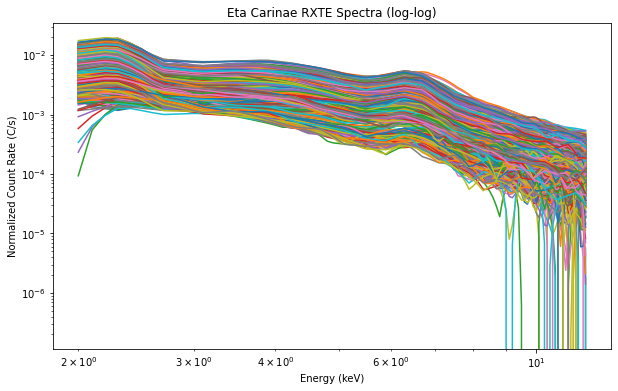

In [9]:
xvals=np.tile(xref,(specs.shape[0],1))
plt.figure(figsize=(10,6));
plt.plot(xvals.T,specs.T);
plt.semilogx();
plt.semilogy();
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Eta Carinae RXTE Spectra (log-log)');

<font size="3">Here we start the ML work.  Scale the spectra in order to compare the behavior, not the magnitude. Note that after applying the scaler, log-log plots will be nonsensical, so we will only plot on a linear scale
</font>

In [10]:
from sklearn.preprocessing import StandardScaler

scaled_specs=[]
for i in tqdm(range(specs.shape[0])):
    s=StandardScaler()
    scaled_specs.append(s.fit_transform(specs[i].reshape(-1,1)).T[0])
scaled_specs=np.array(scaled_specs)

100% 1368/1368 [00:01<00:00, 1119.95it/s]


<font size="3">Plot the scaled and unscaled spectra for comparison</font>

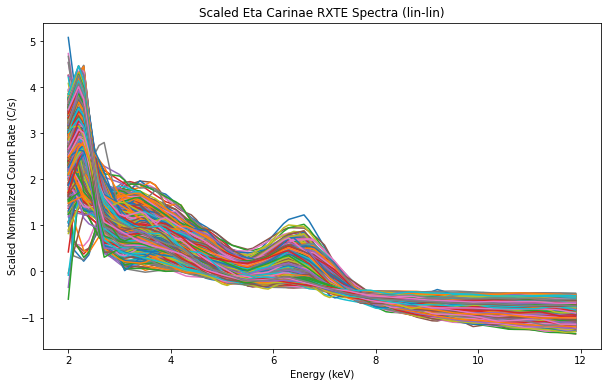

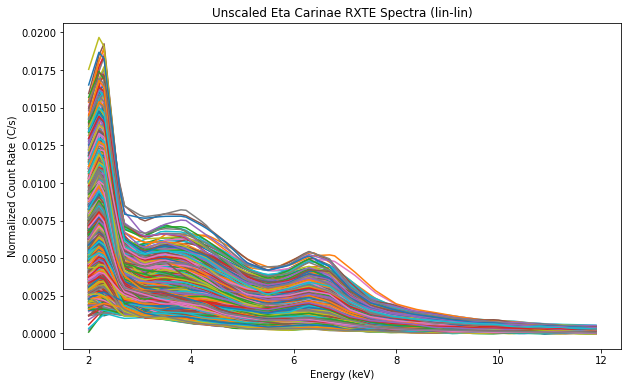

In [11]:
plt.figure(figsize=(10,6));
plt.plot(xvals.T,scaled_specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Scaled Normalized Count Rate (C/s)');
plt.title('Scaled Eta Carinae RXTE Spectra (lin-lin)');

plt.figure(figsize=(10,6));
plt.plot(xvals.T,specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra (lin-lin)');

<font size="3">Note that the scaled spectra all have a similiar shape AND magnitude, whereas the unscaled spectra have a similar shape but not mangitude.
Scaling has the effect of making big features smaller, but small features bigger. So, let's cut off the spectra at 9 keV in order to avoid noise driving the analysis, then rescale.</font>

In [12]:
specs=specs[:,:xref[xref<=9.0001].shape[0]]
xref=xref[:xref[xref<=9.0001].shape[0]]

scaled_specs=[]
for i in tqdm(range(specs.shape[0])):
    s=StandardScaler()
    scaled_specs.append(s.fit_transform(specs[i].reshape(-1,1)).T[0])
scaled_specs=np.array(scaled_specs)    

100% 1368/1368 [00:01<00:00, 1113.88it/s]


<font size="3">Plot the scaled and unscaled spectra for comparison</font>

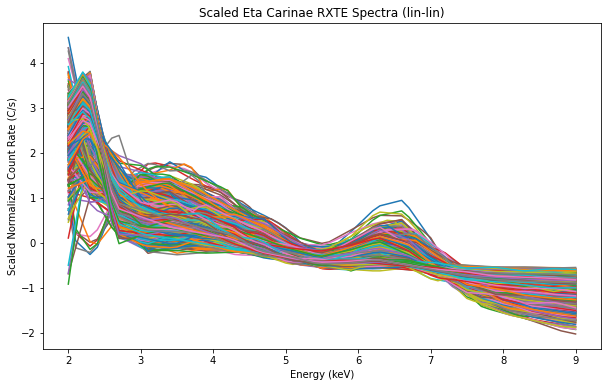

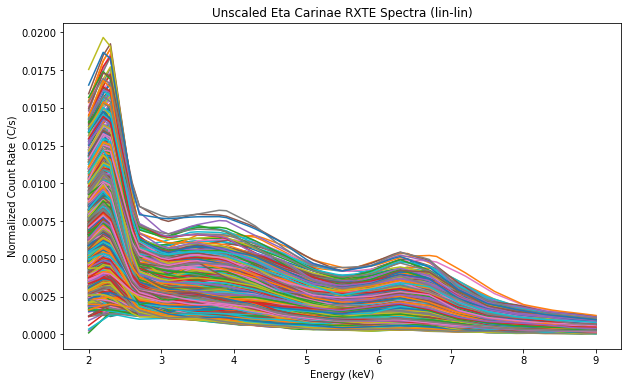

In [13]:
xvals=np.tile(xref,(specs.shape[0],1))
plt.figure(figsize=(10,6));
plt.plot(xvals.T,scaled_specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Scaled Normalized Count Rate (C/s)');
plt.title('Scaled Eta Carinae RXTE Spectra (lin-lin)');

plt.figure(figsize=(10,6));
plt.plot(xvals.T,specs.T);
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra (lin-lin)');

<font size="3">Great! The scaled spectra are now ready for analysis.  Let's see how Principal Component Analysis interprets the spectra in two dimensions...</font>

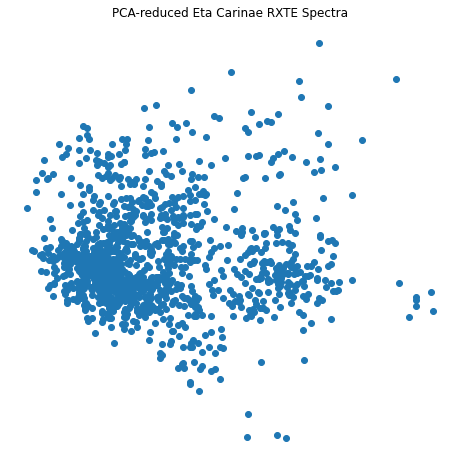

In [14]:
from sklearn.decomposition import PCA

# For comparison, compute PCA
pca=PCA(n_components=2)
scaled_specs_pca=pca.fit_transform(scaled_specs)
plt.figure(figsize=(8,8))
plt.scatter(scaled_specs_pca[:,0],scaled_specs_pca[:,1]);
plt.title('PCA-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">PCA preserves distance, but has no concept of high-dimensional groupings.  For comparison, compute TSNE, which can extract local high-dimensional relationships.
</font>

/home/idies/miniconda3/envs/heasoft/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/idies/miniconda3/envs/heasoft/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


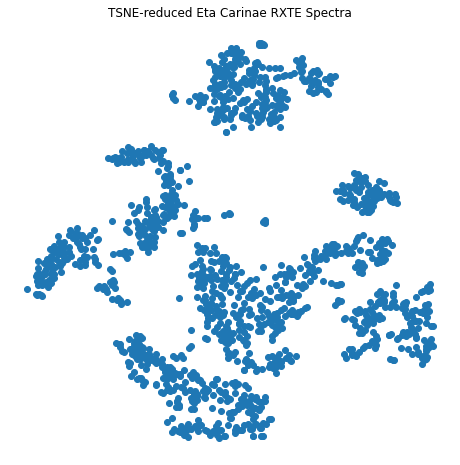

In [15]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2)
scaled_specs_tsne=tsne.fit_transform(scaled_specs)
plt.figure(figsize=(8,8))
plt.scatter(scaled_specs_tsne[:,0],scaled_specs_tsne[:,1]);
plt.title('TSNE-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">TSNE indeed finds some local groupings, so let's check UMAP, which will allow us to understand local and global relationships.
</font>

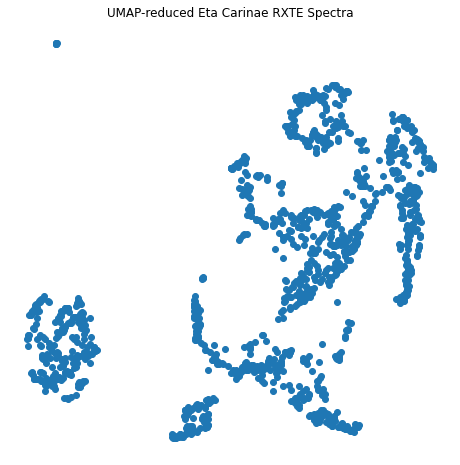

In [16]:
from umap import UMAP

um=UMAP(random_state=1)
scaled_specs_umap=um.fit_transform(scaled_specs)
plt.figure(figsize=(8,8))
plt.scatter(scaled_specs_umap[:,0],scaled_specs_umap[:,1]);
plt.title('UMAP-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">PCA only represents distance between the high dimensional samples whereas TSNE can find local groupings.
UMAP combines the two into a more intelligent representation that understands both local and global distance.
Let's cluster the UMAP representation using DBSCAN....
</font>

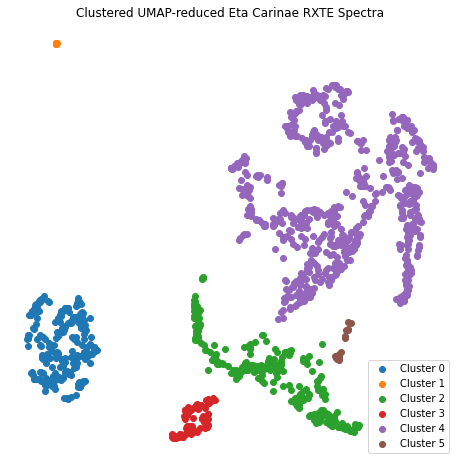

In [17]:
from sklearn.cluster import DBSCAN

dbs=DBSCAN(eps=.6,min_samples=2)
clusters=dbs.fit(scaled_specs_umap)
labels=np.unique(clusters.labels_)
plt.figure(figsize=(8,8))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(scaled_specs_umap[clusters.labels_==i,0],scaled_specs_umap[clusters.labels_==i,1],label='Cluster '+str(i));
plt.legend()
plt.title('Clustered UMAP-reduced Eta Carinae RXTE Spectra');
plt.axis('off');

<font size="3">The DBSCAN clustering produced some interesting groupings - we should examine the spectra of each group.
For a less crowded plot of the spectra clusters, plot the mean spectrum of each cluster.
</font>

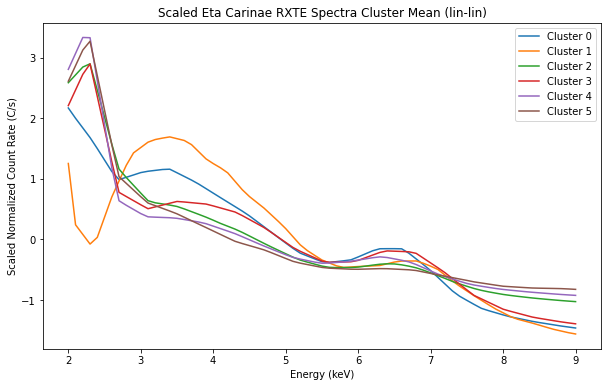

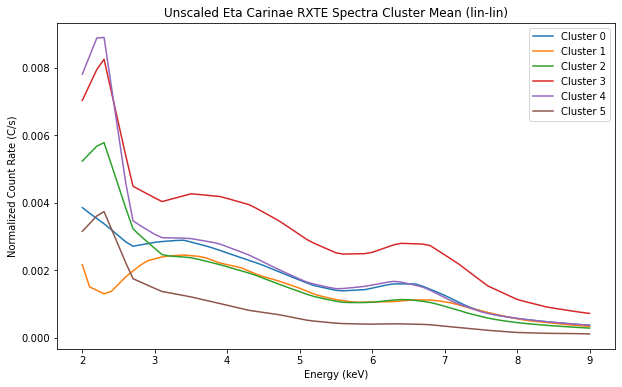

In [18]:
# Plot the scaled spectra mean
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.plot(xref,scaled_specs[clusters.labels_==i].mean(axis=0),label='Cluster '+str(i))
plt.legend();
plt.xlabel('Energy (keV)');
plt.ylabel('Scaled Normalized Count Rate (C/s)');
plt.title('Scaled Eta Carinae RXTE Spectra Cluster Mean (lin-lin)');

# Plot the unscaled spectra mean
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.plot(xref,specs[clusters.labels_==i].mean(axis=0),label='Cluster '+str(i))
plt.legend();
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra Cluster Mean (lin-lin)');


<font size="3">
Clearly, the strangest spectra belong to cluster 1 (orange).
How many spectra are in this group?
</font>

In [19]:
scaled_specs[clusters.labels_==1].shape[0]

7

<font size="3">
So, we can say that this group is not likely an isolated incident caused by mechanical malfunction
since similar spectra occur in seven different observations.  Let's look at the overall light curve to see where these odd spectra are occuring.

</font>

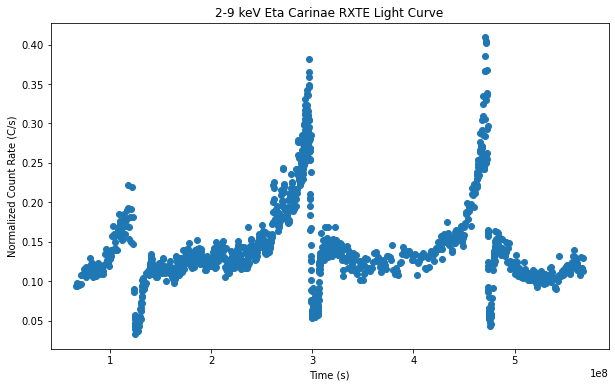

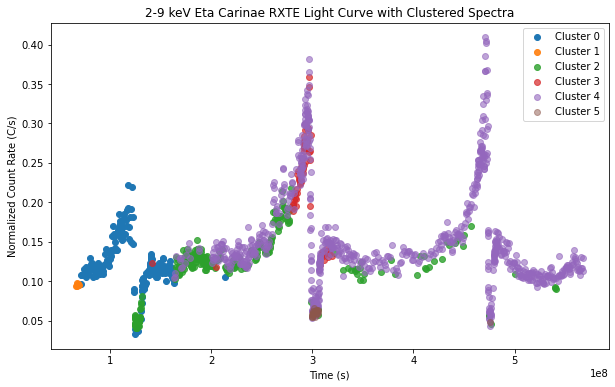

In [20]:
# Sum the count rate across the energy range
specsum=specs.sum(axis=1)

# plot the overall light curve
plt.figure(figsize=(10,6))
plt.scatter(times,specsum)
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve');


# plot the clustered light curve
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(np.array(times)[clusters.labels_==i],specsum[clusters.labels_==i],label='Cluster '+str(i),alpha=1-.1*i)
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve with Clustered Spectra');
plt.legend();

<font size="3">
We can see that the orange group occurred near the beginning of the RXTE mission.
Let's take a closer look...
</font>

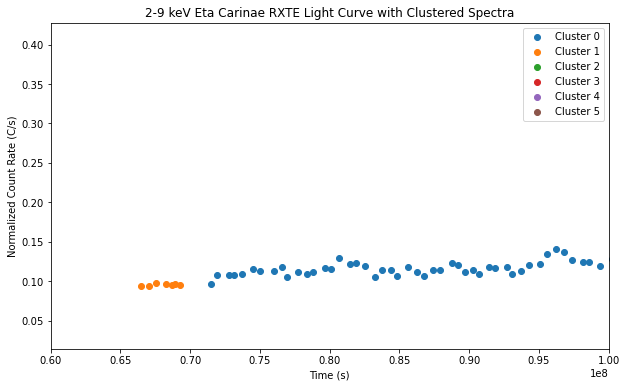

In [21]:
# plot the clustered light curve
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(np.array(times)[clusters.labels_==i],specsum[clusters.labels_==i],label='Cluster '+str(i))
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve with Clustered Spectra');
plt.legend();
plt.xlim(.6e8,1e8);

<font size="3">
Indeed, the orange group were the first seven observations of Eta Car from RXTE.
Given that this type of spectra does not repeat again, the earlier hypothesis that these
spectra are not due to mechanical issues must be revisted.
Also, given that the blue group also lacks the 2-3 keV noise peak and is only located toward 
the beginning of the mission, it may be the case that the background estimation from 
that period of time differs substantially.

So, what else is interesting?
Cluster 5 (the brown group) occurs exclusively at the overall light curve minima.
Looking again at the unscaled spectra means:
</font>

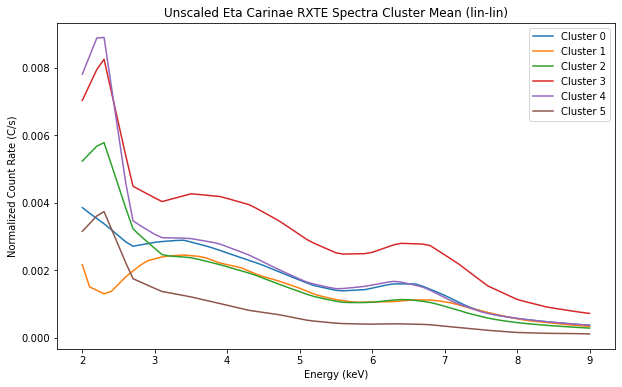

In [22]:
# Plot the unscaled spectra mean
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.plot(xref,specs[clusters.labels_==i].mean(axis=0),label='Cluster '+str(i))
plt.legend();
plt.xlabel('Energy (keV)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('Unscaled Eta Carinae RXTE Spectra Cluster Mean (lin-lin)');

<font size="3">
We can see that the broad peak associated with the 3-5 keV energy range is completely absent from the brown group.
Since this phenomena is documented at both X-ray minimums from the latter part of the mission (the earlier minimum may
be skewed by background estimation as well) we can say that this spectral difference is likely due to a substantial change
in the nature of the Eta Carina stellar system at this time.


Also interesting is the Green and Purple group relationship.  Let's exlude the earlier measurements, where we suspect the background
estimation may be wrong, and show the overall light curve again:

</font>

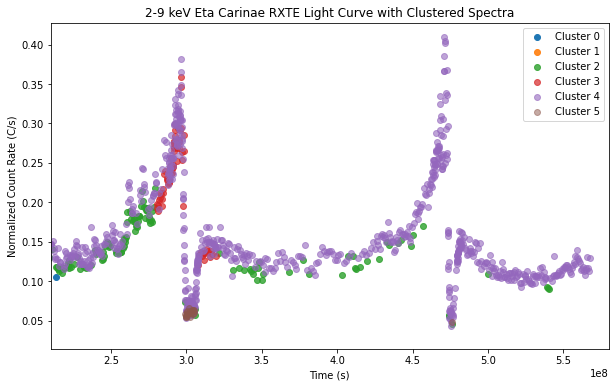

In [23]:
plt.figure(figsize=(10,6))
for i in range(len(np.unique(labels[labels>=0]))):
    plt.scatter(np.array(times)[clusters.labels_==i],specsum[clusters.labels_==i],label='Cluster '+str(i),alpha=1-.1*i)
plt.xlabel('Time (s)');
plt.ylabel('Normalized Count Rate (C/s)');
plt.title('2-9 keV Eta Carinae RXTE Light Curve with Clustered Spectra');
plt.legend();
plt.xlim(2.1e8,5.8e8);

<font size="3">
The green group, which has a lower 3-5 keV peak and a slightly higher energy peak in the 6-7 keV range than the purple group, 
appears to occur in conjunction with the purple group.  This may indicate the presence of two competing behaviors.
</font>

<font size="3">With very little code, we have now gained a basic understanding of Eta Carinae from a minimal analysis of HEASARC data.</font>